# Detección de anomalías

**Autores**

* Pedro Hernández
* Aaron Lara
* Benjamin López

En esta libreta de Jupyter se realizará una detección de anomalías mediante dos métodos diferentes. Los algoritmos que se probarán son: *Local Outlier Factor* y *Z-score*. El objetivo es encontrar comportamientos atípicos en las temperatras registradas a lo largo de los años.

El conjunto de datos sobre el que se trabajará fue extraído de la [base de datos climatológica nacional (sistema CLICOM)](http://clicom-mex.cicese.mx/) donde se recopilan los datos de las estaciones climáticas superficiales de México. En esta ocasión, se trabajará específicamente sobre las lecturas climatológicas realizadas en las estaciones del municipio de Hermosillo, Sonora desde 1965 hasta 2016.


## Importación de las Librerías

In [1]:
# Para el manejo eficiente del conjunto de datos
import pandas as pd 
import numpy as np
# Para el manejo de modelos estadísticos
from scipy import stats
# Para construir los elementos gráficos
import seaborn as sns 
import matplotlib.pyplot as plt
# Para la visualización de los valores nulos
import missingno as msno
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

## Extracción de los datos

El sistema CLICOM carece de una API para la extracción de sus datos. Por este motivo se han descargado manualmente los archivos csv correspondientes a cada variable y a cada estación climatológica del estado de Sonora. Los csvs originales se encuentran comprimidos en el archivo [datos/clicom_mex_cicese_sonora.zip]().

Para unir todos los datos en un solo archivo se construyó el script [joinData.py](). Este programa une y comprime los datos; el resultado se encuentra almacenado en el archivo [datos/datos_sonora.zip](). A continuación, el código correspondiente:

```python
'''
    Este script une todos los datos descargados del sistema CLICOM (http://clicom-mex.cicese.mx/)
    almacenados en archivos csv independientes. 
    
    Los csvs originales se encuentran comprimidos en datos/clicom_mex_cicese_sonora.zip. El 
    dataframe resultante de la unión de los datos se comprimirá y almacenará en el archivo
    datos/datos_sonora.zip.
'''

# Se importan las dependencias
import pandas as pd
import os
import shutil
import zipfile
from zipfile import ZipFile

# Ruta a la carpeta de datos
data_path = './datos'
# Ruta al archivo comprimido que contiene los csvs originales
zip_file = f"{data_path}/clicom_mex_cicese_sonora.zip"
# Ruta en donde se descomprimirán todos los csvs para su posterior manejo
data_folder = f"{data_path}/clicom_mex_cicese_sonora"


def readCsvAsDataFrame(file_path):
    """
        Esta función lee un csv al estilo del sistema CLICOM y cambia su formato
        de acuerdo a las necesidades de este proyecto.
        
        Parámetros
        ----------
        file_path: Ruta hacia el csv que se desea leer.
        
        Regresa
        -------
        current_df: Dataframe que contiene la información del csv
                    pero con el formato corregido.
    """
    # Se abre el archivo
    file = open(file_path) 
    # Se lee el id de la estación
    id_estacion = file.readline().split(',')[1].strip() 
    # Se lee el nombre de la estación
    nombre_estacion = file.readline().split(',')[1].strip() 
    # Se leen las coordenadas geográficas de la estación
    coordenadas_geograficas_estacion = file.readline().split(',')[1].strip() 
    # Se lee la variable que contiene el archivo
    variable = file.readline().split(',')[1].strip() 
    # Se cierra el archivo
    file.close() 

    # Se leen como csv todos los renglones después de la cabecera del archivo. Al mismo tiempo se 
    # forma la fecha con las primeras 3 columnas.
    current_df = pd.read_csv(file_path, skiprows=7, parse_dates={'Fecha':[0,1,2]})
    # Se cambia de nombre la columna "Datos" por el nombre de la variable en cuestión
    current_df.rename(columns={'Datos': variable}, inplace=True)
    # Se añade el id, nombre y coordenadas geográficas de la estación. Estos datos se obtuvieron
    # del encabezado.
    current_df['IdEstacion'] = id_estacion
    current_df['NombreEstacion'] = nombre_estacion
    current_df['CoordGeoEstacion'] = coordenadas_geograficas_estacion
    
    return current_df

# Se extraen los datos del .zip en la carpeta especificada
with ZipFile(zip_file, 'r') as zip:
    zip.extractall(data_path)

# Se crea una lista con los csvs
archivos = os.listdir(data_folder)

# Se intentan remover los checkpoints de Jupyter en caso de que existan
try:
    archivos.remove('.ipynb_checkpoints')
except:
    None

# En este diccionario se van a guardar los dataframes leídos ordenados por variable para evitar duplicar columnas al momento de
# ejecutar el outer join
dfs_dict = {'Evaporación (mm)':[], 'Precipitación (mm)':[], 'Temp Máxima (oC)':[], 'Temp Mínima (oC)':[], 'Temp Promedio (oC)':[], 'Unidades Calor (oD)':[]}

# Se itera cada uno de los csv's para leerlos y almacenarlos en el diccionario
for file in archivos:
    # Se construye el path hacia el archivo y se crea el dataframe
    file_path = f"{data_folder}/{file}"
    current_df = readCsvAsDataFrame(file_path)
    # Se añade el archivo en su llave correspondiente del diccionario.
    # El elemento [1] de la lista de columnas current_df.columns corresponde al nombre de la variable en cuestión
    dfs_dict[current_df.columns[1]].append(current_df)
    
print("Se acaban de leer los csvs como dfs")
shutil.rmtree(data_folder) # Se elimina el folder de datos extraídos

# Una vez que se tienen todos los dataframes separados por variable, se concatenan para formar un solo dataframe por variable
for key in dfs_dict.keys():
    # Se obtiene el primer dataframe de la variable actual para poder correr la rutina de concatenación
    variable_df = dfs_dict[key].pop()
    # Se concatenan todos los demás dataframes en uno mismo 
    while dfs_dict[key]:
        variable_df = pd.concat([variable_df, dfs_dict[key].pop()])
    # Una vez que todos los dataframes estén concatenados se guarda el dataframe entero 
    # en el diccionario. Es decir, se reemplaza la lista de dataframes de la variable en cuestión 
    # por un solo dataframe
    dfs_dict[key] = variable_df

print("Se acaban de concatenar los dfs para formar un solo df por cada variable")

# En este punto ya tenemos un dataframe por cada variable. Ahora se va a realizar un outer join entre los 6 dataframes que representan
# a cada una de las variables
keys = [key for key in dfs_dict.keys()] # Se obtienen las llaves del diccionario, es decir, el nombre de cada variable
full_df = dfs_dict[keys.pop()] # Se toma algún dataframe para poder realizar los joins
# Mientras existan variables sin visitar, hacemos join del dataframe correspondiente a la variable con
# el full_df
while keys:
    full_df = pd.merge(full_df, dfs_dict[keys.pop()], on=['Fecha', 'IdEstacion', 'NombreEstacion', 'CoordGeoEstacion'], how='outer')

print("Se unieron todos los dataframes con outer joins")
# Se reordenan las columnas
ordered_columns = ['Fecha', 'IdEstacion', 'NombreEstacion', 'CoordGeoEstacion', 'Temp Mínima (oC)', 
                   'Temp Máxima (oC)', 'Temp Promedio (oC)', 'Unidades Calor (oD)', 'Evaporación (mm)', 'Precipitación (mm)']
full_df = full_df[ordered_columns]

print(full_df.head(10))

# Se guarda el archivo de resultados
full_df.to_csv(f'{data_path}/datos_sonora.csv', index=False)
# Se comprimen los resultados
with ZipFile(f'{data_path}/datos_sonora.zip', 'w') as zip:
    zip.write(f'{data_path}/datos_sonora.csv', compress_type=zipfile.ZIP_DEFLATED)
# Se elimina el csv
os.remove(f'{data_path}/datos_sonora.csv')
```

El conjunto de datos de todo el estado de Sonora es muy amplio (más de tres millones de registros). Por ese motivo únicamente trabajaremos con los registros correspondientes al municipio de Hermosillo que se encuentran almacenados en el archivo [datos/datos_hermosillo.zip](). Para realizar esta tarea basta con encontrar todos aquellos registros que pertenezcan a las estaciones de Hermosillo, la Universidad de Sonora y Bahía de Kino.

## Limpieza de datos

### Se cargan los datos crudos del municiío de Hermosillo desde el archivo comprimido correspondiente

In [2]:
df = pd.read_csv("datos/datos_hermosillo.zip", low_memory=False)

In [3]:
df.head(3)

Fecha  IdEstacion     NombreEstacion                CoordGeoEstacion  \
0  1974-07-01       26179  BAHIA DE KINO-SON  28.8227777778N -111.948888889W   
1  1974-07-02       26179  BAHIA DE KINO-SON  28.8227777778N -111.948888889W   
2  1974-07-03       26179  BAHIA DE KINO-SON  28.8227777778N -111.948888889W   

   Temp Mínima (oC)  Temp Máxima (oC)  Temp Promedio (oC)  \
0              22.0              35.0               28.50   
1              22.5              34.0               28.25   
2              21.0              31.5               26.25   

   Unidades Calor (oD)  Evaporación (mm)  Precipitación (mm)  
0                17.13               7.3                 0.0  
1                17.21              10.5                 0.0  
2                16.01              13.6                 0.0

In [4]:
df.tail(3)

Fecha  IdEstacion           NombreEstacion  \
49671  2016-09-28       26139  HERMOSILLO II (DGE)-SON   
49672  2016-09-29       26139  HERMOSILLO II (DGE)-SON   
49673  2016-09-30       26139  HERMOSILLO II (DGE)-SON   

                     CoordGeoEstacion  Temp Mínima (oC)  Temp Máxima (oC)  \
49671  29.0988888889N -110.965833333W              22.0              35.0   
49672  29.0988888889N -110.965833333W              24.0              37.5   
49673  29.0988888889N -110.965833333W              24.5              37.0   

       Temp Promedio (oC)  Unidades Calor (oD)  Evaporación (mm)  \
49671                 NaN                17.13               NaN   
49672                 NaN                18.21               NaN   
49673                 NaN                18.37               NaN   

       Precipitación (mm)  
49671                 0.0  
49672                 0.0  
49673                 0.0

In [5]:
print("Número de renglones y columnas:", df.shape)

Número de renglones y columnas: (49674, 10)


### Ajuste de los tipos de datos y nombres de las variables

In [6]:
df.dtypes

Fecha                   object
IdEstacion               int64
NombreEstacion          object
CoordGeoEstacion        object
Temp Mínima (oC)       float64
Temp Máxima (oC)       float64
Temp Promedio (oC)     float64
Unidades Calor (oD)    float64
Evaporación (mm)       float64
Precipitación (mm)     float64
dtype: object

Como podemos observar, Pandas toma la fecha como una variable tipo `object` (`str`). Además, los nombres de las columnas contienen las unidades pero podemos prescindir de éstas. Por último, no estamos interesados en algunas columnas como el ID de las estaciones o las coordenadas geográficas. Necesitamos corregir estos detalles para manejar los datos de manera adecuada.

In [7]:
# Renombrando las columnas
nuevas_columnas = {'NombreEstacion':'Estacion', 'Temp Mínima (oC)':'Tmin', 'Temp Máxima (oC)':'Tmax', 
                   'Temp Promedio (oC)':'Tprom', 'Unidades Calor (oD)':'UCalor', 
                   'Evaporación (mm)':'Evap', 'Precipitación (mm)':'Precip'
                  }
df.rename(columns=nuevas_columnas, inplace=True)
# Eliminamos las columnas que no nos interesan
df = df.iloc[:,[0,2,4,5,7,8,9]]

In [8]:
# Corrección del tipo de datos de la fecha
df.Fecha = pd.to_datetime(df.Fecha)

In [9]:
# Verificación de los cambios
df.dtypes

Fecha       datetime64[ns]
Estacion            object
Tmin               float64
Tmax               float64
UCalor             float64
Evap               float64
Precip             float64
dtype: object

In [10]:
df.describe()

Tmin          Tmax        UCalor          Evap        Precip
count  39833.000000  39839.000000  39423.000000  25014.000000  40264.000000
mean      16.011566     31.108823     12.577707      7.137907      0.816119
std        7.074931      6.896338      5.144609      3.395388      4.986201
min       -4.000000      0.000000      0.000000      0.080000      0.000000
25%       10.000000     26.000000      8.040000      4.500000      0.000000
50%       15.000000     32.000000     13.200000      6.800000      0.000000
75%       22.500000     37.000000     17.450000      9.500000      0.000000
max       32.000000     49.000000     20.000000     18.000000    152.600000

### Revisión de valores faltantes

In [11]:
df.isnull().sum()

Fecha           0
Estacion        0
Tmin         9841
Tmax         9835
UCalor      10251
Evap        24660
Precip       9410
dtype: int64

Podemos notar que existen muchos valores faltantes. Algunas gráficas y porcentajes nos ayudarán a darnos una mejor idea del comportamiento de los datos nulos

<AxesSubplot:>

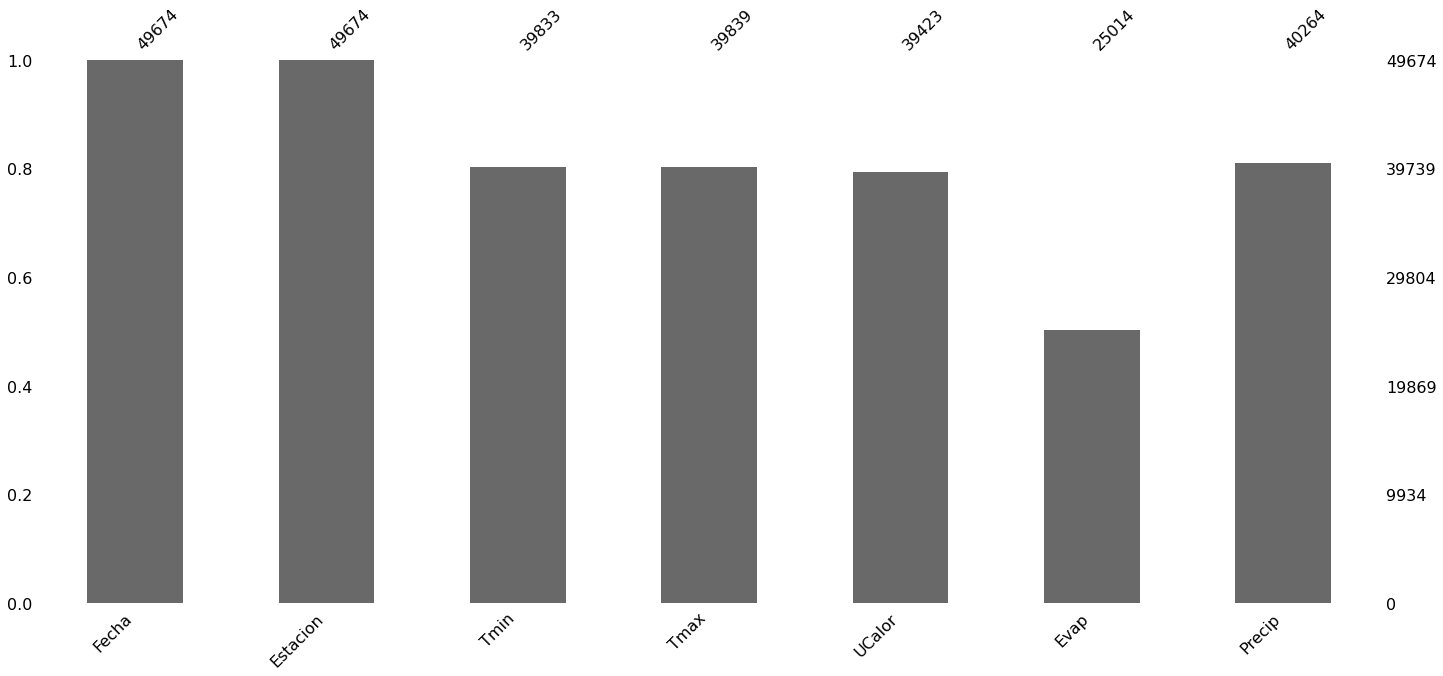

In [12]:
msno.bar(df)

<AxesSubplot:>

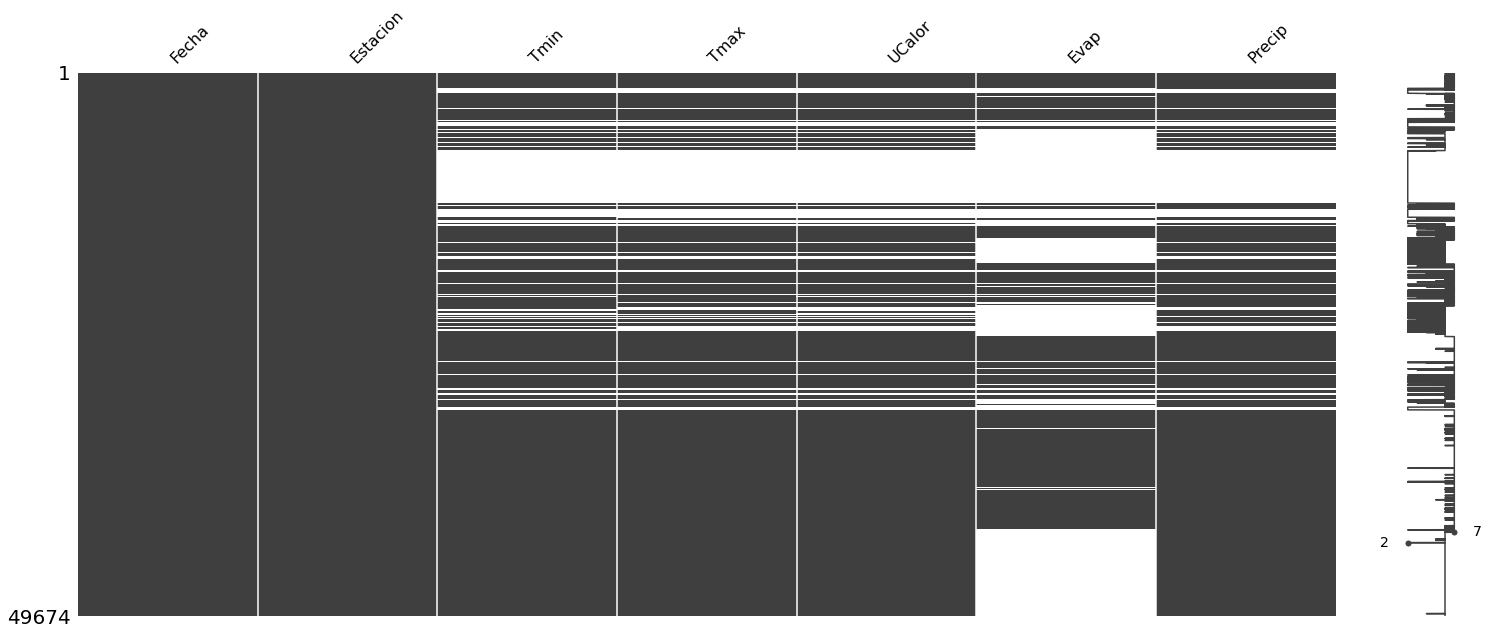

In [13]:
msno.matrix(df)

In [14]:
print("Porcentaje de valores nulos por columna\n")
total_rows = len(df)
for c in df.columns:
    num_nans = df[c].isna().sum()
    print(f"{c}: {num_nans} -> ({str(num_nans/total_rows*100)[:5]}%)")

Porcentaje de valores nulos por columna

Fecha: 0 -> (0.0%)
Estacion: 0 -> (0.0%)
Tmin: 9841 -> (19.81%)
Tmax: 9835 -> (19.79%)
UCalor: 10251 -> (20.63%)
Evap: 24660 -> (49.64%)
Precip: 9410 -> (18.94%)


Todas las variables de interés (desde `Tmin` hasta `Precip`) tienen un alto porcentaje de valores nulos, por este motivo sería buena idea realizar imputaciones. 

Podemos realizar las imputaciones utilizando alguna medida de tendencia central (mediana o promedio) basándonos en las temperaturas observadas en una determinada región y un periodo de tiempo. Por ejemplo, las temperaturas mínimas en los meses de invierno son mucho más bajas que en los meses de verano; a su vez, las temperaturas, precipitaciones y evaporación al norte del estado son considerablemente diferentes a las del sur.

Para cumplir este objetivo se utilizará el siguiente algoritmo:
* Por cada año, mes y municipio:
    * Por cada variable con datos nulos:
        * Realizar una prueba de hipótesis para saber si la distribución de la 
          variable se asemeja a una distribución normal
        * Si la distribución se parece a una normal ($p-valor<=0.05$), imputar con el valor promedio
        * Si la distribución no se parece a una normal ($p-valor>0.05$), imputar con la mediana
            


#### Imputación de los valores nulos

Para identificar más fácilmente las regiones a las que pertenece cada estación, el nombre de éste se añadirá a cada observación en una columna nueva

In [15]:
df['Municipio'] = df.Estacion.apply(lambda estacion: estacion.split('-')[0])
df

Fecha                 Estacion  Tmin  Tmax  UCalor  Evap  Precip  \
0     1974-07-01        BAHIA DE KINO-SON  22.0  35.0   17.13   7.3     0.0   
1     1974-07-02        BAHIA DE KINO-SON  22.5  34.0   17.21  10.5     0.0   
2     1974-07-03        BAHIA DE KINO-SON  21.0  31.5   16.01  13.6     0.0   
3     1974-07-04        BAHIA DE KINO-SON  28.0  41.0   19.66  10.7     0.0   
4     1974-07-05        BAHIA DE KINO-SON  28.0  35.0   19.53  10.9     0.0   
...          ...                      ...   ...   ...     ...   ...     ...   
49669 2016-09-26  HERMOSILLO II (DGE)-SON  24.0  36.0   18.09   NaN     5.2   
49670 2016-09-27  HERMOSILLO II (DGE)-SON  21.0  35.5   16.75   NaN     0.0   
49671 2016-09-28  HERMOSILLO II (DGE)-SON  22.0  35.0   17.13   NaN     0.0   
49672 2016-09-29  HERMOSILLO II (DGE)-SON  24.0  37.5   18.21   NaN     0.0   
49673 2016-09-30  HERMOSILLO II (DGE)-SON  24.5  37.0   18.37   NaN     0.0   

                 Municipio  
0            BAHIA DE KINO  
1            BAHIA DE KINO  
2            BAHIA DE KINO  
3            BAHIA DE KINO  
4            BAHIA DE KINO  
...                    ...  
49669  HERMOSILLO II (DGE)  
49670  HERMOSILLO II (DGE)  
49671  HERMOSILLO II (DGE)  
49672  HERMOSILLO II (DGE)  
49673  HERMOSILLO II (DGE)  

[49674 rows x 8 columns]

### Eliminamos valores vacios.

In [16]:
df.dropna(subset=['Tmin','Tmax','UCalor','Precip'], inplace=True)
df

Fecha                 Estacion  Tmin  Tmax  UCalor  Evap  Precip  \
0     1974-07-01        BAHIA DE KINO-SON  22.0  35.0   17.13   7.3     0.0   
1     1974-07-02        BAHIA DE KINO-SON  22.5  34.0   17.21  10.5     0.0   
2     1974-07-03        BAHIA DE KINO-SON  21.0  31.5   16.01  13.6     0.0   
3     1974-07-04        BAHIA DE KINO-SON  28.0  41.0   19.66  10.7     0.0   
4     1974-07-05        BAHIA DE KINO-SON  28.0  35.0   19.53  10.9     0.0   
...          ...                      ...   ...   ...     ...   ...     ...   
49669 2016-09-26  HERMOSILLO II (DGE)-SON  24.0  36.0   18.09   NaN     5.2   
49670 2016-09-27  HERMOSILLO II (DGE)-SON  21.0  35.5   16.75   NaN     0.0   
49671 2016-09-28  HERMOSILLO II (DGE)-SON  22.0  35.0   17.13   NaN     0.0   
49672 2016-09-29  HERMOSILLO II (DGE)-SON  24.0  37.5   18.21   NaN     0.0   
49673 2016-09-30  HERMOSILLO II (DGE)-SON  24.5  37.0   18.37   NaN     0.0   

                 Municipio  
0            BAHIA DE KINO  
1            BAHIA DE KINO  
2            BAHIA DE KINO  
3            BAHIA DE KINO  
4            BAHIA DE KINO  
...                    ...  
49669  HERMOSILLO II (DGE)  
49670  HERMOSILLO II (DGE)  
49671  HERMOSILLO II (DGE)  
49672  HERMOSILLO II (DGE)  
49673  HERMOSILLO II (DGE)  

[39348 rows x 8 columns]

In [17]:
# En este objeto grouby se almacenarán los "sub-dataframes" agrupados por año, mes y municipio
df_agrupado = df.groupby([df.Fecha.dt.year, df.Fecha.dt.month, 'Municipio'])

In [18]:
# Se importan las dependencias necesarias para realizar la prueba de hipótesis
from scipy.stats import skewtest
import math
# Se obtiene la cantidad de grupo s (año,mes,municipio)
n_groups = len(df_agrupado.indices.keys())
n_groups
i = 0 # Contador para saber cuánto le falta al proceso para terminar

# ----- COMIENZA EL ALGORITMO DE IMPUTACIÓN -----
# Cada elemento 'k' representa la lista de renglones correspondientes a cada grupo
for k in df_agrupado.indices.keys():
    # Se obtienen los índices correspondientes al grupo actual
    indices = df_agrupado.indices[k]
    # Se itera cada variable numérica para realizar la imputación
    # (4:Tmin, 5:Tmax, 6:Tprom, 7:UCalor, 8:Evap, 9:Precip)
    for column in [2,3,4,5,6,7]:
        # Se obtiene la porción del dataframe que corresponde al grupo y columna actual
        df_group = df.iloc[indices,column]
        # Primero se revisa si existen valores nulos en el grupo y columna que está 
        # siento revisada
        if df_group.isnull().values.any():
            # Si existen valores nulos se realiza un skew test para saber
            # si hay que imputar con la mediana o con la media.
            
            # En ocasiones las variables llegan a presentar valores nulos
            # en un mes completo. En este caso no tendríamos cómo
            # calcular una imputación, así que se imputará directamente con 0.
            # La necesidad del try-except radica en que para la prueba de hipótesis
            # necesita al menos 8 valores no nulos para poder calcular algo
            try:
                # Se obtiene el p-valor de la prueba de hipótesis
                pvalue = skewtest(df_group, nan_policy='omit')[1]
            except:
                # Si no se pudo realizar la prueba de hipótesis significa que la 
                # variable en cuestión presentó valores nulos por lo menos 22 días al mes.
                # (el método skewtest debe recibir por lo menos 8 valores).
                # En este caso se intenta imputar con la media. Si la media es nan, entonces
                # significa que no existen valores diferentes de nan en el mes completo. En ese
                # caso se imputa directamente con 0.
                mean = df_group.mean()
                if not math.isnan(mean):
                    df.iloc[indices, column] = df_group.fillna(mean)
                else:
                    df.iloc[indices, column] = df_group.fillna(0)
                continue
            
            # Si el pvalor es >.05 rechazamos la hipótesis de que los datos se 
            # distribuyen normalmente y se imputa con la mediana; en caso contrario, 
            # se imputa con la media
            if pvalue > .05:
                df.iloc[indices, column] = df_group.fillna(df_group.median())
            else:
                df.iloc[indices, column] = df_group.fillna(df_group.mean())
    i += 1
    print(f"{i}/{n_groups}",end='\r')
    

Revisemos que, en efecto, ya no existen valores nulos en nuestro conjunto de datos

In [19]:
df

Fecha                 Estacion  Tmin  Tmax  UCalor  Evap  Precip  \
0     1974-07-01        BAHIA DE KINO-SON  22.0  35.0   17.13   7.3     0.0   
1     1974-07-02        BAHIA DE KINO-SON  22.5  34.0   17.21  10.5     0.0   
2     1974-07-03        BAHIA DE KINO-SON  21.0  31.5   16.01  13.6     0.0   
3     1974-07-04        BAHIA DE KINO-SON  28.0  41.0   19.66  10.7     0.0   
4     1974-07-05        BAHIA DE KINO-SON  28.0  35.0   19.53  10.9     0.0   
...          ...                      ...   ...   ...     ...   ...     ...   
49669 2016-09-26  HERMOSILLO II (DGE)-SON  24.0  36.0   18.09   0.0     5.2   
49670 2016-09-27  HERMOSILLO II (DGE)-SON  21.0  35.5   16.75   0.0     0.0   
49671 2016-09-28  HERMOSILLO II (DGE)-SON  22.0  35.0   17.13   0.0     0.0   
49672 2016-09-29  HERMOSILLO II (DGE)-SON  24.0  37.5   18.21   0.0     0.0   
49673 2016-09-30  HERMOSILLO II (DGE)-SON  24.5  37.0   18.37   0.0     0.0   

                 Municipio  
0            BAHIA DE KINO  
1            BAHIA DE KINO  
2            BAHIA DE KINO  
3            BAHIA DE KINO  
4            BAHIA DE KINO  
...                    ...  
49669  HERMOSILLO II (DGE)  
49670  HERMOSILLO II (DGE)  
49671  HERMOSILLO II (DGE)  
49672  HERMOSILLO II (DGE)  
49673  HERMOSILLO II (DGE)  

[39348 rows x 8 columns]

<AxesSubplot:>

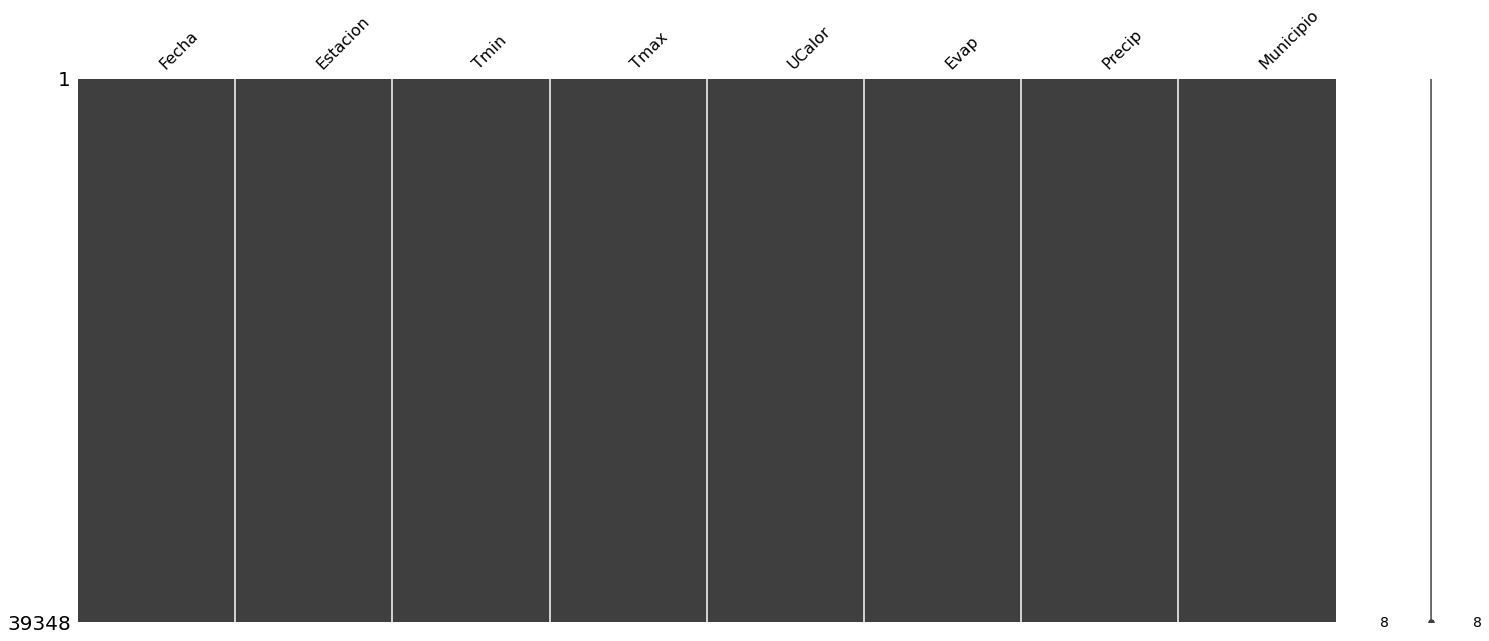

In [20]:
msno.matrix(df)

In [21]:
print("Porcentaje de valores nulos por columna\n")
total_rows = len(df)
for c in df.columns:
    num_nans = df[c].isna().sum()
    print(f"{c}: {num_nans} -> ({str(num_nans/total_rows*100)[:5]}%)")

Porcentaje de valores nulos por columna

Fecha: 0 -> (0.0%)
Estacion: 0 -> (0.0%)
Tmin: 0 -> (0.0%)
Tmax: 0 -> (0.0%)
UCalor: 0 -> (0.0%)
Evap: 0 -> (0.0%)
Precip: 0 -> (0.0%)
Municipio: 0 -> (0.0%)


Debido a que el algoritmo de imputación es computacionalmente costoso se almacenarán los datos sin valores faltantes para que no sea necesario correr dicho algoritmo cada vez que la libreta se ejecute.

In [22]:
from zipfile import ZipFile, ZIP_DEFLATED
import os
# Se guarda el archivo de resultados
df.to_csv(f'datos/datos_hermosillo_no_nans.csv', index=False)
# Se comprimen los resultados
with ZipFile(f'datos/datos_hermosillo_no_nans.zip', 'w') as zip:
    zip.write(f'datos/datos_hermosillo_no_nans.csv', compress_type=ZIP_DEFLATED)
# Se elimina el csv
os.remove(f'datos/datos_hermosillo_no_nans.csv')

## Análisis exploratorio de datos

Se leen los datos sin valores nulos de Hermosillo

In [23]:
# Se lee el csv sin datos faltantes
df = pd.read_csv('datos/datos_hermosillo_no_nans.zip')

In [24]:
df.head()

Fecha           Estacion  Tmin  Tmax  UCalor  Evap  Precip  \
0  1974-07-01  BAHIA DE KINO-SON  22.0  35.0   17.13   7.3     0.0   
1  1974-07-02  BAHIA DE KINO-SON  22.5  34.0   17.21  10.5     0.0   
2  1974-07-03  BAHIA DE KINO-SON  21.0  31.5   16.01  13.6     0.0   
3  1974-07-04  BAHIA DE KINO-SON  28.0  41.0   19.66  10.7     0.0   
4  1974-07-05  BAHIA DE KINO-SON  28.0  35.0   19.53  10.9     0.0   

       Municipio  
0  BAHIA DE KINO  
1  BAHIA DE KINO  
2  BAHIA DE KINO  
3  BAHIA DE KINO  
4  BAHIA DE KINO

In [25]:
df.tail()

Fecha                 Estacion  Tmin  Tmax  UCalor  Evap  Precip  \
39343  2016-09-26  HERMOSILLO II (DGE)-SON  24.0  36.0   18.09   0.0     5.2   
39344  2016-09-27  HERMOSILLO II (DGE)-SON  21.0  35.5   16.75   0.0     0.0   
39345  2016-09-28  HERMOSILLO II (DGE)-SON  22.0  35.0   17.13   0.0     0.0   
39346  2016-09-29  HERMOSILLO II (DGE)-SON  24.0  37.5   18.21   0.0     0.0   
39347  2016-09-30  HERMOSILLO II (DGE)-SON  24.5  37.0   18.37   0.0     0.0   

                 Municipio  
39343  HERMOSILLO II (DGE)  
39344  HERMOSILLO II (DGE)  
39345  HERMOSILLO II (DGE)  
39346  HERMOSILLO II (DGE)  
39347  HERMOSILLO II (DGE)

### Número de observaciones, valores faltantes y tipo de las variables

In [26]:
df.Fecha = pd.to_datetime(df.Fecha)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39348 entries, 0 to 39347
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Fecha      39348 non-null  datetime64[ns]
 1   Estacion   39348 non-null  object        
 2   Tmin       39348 non-null  float64       
 3   Tmax       39348 non-null  float64       
 4   UCalor     39348 non-null  float64       
 5   Evap       39348 non-null  float64       
 6   Precip     39348 non-null  float64       
 7   Municipio  39348 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 2.4+ MB


### Estadísticas básicas

In [27]:
df.describe()

Tmin          Tmax        UCalor          Evap        Precip
count  39348.000000  39348.000000  39348.000000  39348.000000  39348.000000
mean      16.028914     31.087346     12.577400      4.684699      0.810677
std        7.073905      6.890015      5.145804      4.350473      4.962344
min       -4.000000      6.000000      0.000000      0.000000      0.000000
25%       10.000000     26.000000      8.040000      0.000000      0.000000
50%       15.500000     31.500000     13.200000      4.400000      0.000000
75%       22.500000     37.000000     17.450000      8.000000      0.000000
max       32.000000     49.000000     20.000000     18.000000    152.600000

### Distribución de las variables

#### Temperaturas

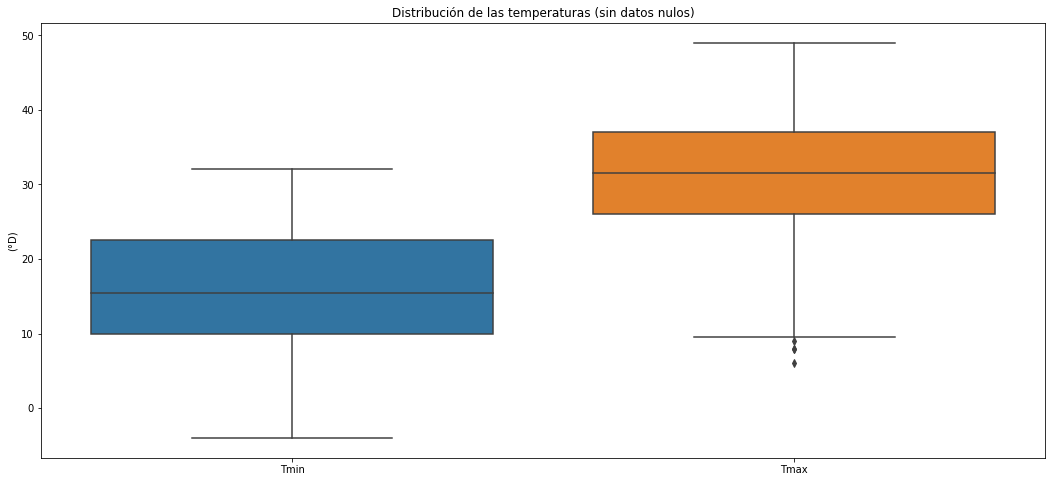

In [28]:
plt.figure(figsize = (18,8))
_ = sns.boxplot(x="variable", y="value", data=pd.melt(df.iloc[:,2:4])).set(title='Distribución de las temperaturas (sin datos nulos)', xlabel='', ylabel='(°D)')

#### Unidades de calor

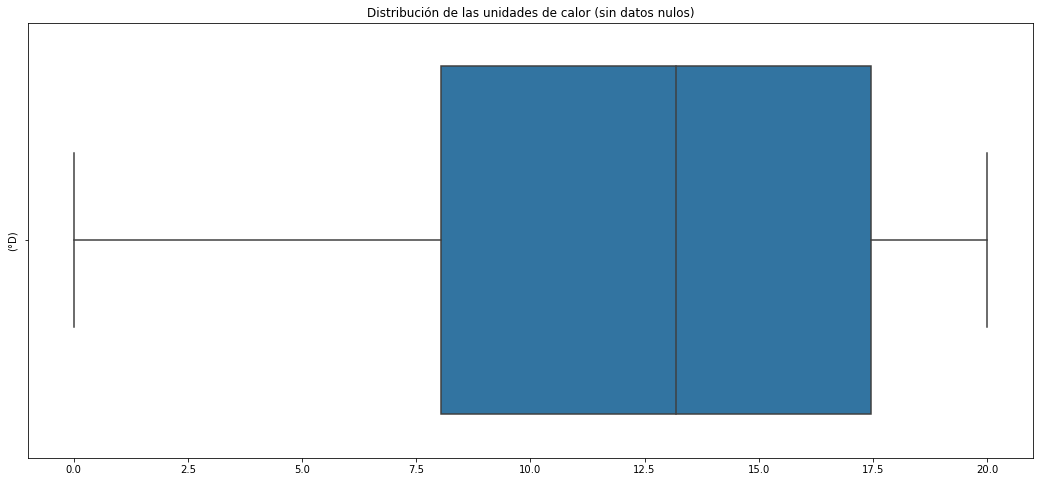

In [29]:
plt.figure(figsize = (18,8))
_ = sns.boxplot(x=df.UCalor).set(title='Distribución de las unidades de calor (sin datos nulos)', xlabel='', ylabel='(°D)')

#### Evaporación y precipitación

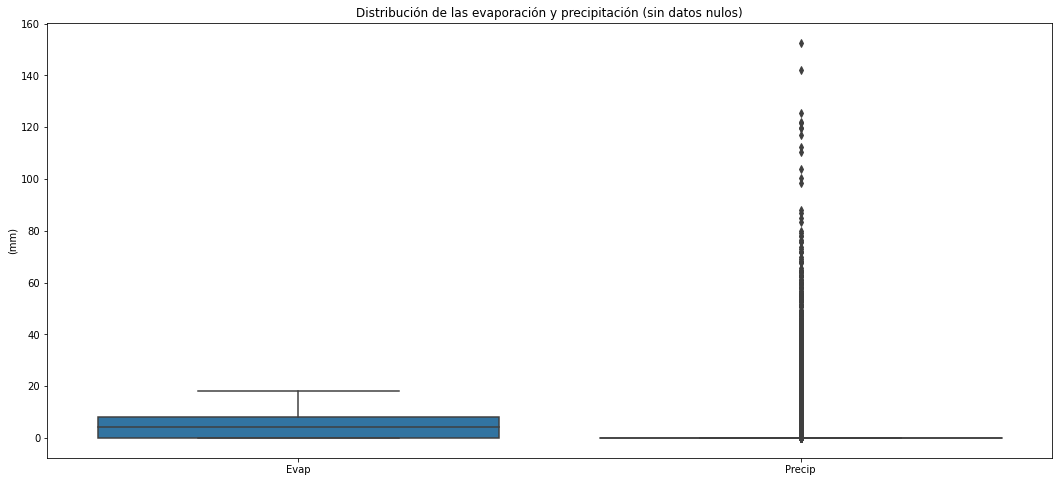

In [30]:
plt.figure(figsize = (18,8))
_ = sns.boxplot(x="variable", y="value", data=pd.melt(df.iloc[:,5:7])).set(title='Distribución de las evaporación y precipitación (sin datos nulos)', xlabel='', ylabel='(mm)')

En los diagramas de caja anteriores podemos observar que las temperaturas máximas y mínimas se distribuyen de una forma bastante uniforme y de acuerdo a lo que se espera: que las temperaturas mínimas sean menores a las máximas; sin embargo, la temperatura promedio sigue una distribución sesgada a la derecha.

Prácticamente no se detectan valores anómalos. Donde sí se aprecia una gran cantidad de éstos es en la variable `Precip`. La explicación a tal comportamiento puede inferirse si consideramos que Hermosillo tiene un clima desértico y llueve muy pocos días al año.

### Distribución de las variables por año

In [31]:
def distribucionPorAnio(df, variable, titulo, etiqueta_x, etiqueta_y):
    plt.figure(figsize = (30,8))
    g = sns.boxplot(x=df.Fecha.dt.year, y=variable, data=df).set(title=titulo, xlabel=etiqueta_x, ylabel=etiqueta_y)
    _ = plt.xticks(rotation=45)

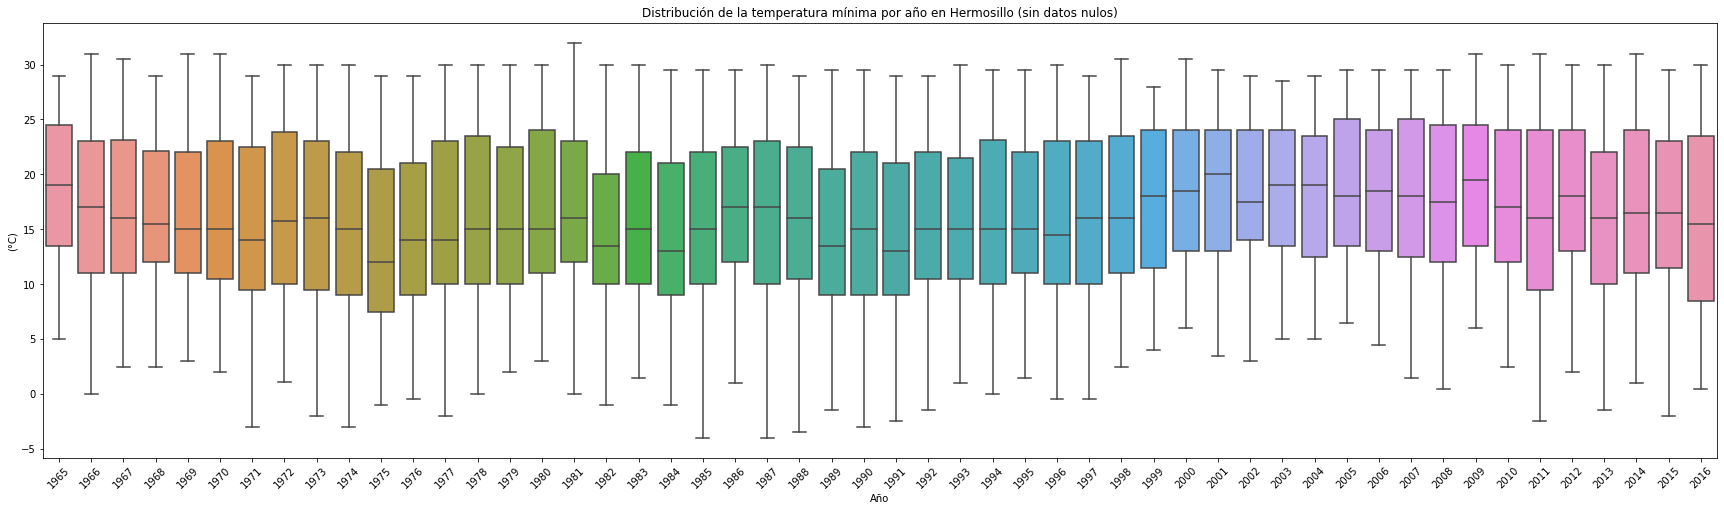

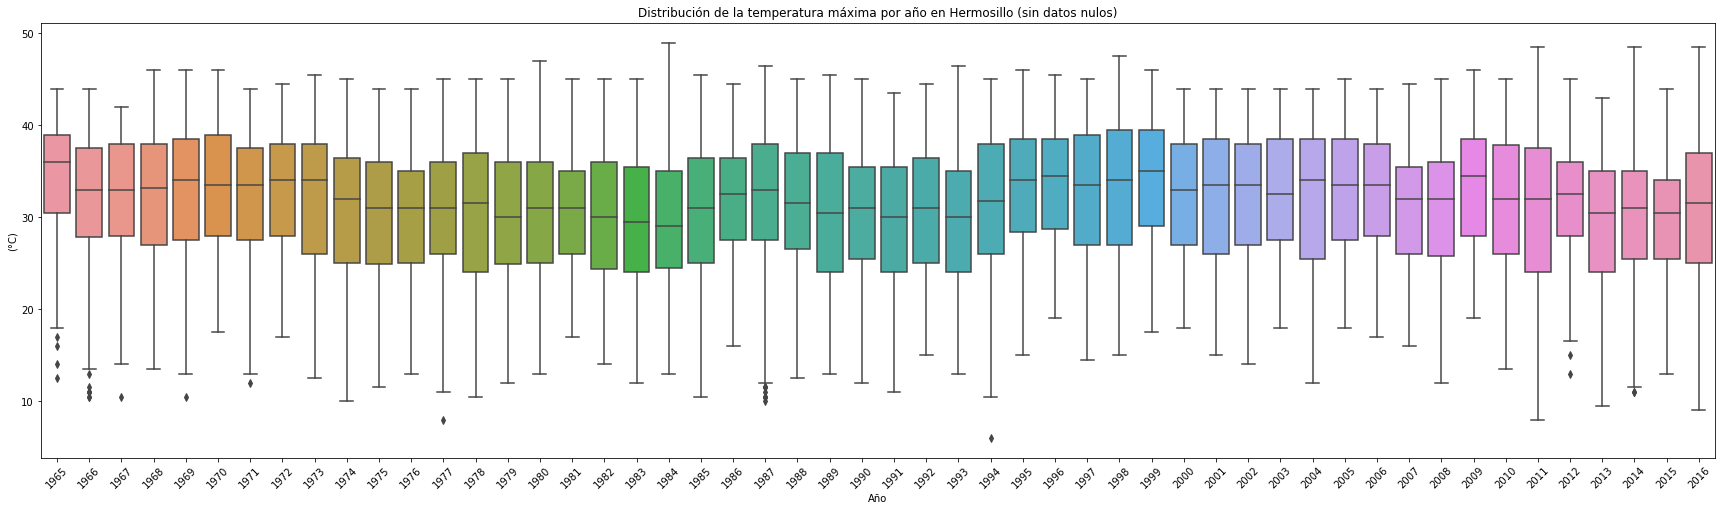

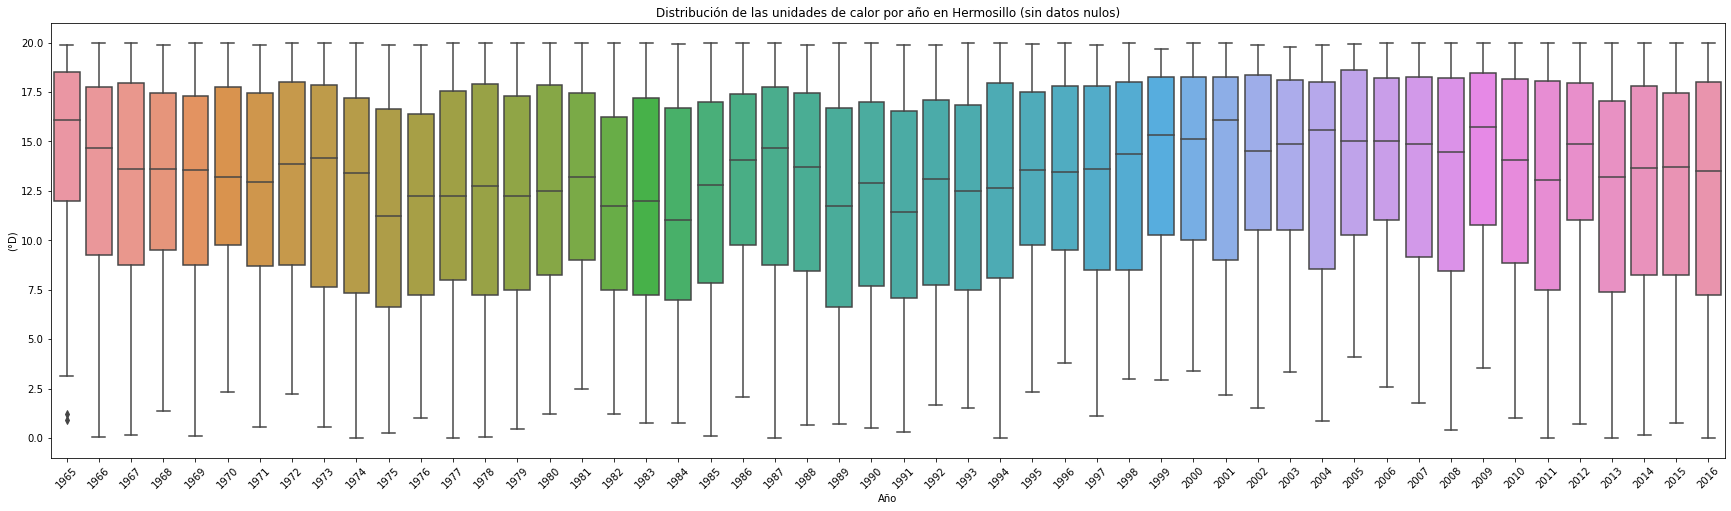

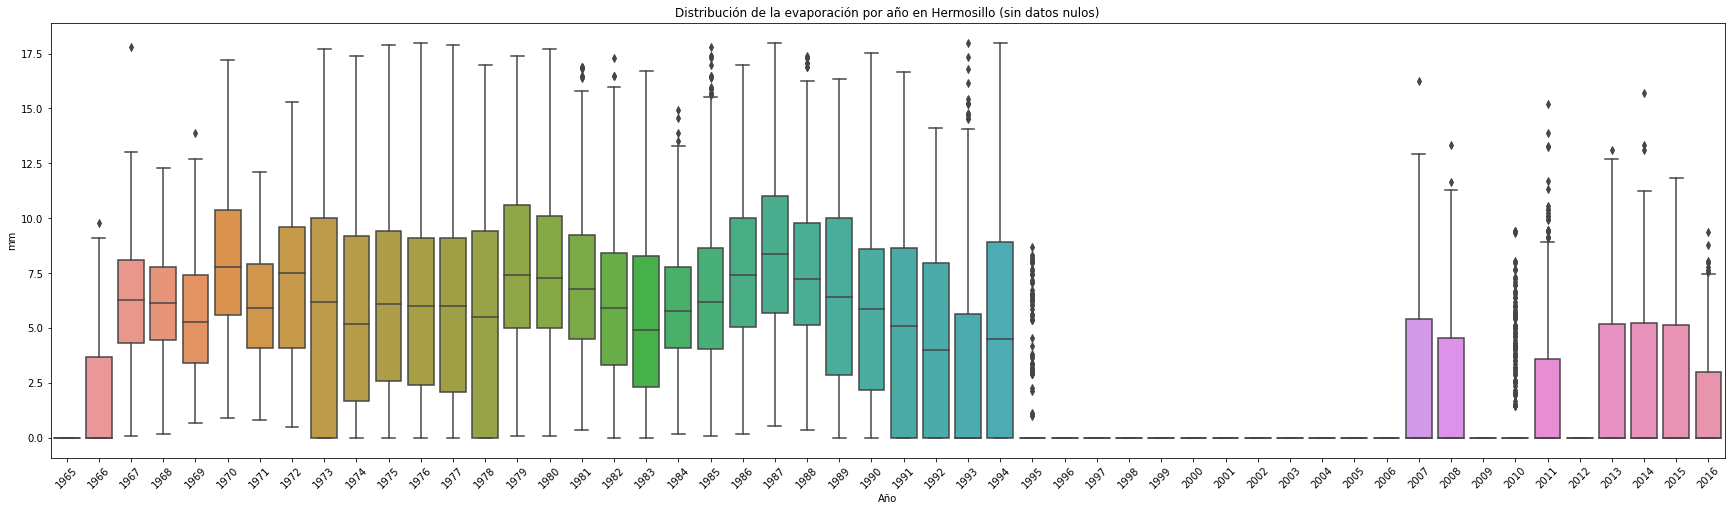

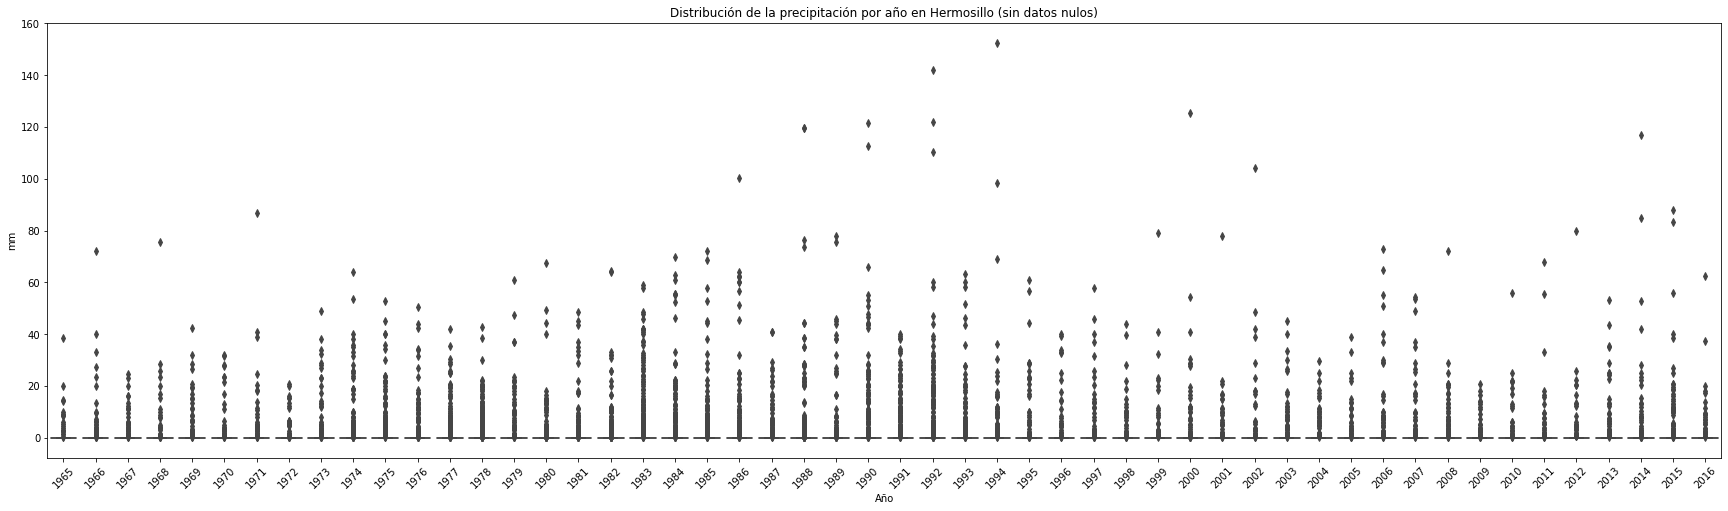

In [32]:
titulos = ['Distribución de la temperatura mínima',
           'Distribución de la temperatura máxima',
           'Distribución de las unidades de calor',
           'Distribución de la evaporación',
           'Distribución de la precipitación'
           ]
ylabels = ['(°C)','(°C)','(°D)', 'mm', 'mm']
variables = df.columns[2:7]

for i in range(5):
    distribucionPorAnio(df, variables[i], f"{titulos[i]} por año en Hermosillo (sin datos nulos)", 'Año', ylabels[i])

Podemos observar que el gran número de outliers en la variable `Precip` sigue ocurriendo.

En la variable `Tmax` podemos observar cómo en algunos años existen temperaturas máximas de 0°C, seguramente estas lecturas pertenecen a los meses de invierno combinados con algún frente frío en la región.

La temperatura promedio es bastante problemática. Recordemos que `Tprom` contaba con 71% de valores faltantes. El algoritmo de imputación de datos tomaba un mes completo para calcular alguna medida de tendencia central; sin embargo, cuando todos los días del mes contaban con valores nulos, se imputaba directamente con 0. Es probable que esta decisión esté sesgando la distribución de esta variable.

Otro punto que vale la pena resaltar es que las distribuciones de cada variable a través de los diferentes años permanece más o menos constante.

### Distribución de las variables por mes en cada año

In [33]:
def distribucionPorMes(df, variable, titulo, etiqueta_x, etiqueta_y):
    plt.figure(figsize = (30,8))
    g = sns.boxplot(x=df.Fecha.dt.year, y=variable, data=df).set(title=titulo, xlabel=etiqueta_x, ylabel=etiqueta_y)
    _ = plt.xticks(rotation=45)
    
def mapearMes(n):
    if n == 1:
        mes = 'enero'
    if n == 2:
        mes = 'febrero'
    if n == 3:
        mes = 'marzo'
    if n == 4:
        mes = 'abril'
    if n == 5:
        mes = 'mayo'
    if n == 6:
        mes = 'junio'
    if n == 7:
        mes = 'julio'
    if n == 8:
        mes = 'agosto'
    if n == 9:
        mes = 'septiembre'
    if n == 10:
        mes = 'octubre'
    if n == 11:
        mes = 'noviembre'
    if n == 12:
        mes = 'diciembre'
    return mes

dataframes_meses = {}

for i in range(1,13):
    dataframes_meses[mapearMes(i)] = df[df.Fecha.dt.month == i]

#### Enero

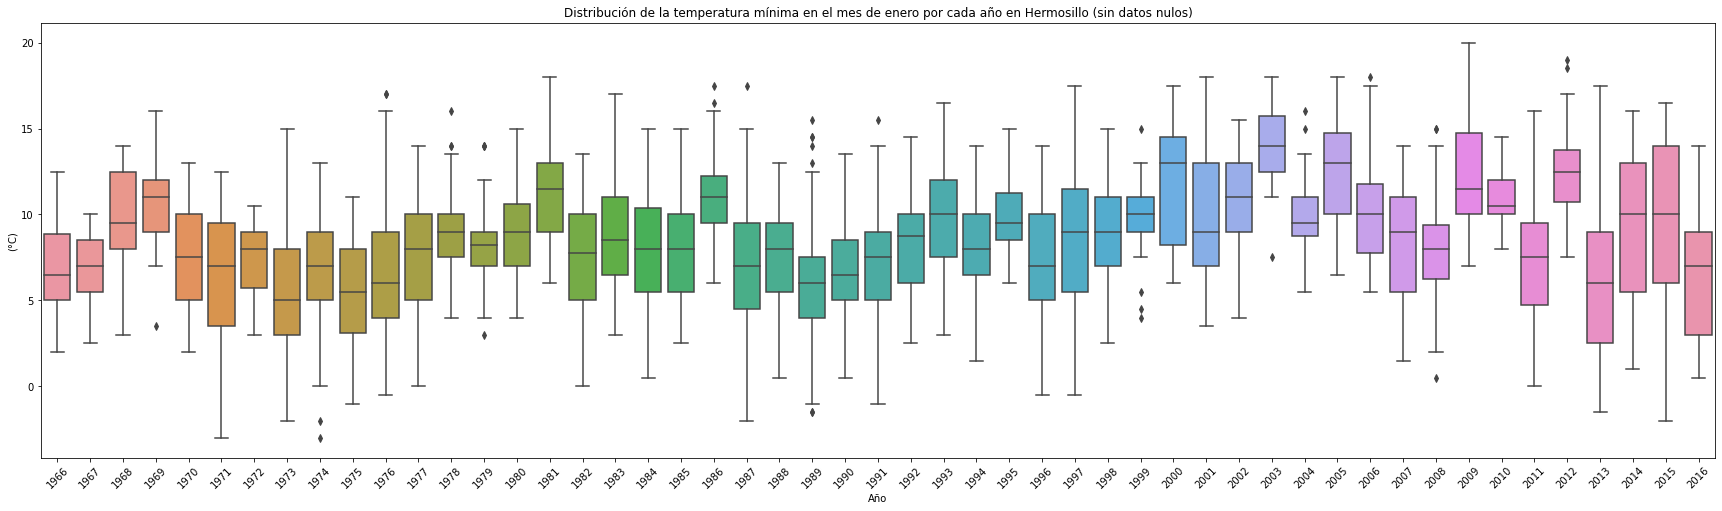

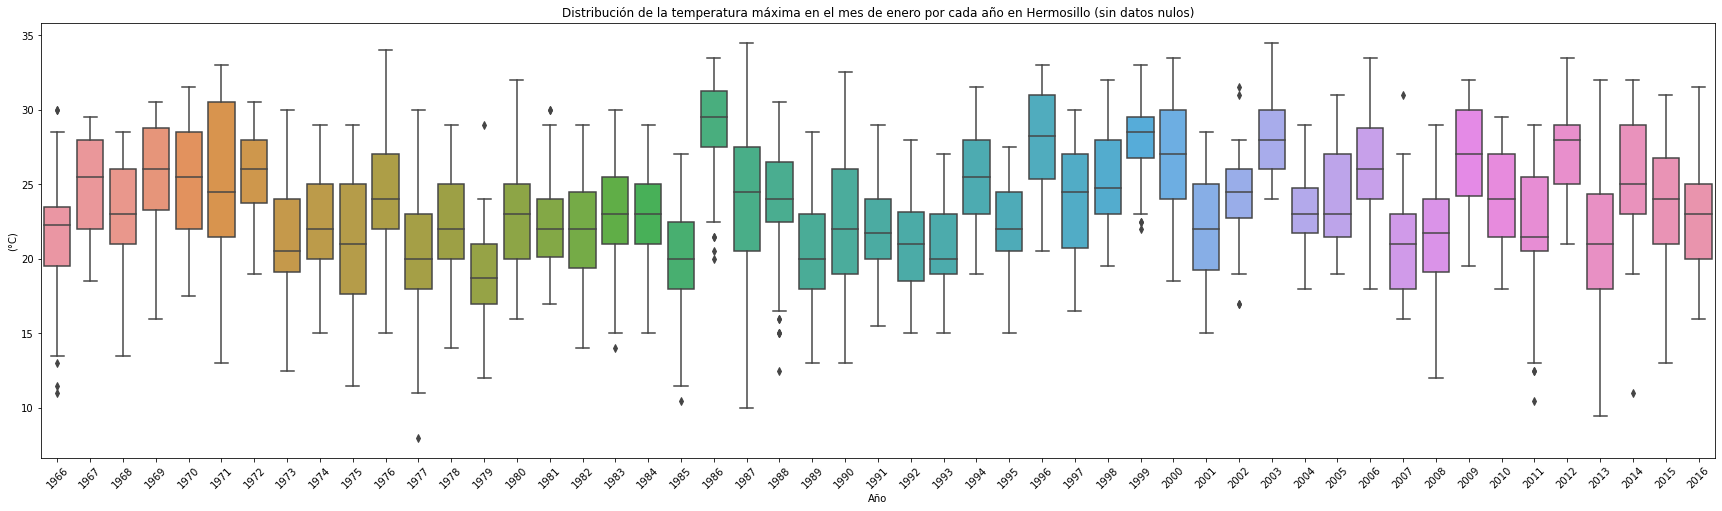

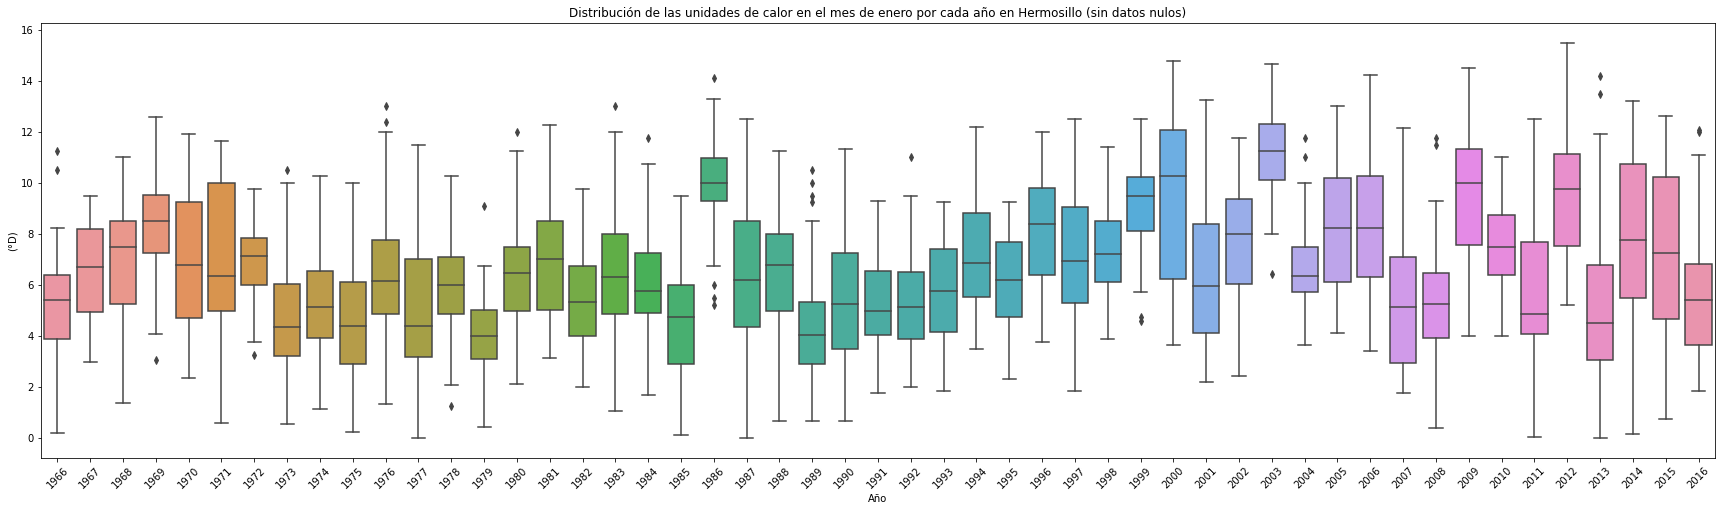

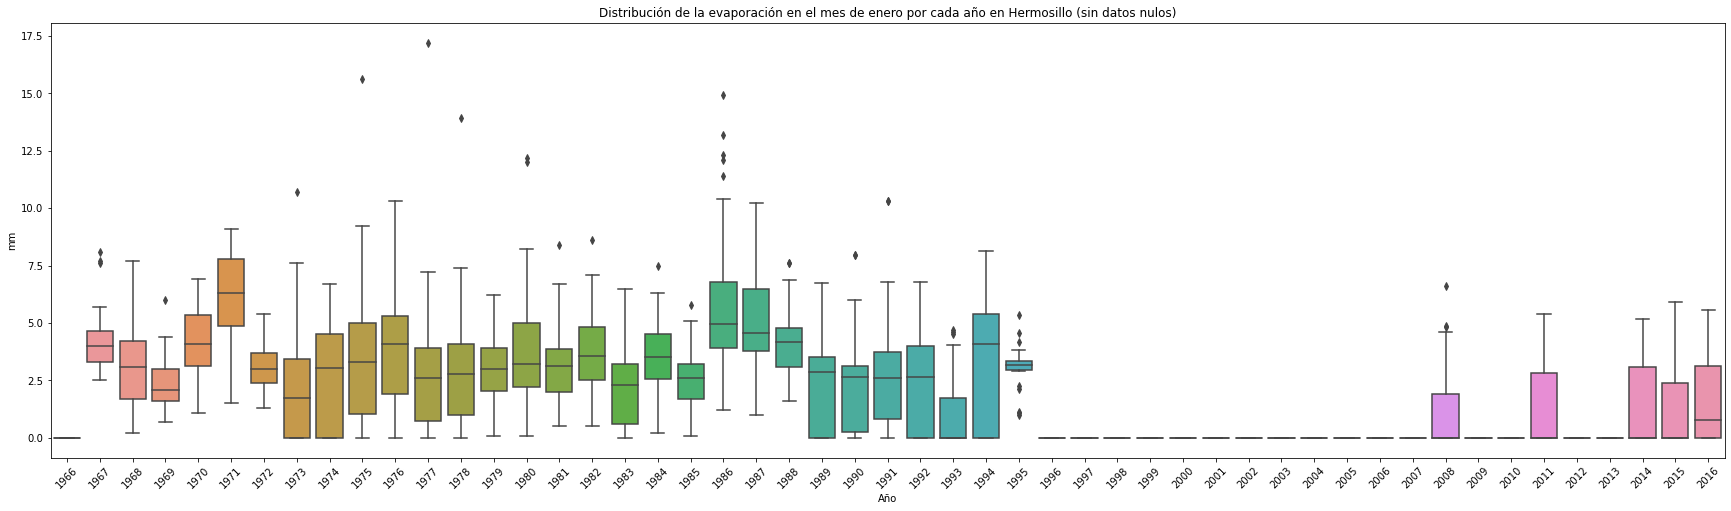

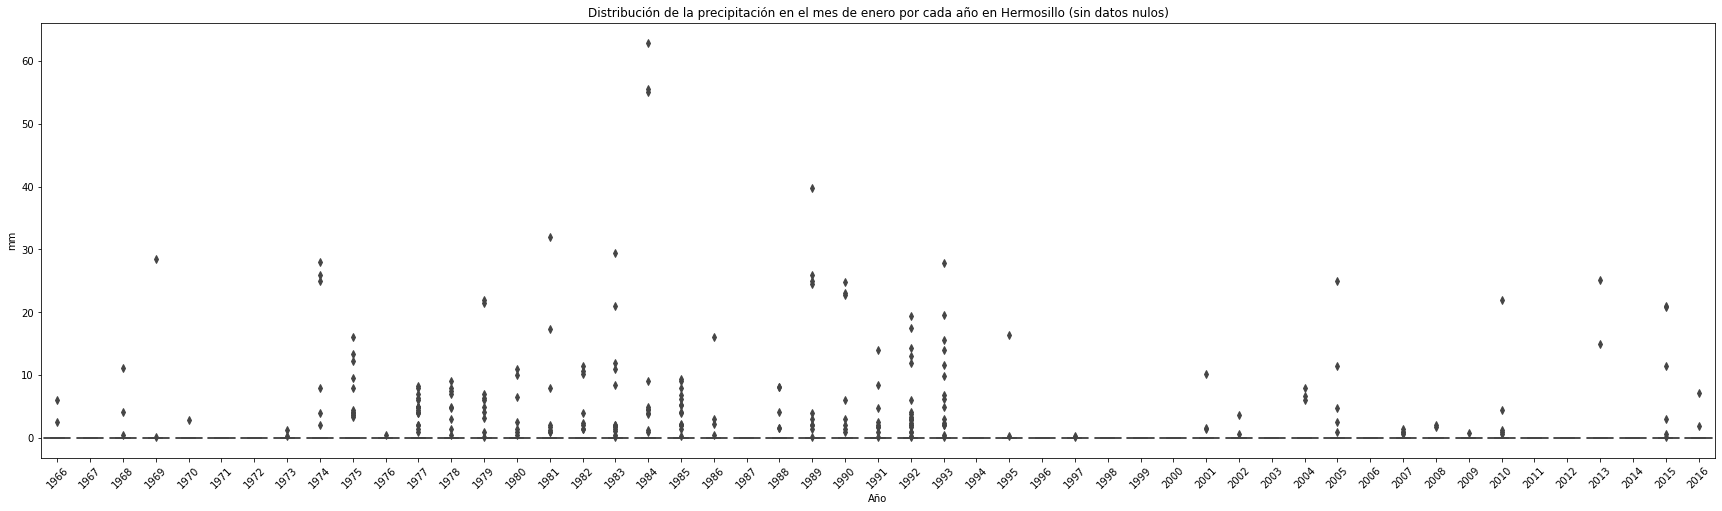

In [34]:
mes = 'enero'
for i in range(5):
    distribucionPorMes(dataframes_meses[mes], variables[i], f"{titulos[i]} en el mes de {mes} por cada año en Hermosillo (sin datos nulos)", 'Año', ylabels[i])

#### Febrero

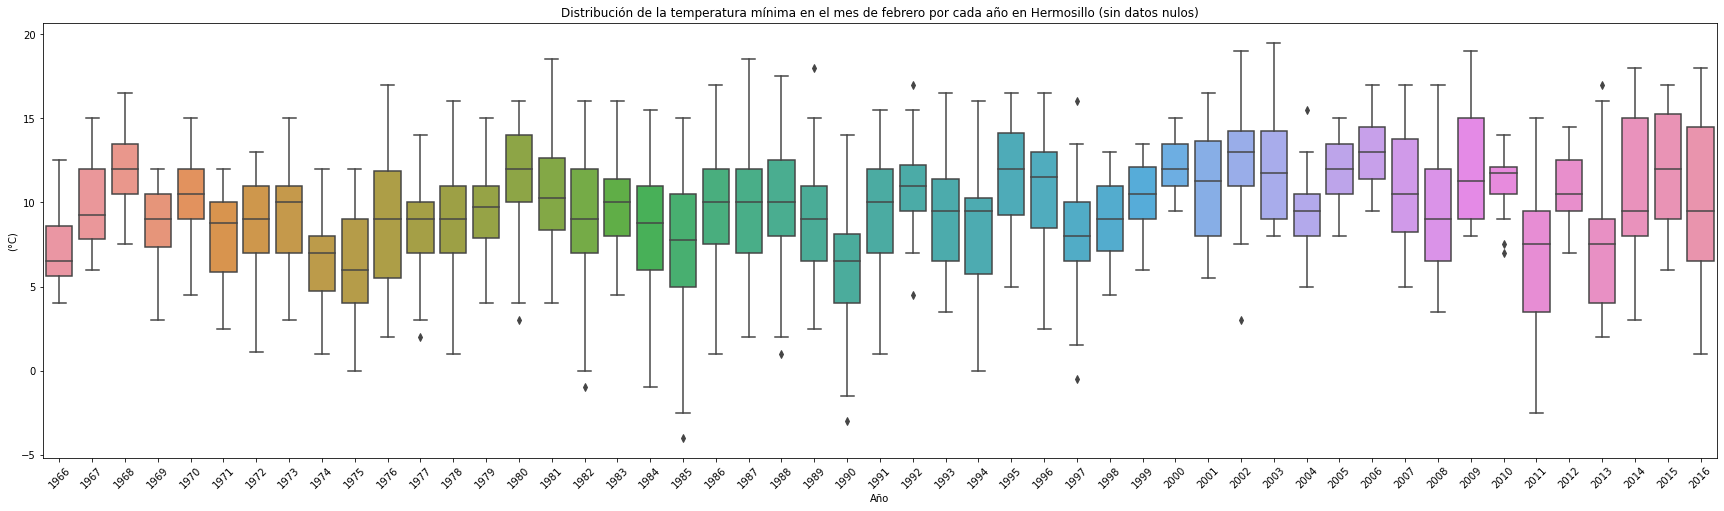

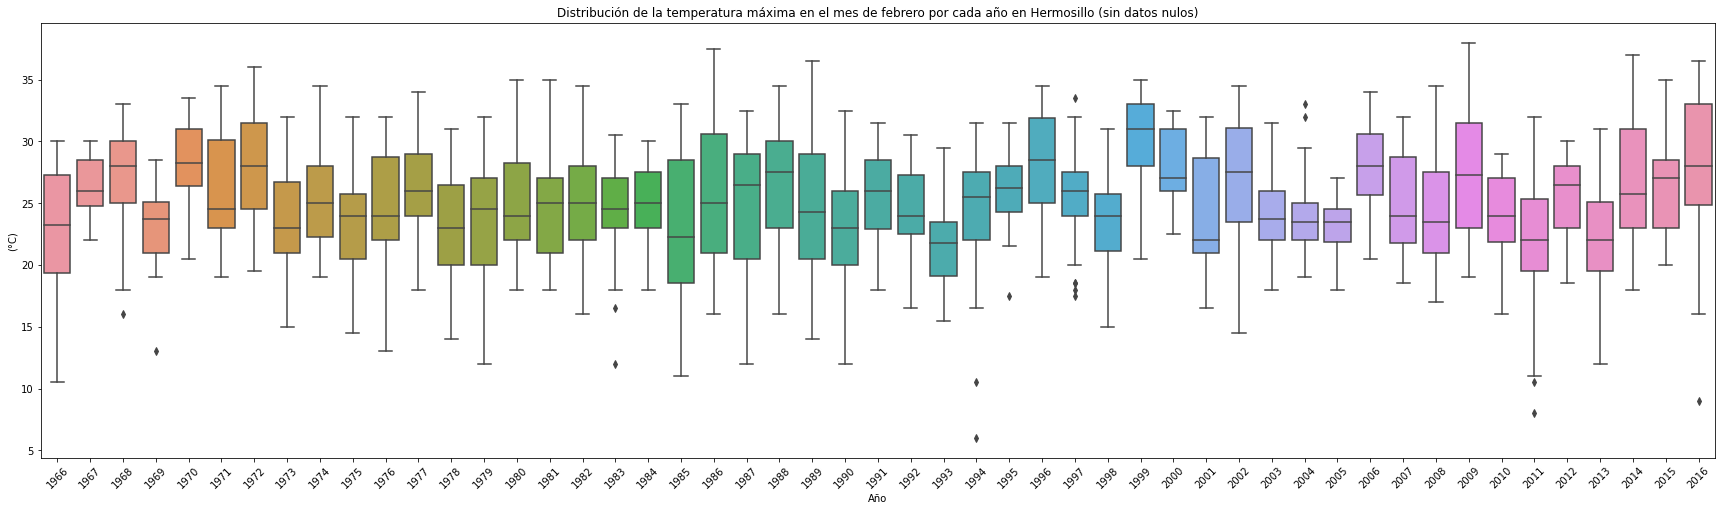

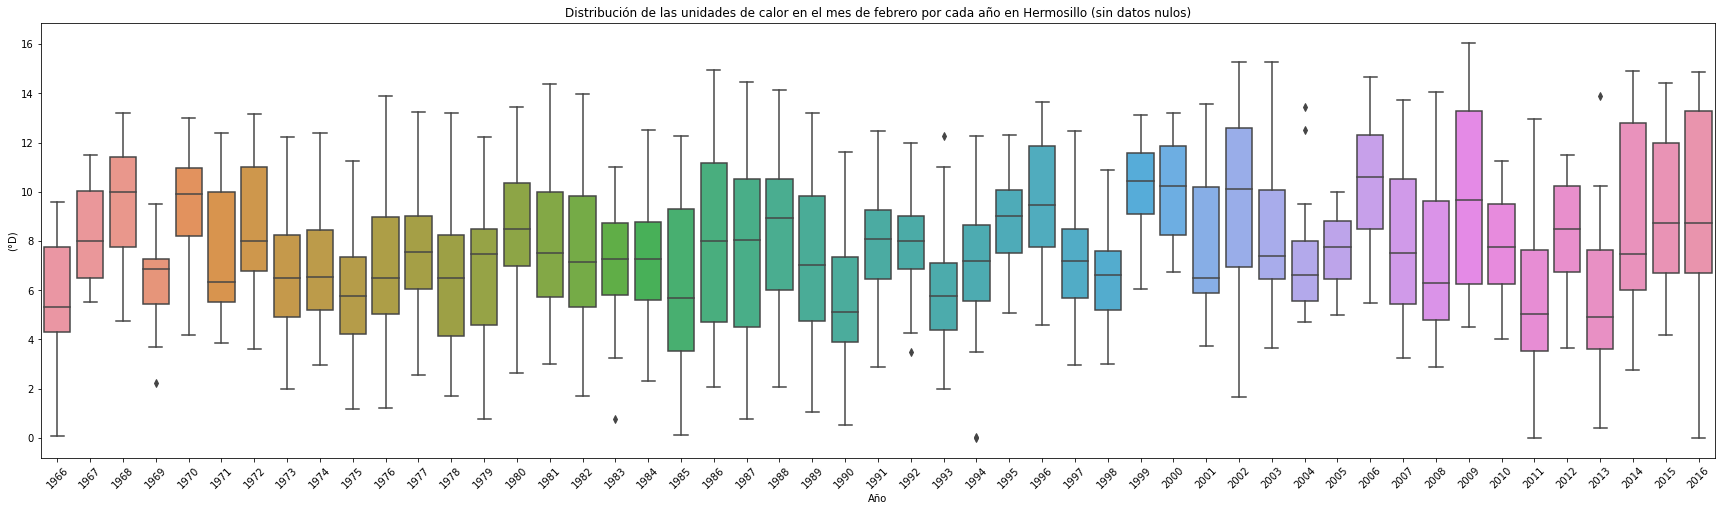

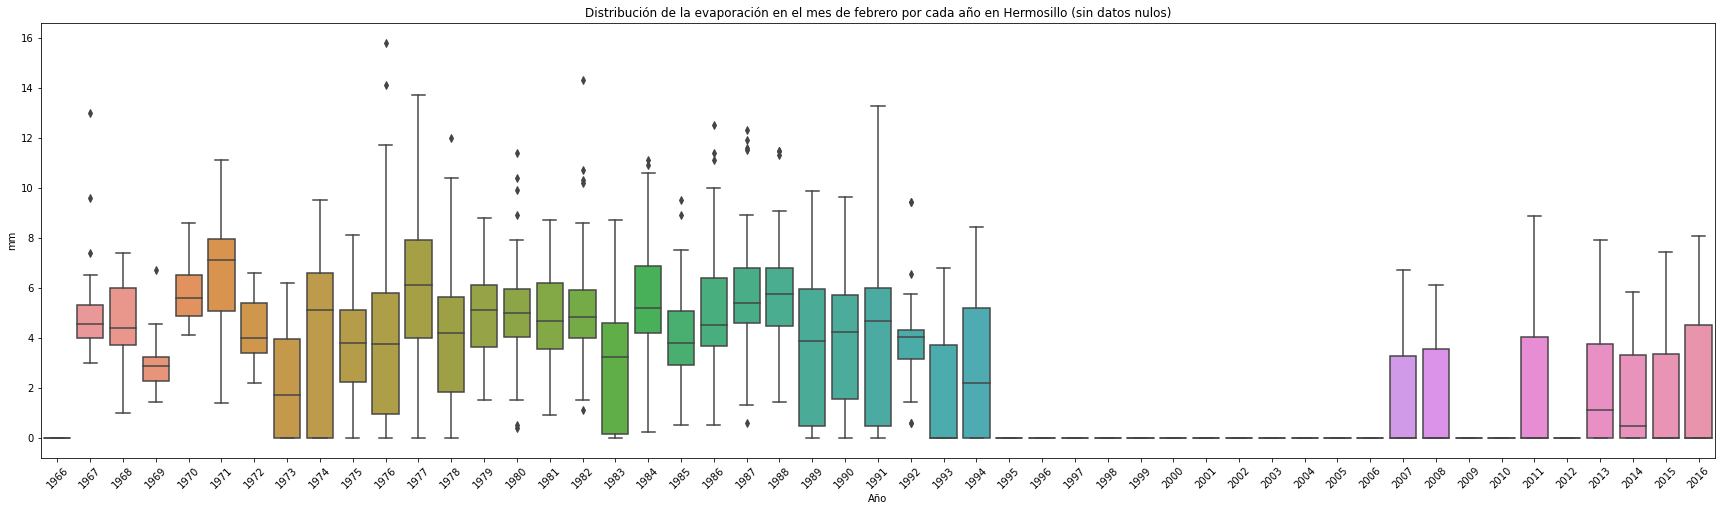

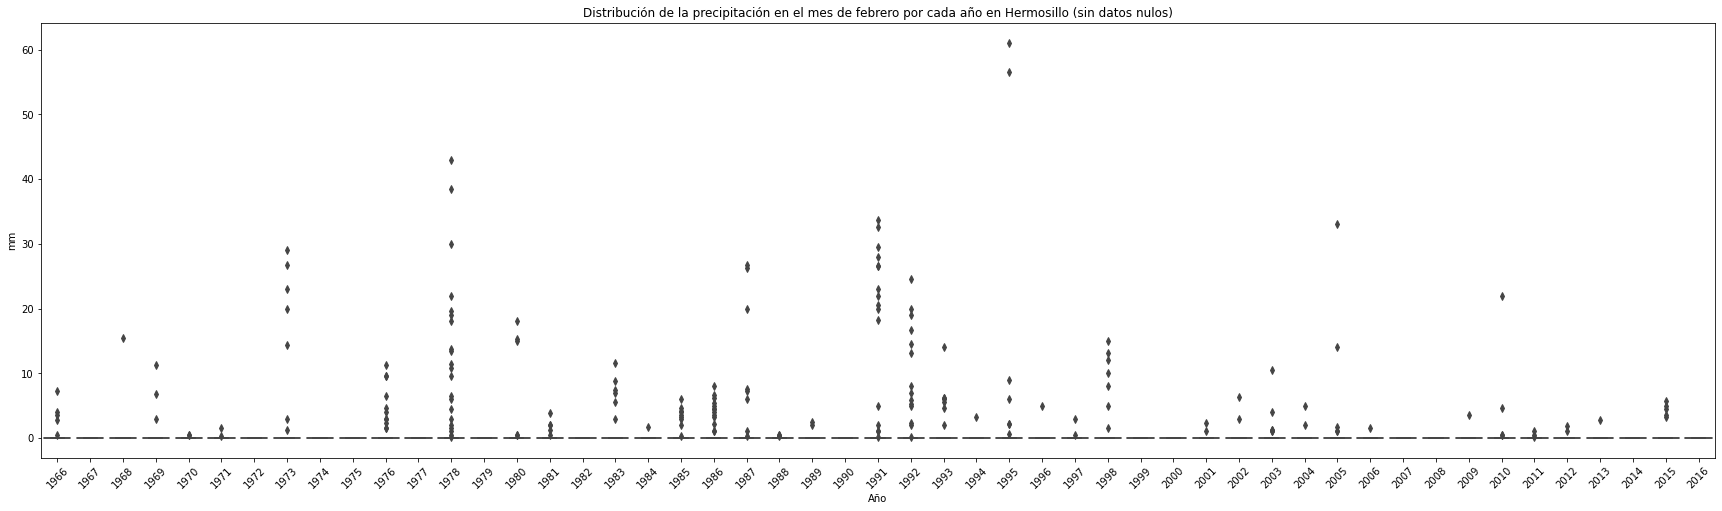

In [35]:
mes = 'febrero'
for i in range(5):
    distribucionPorMes(dataframes_meses[mes], variables[i], f"{titulos[i]} en el mes de {mes} por cada año en Hermosillo (sin datos nulos)", 'Año', ylabels[i])

#### Marzo

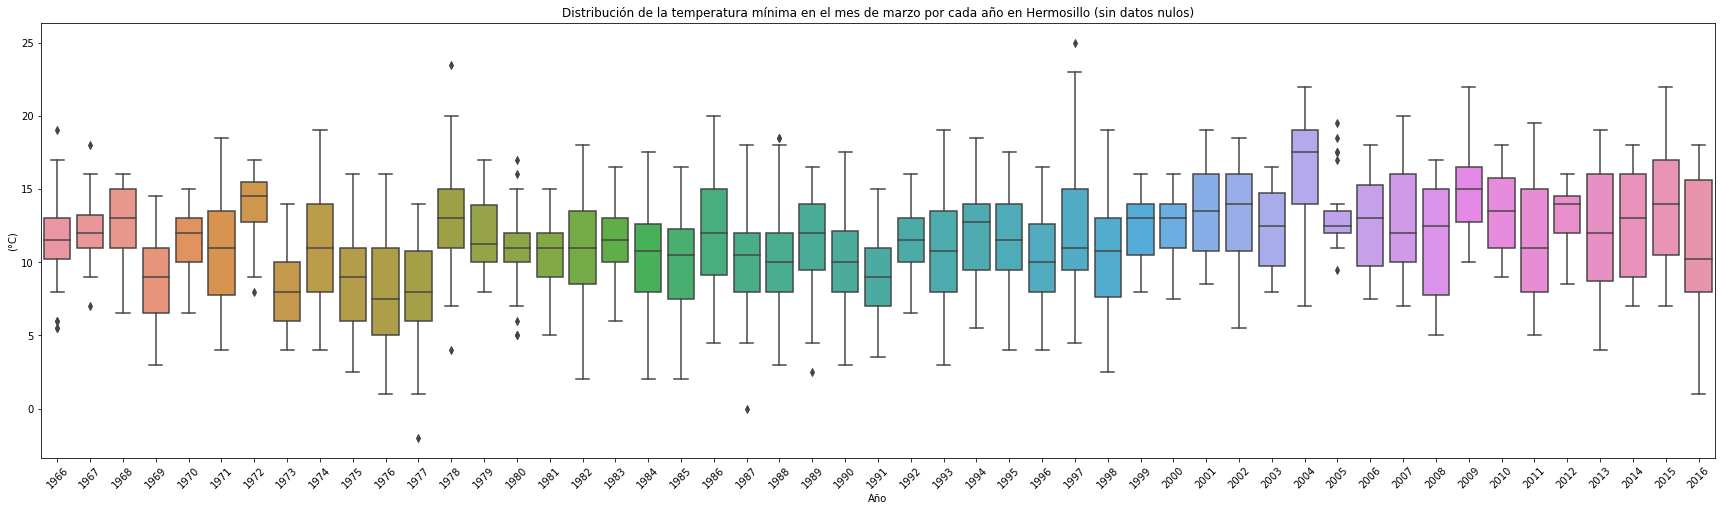

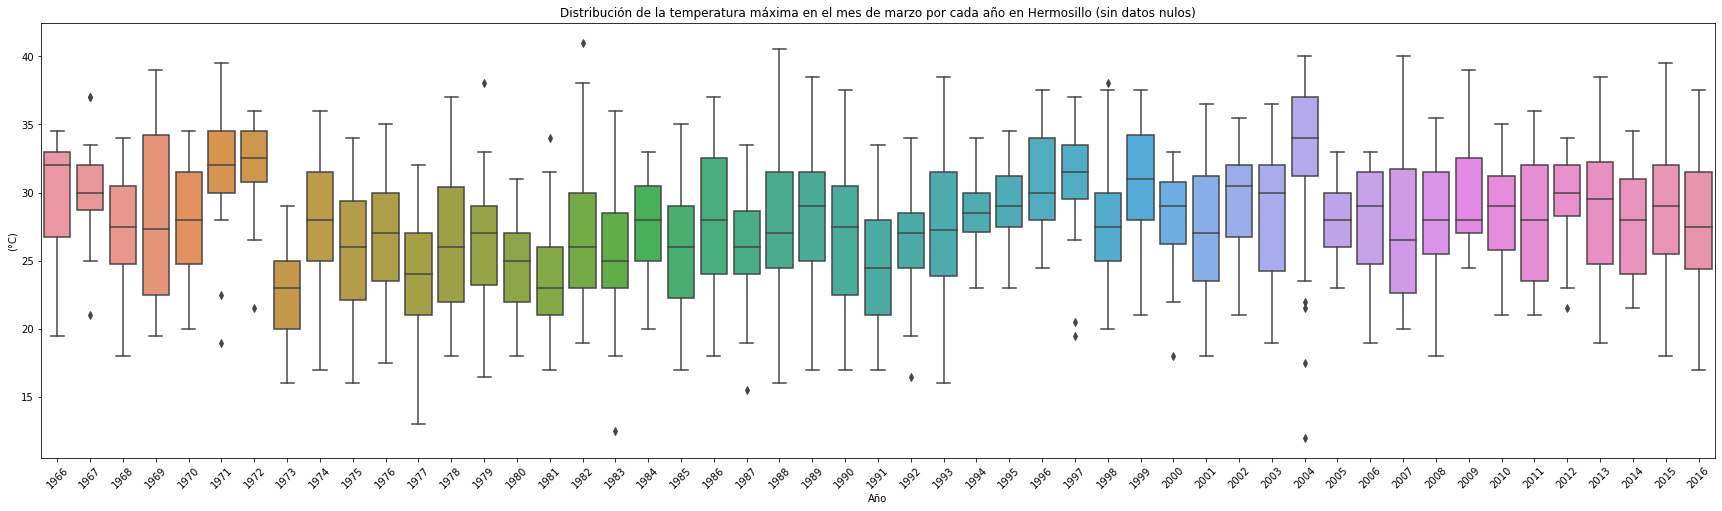

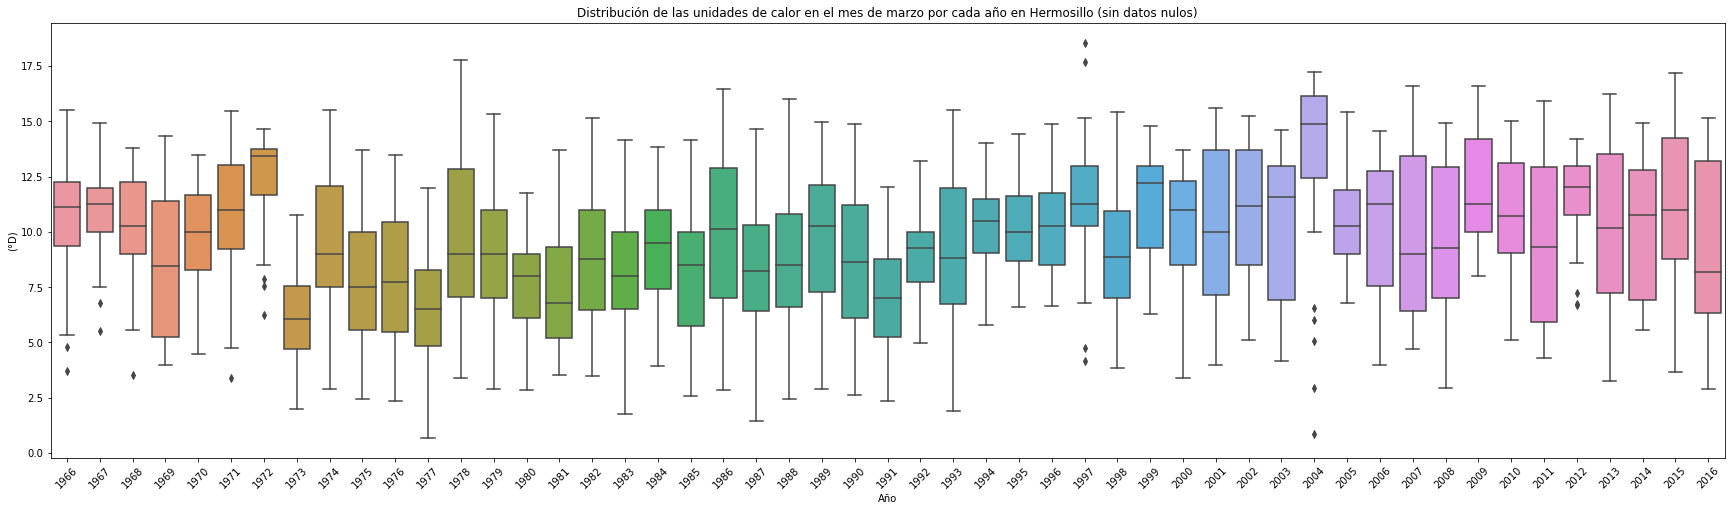

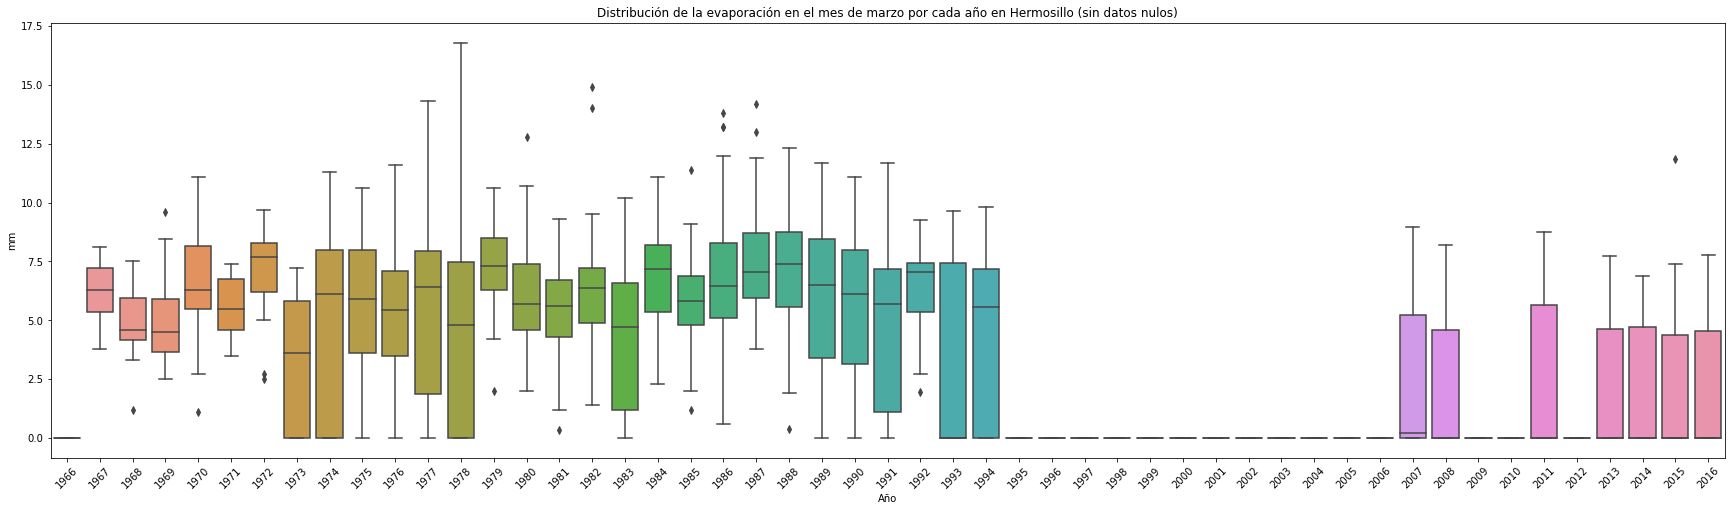

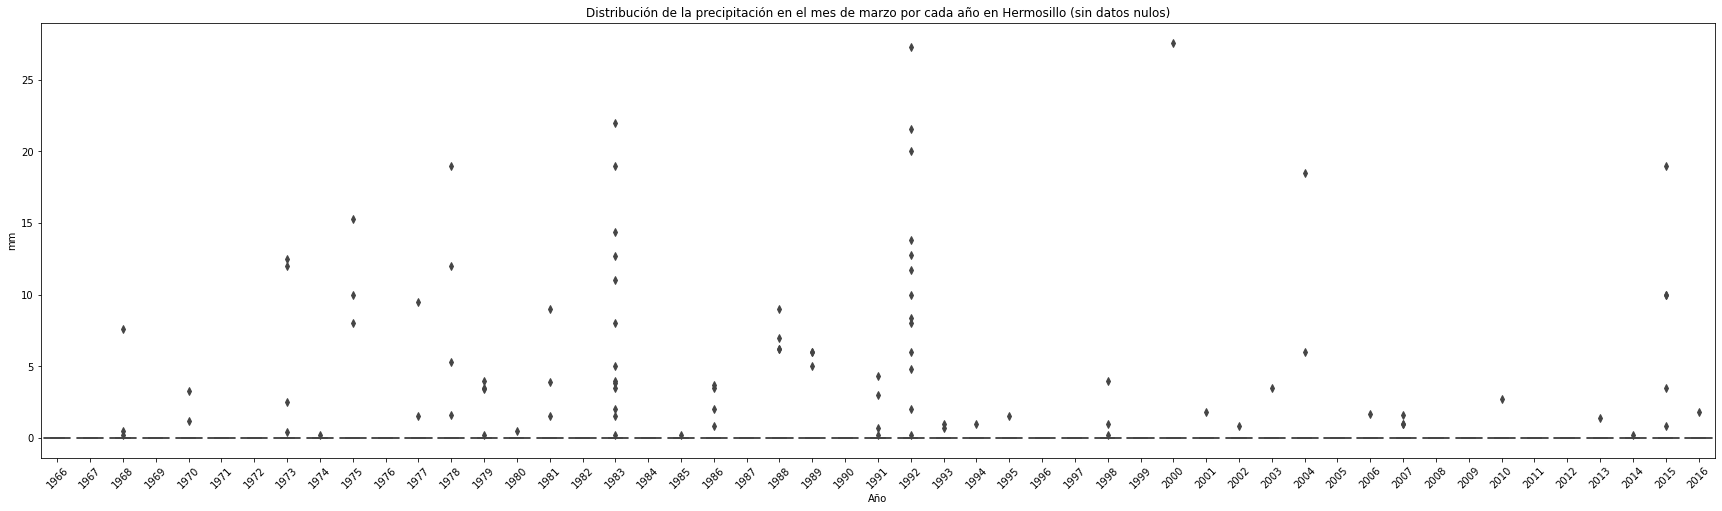

In [36]:
mes = 'marzo'
for i in range(5):
    distribucionPorMes(dataframes_meses[mes], variables[i], f"{titulos[i]} en el mes de {mes} por cada año en Hermosillo (sin datos nulos)", 'Año', ylabels[i])

#### Abril

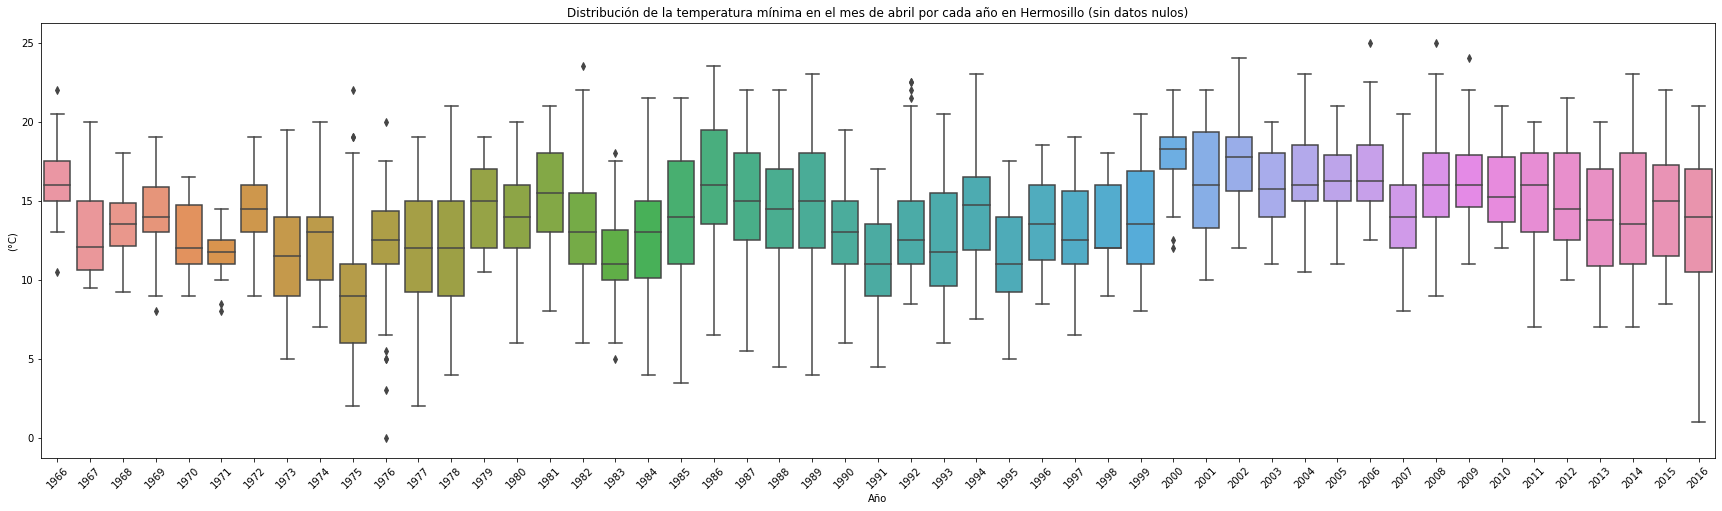

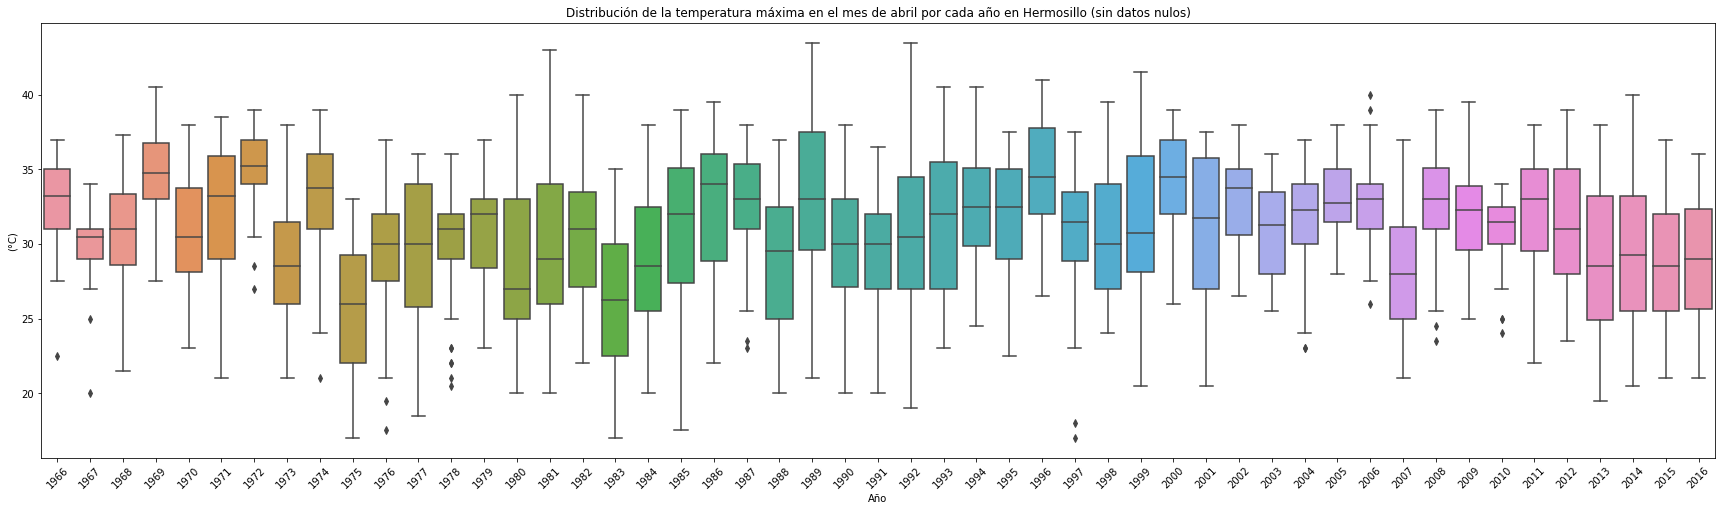

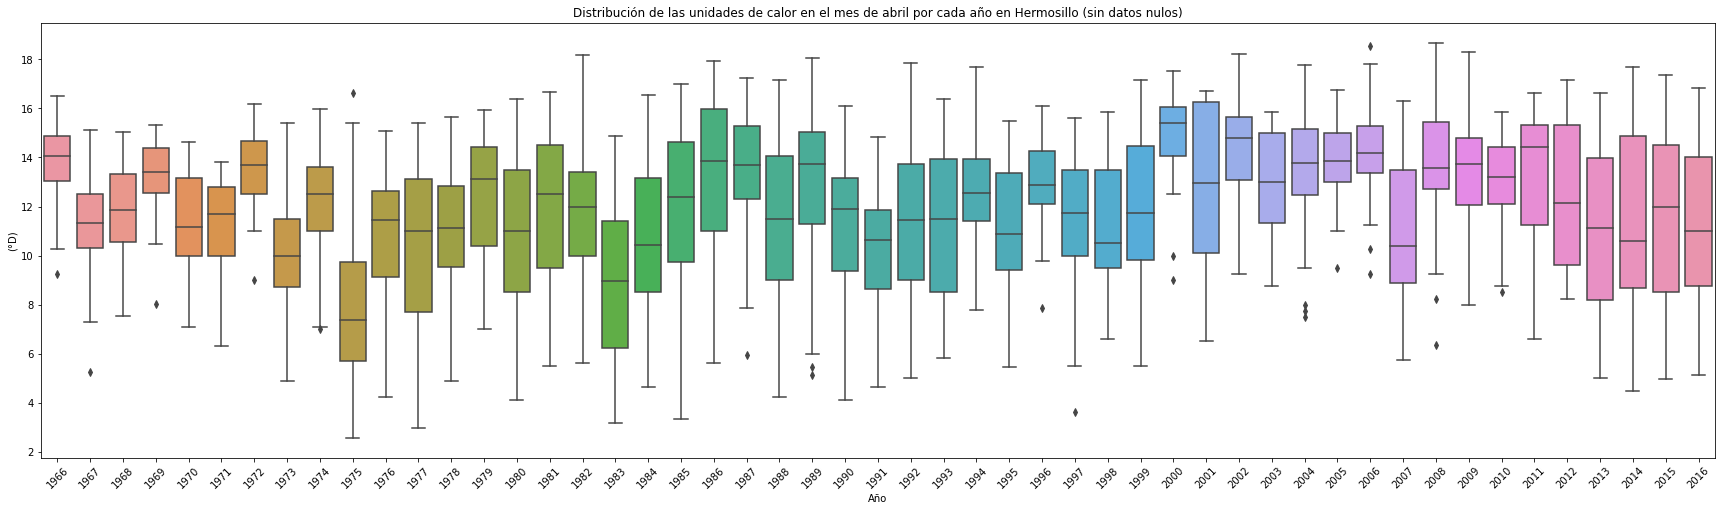

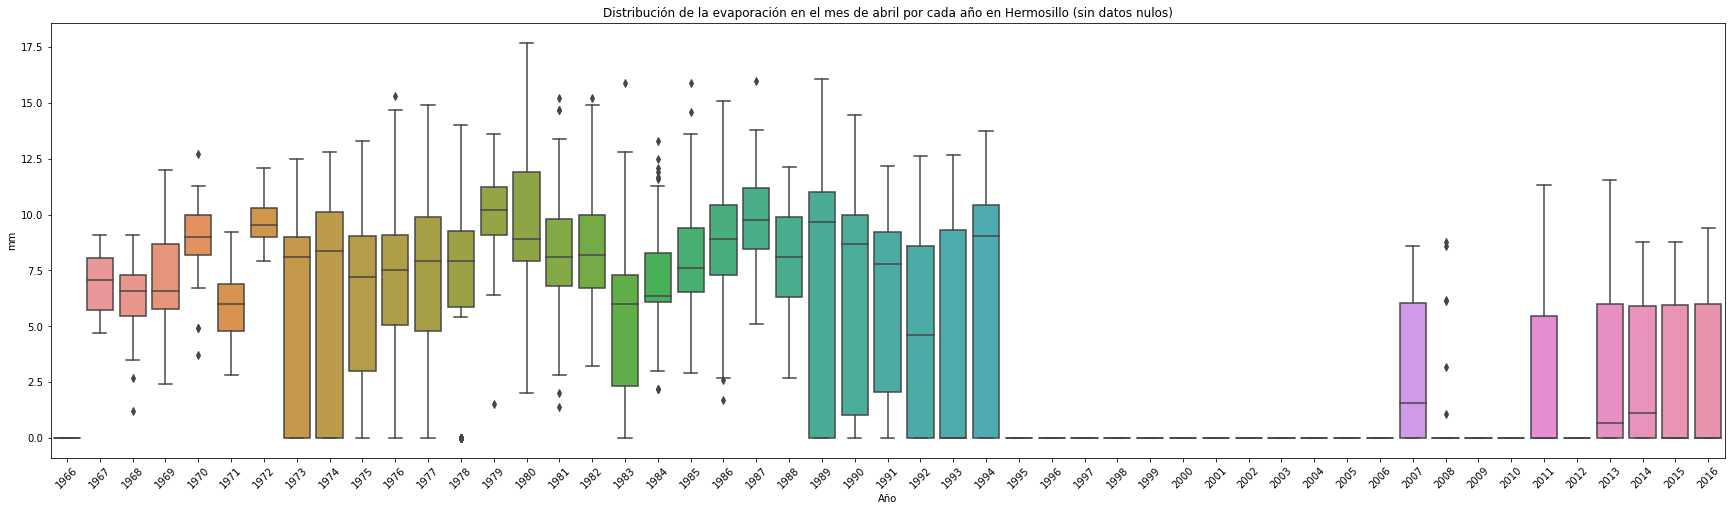

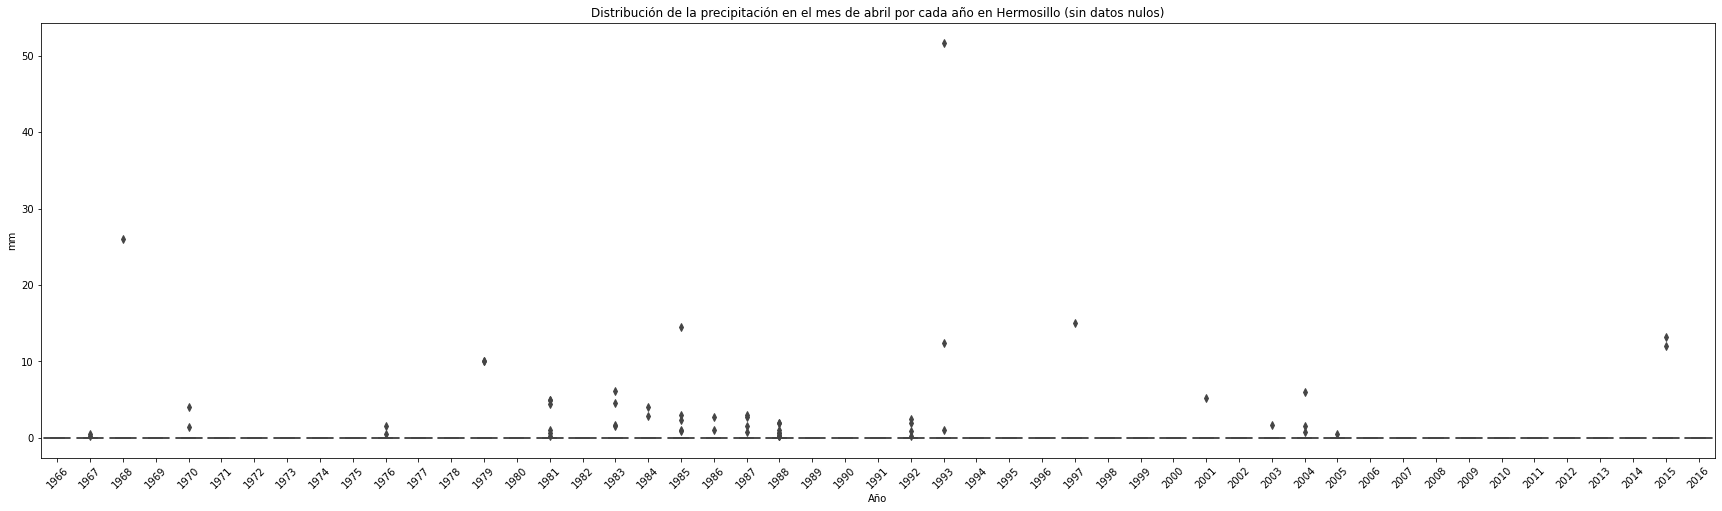

In [37]:
mes = 'abril'
for i in range(5):
    distribucionPorMes(dataframes_meses[mes], variables[i], f"{titulos[i]} en el mes de {mes} por cada año en Hermosillo (sin datos nulos)", 'Año', ylabels[i])

#### Mayo

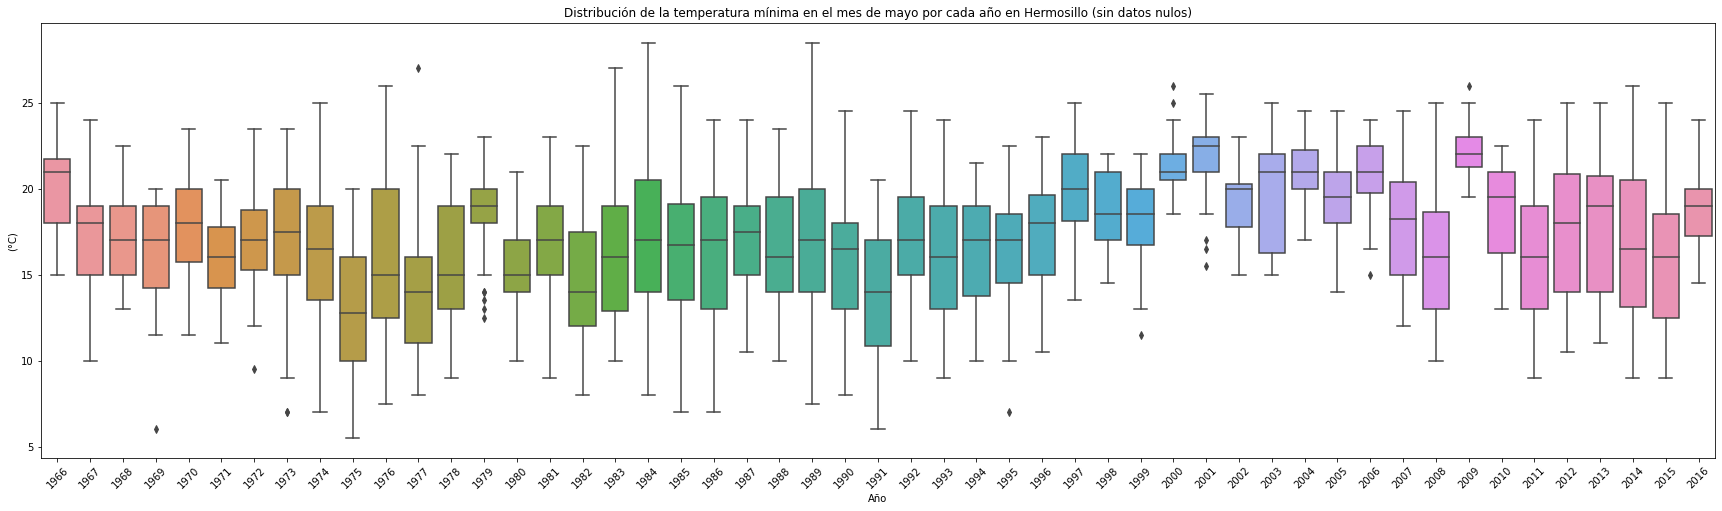

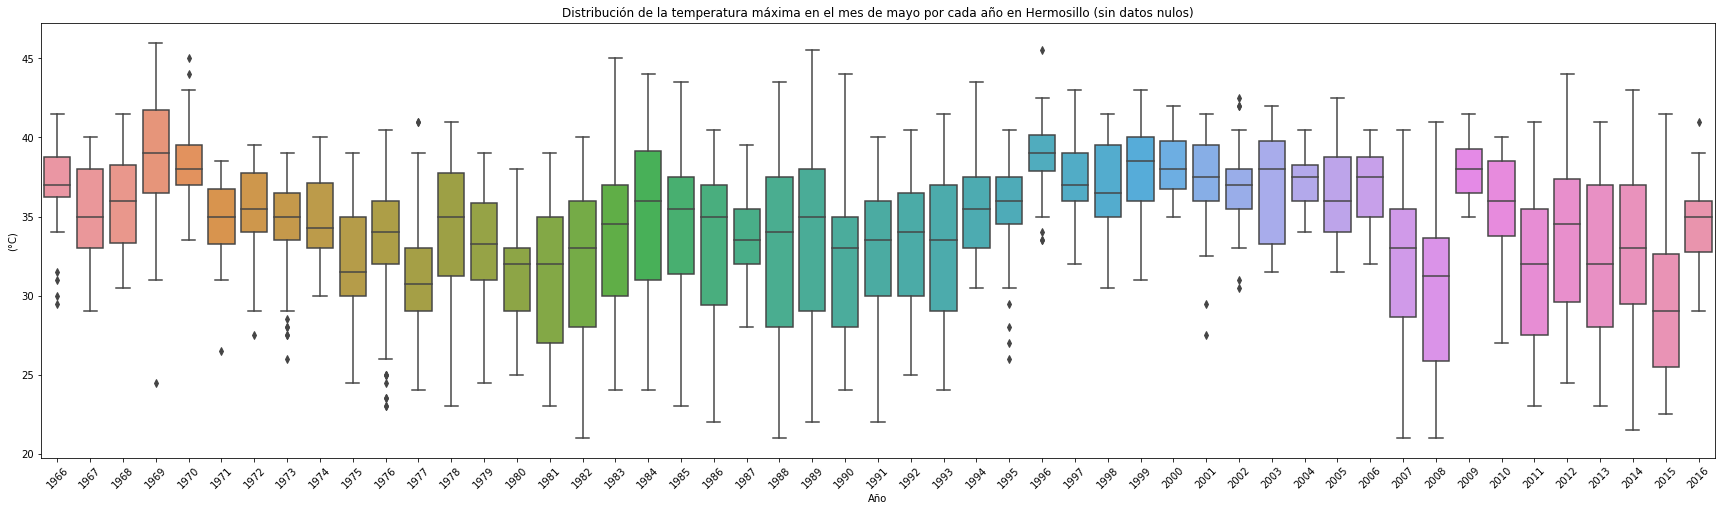

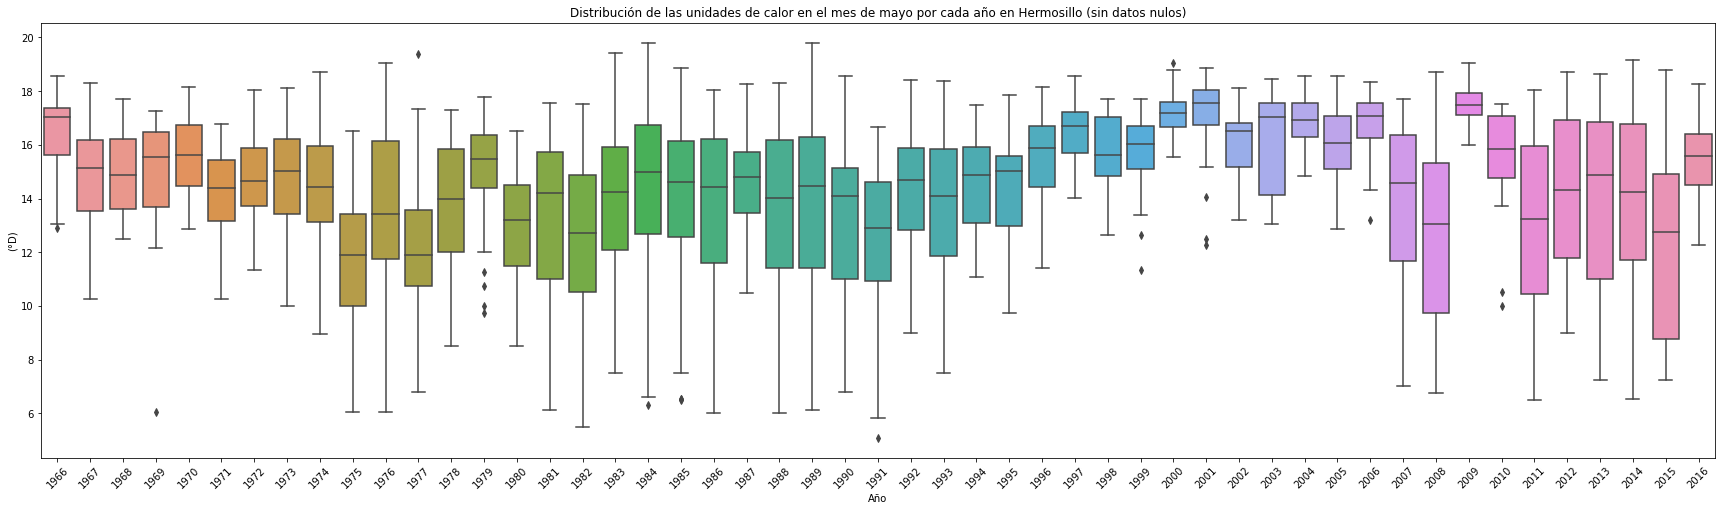

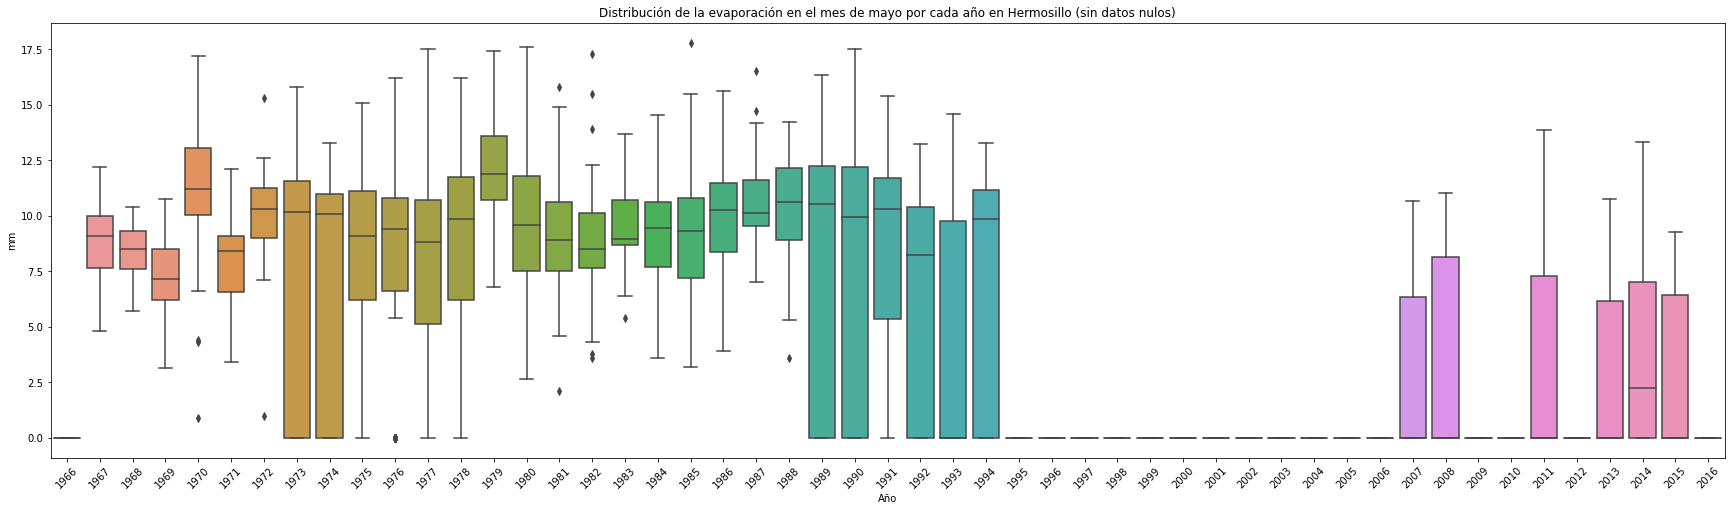

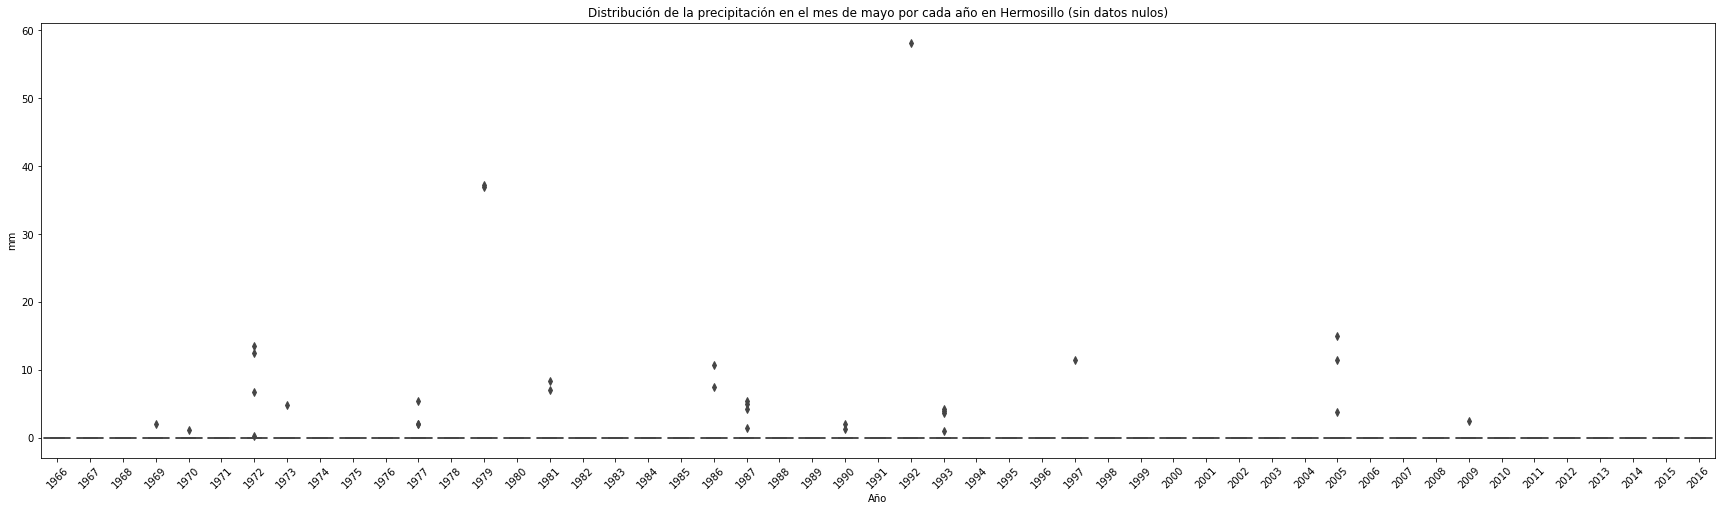

In [38]:
mes = 'mayo'
for i in range(5):
    distribucionPorMes(dataframes_meses[mes], variables[i], f"{titulos[i]} en el mes de {mes} por cada año en Hermosillo (sin datos nulos)", 'Año', ylabels[i])

#### Junio

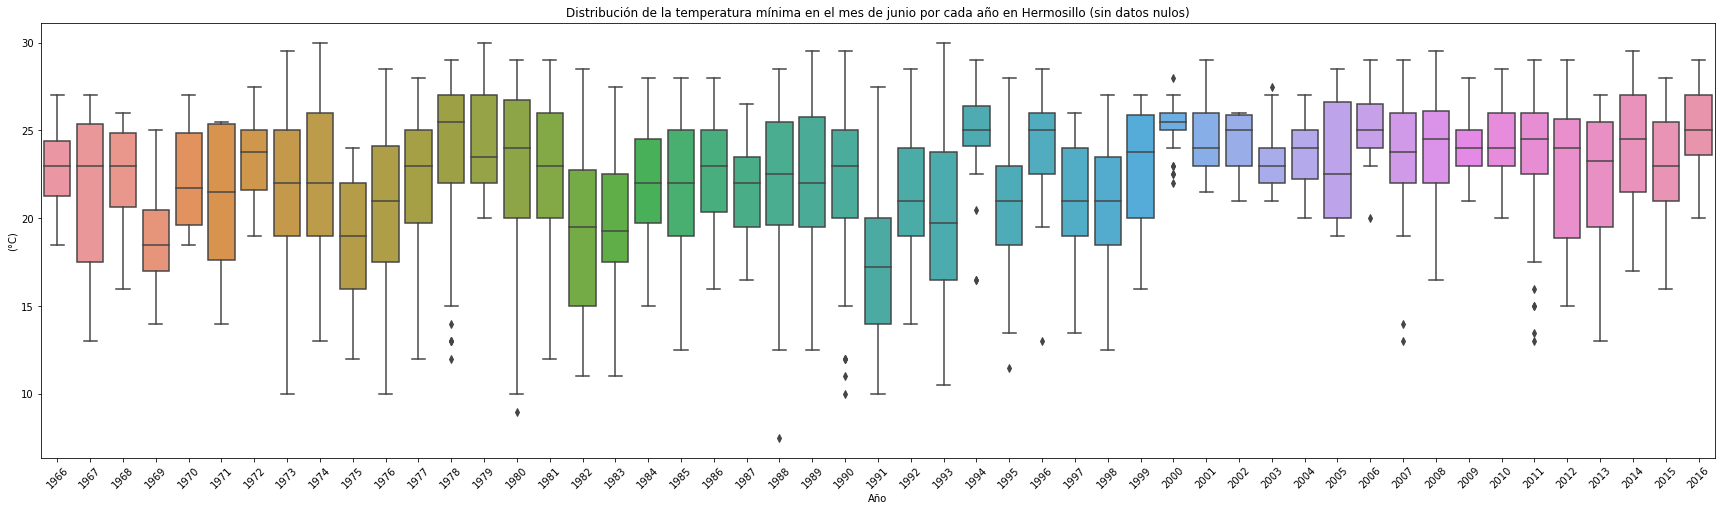

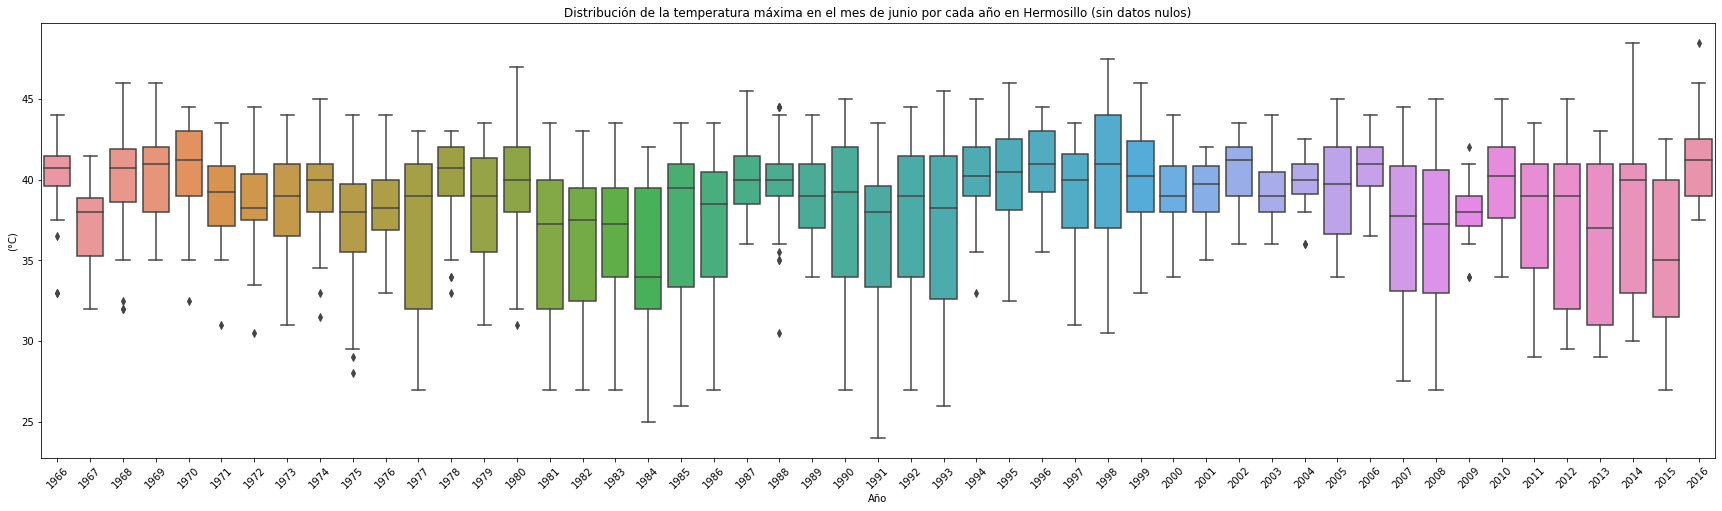

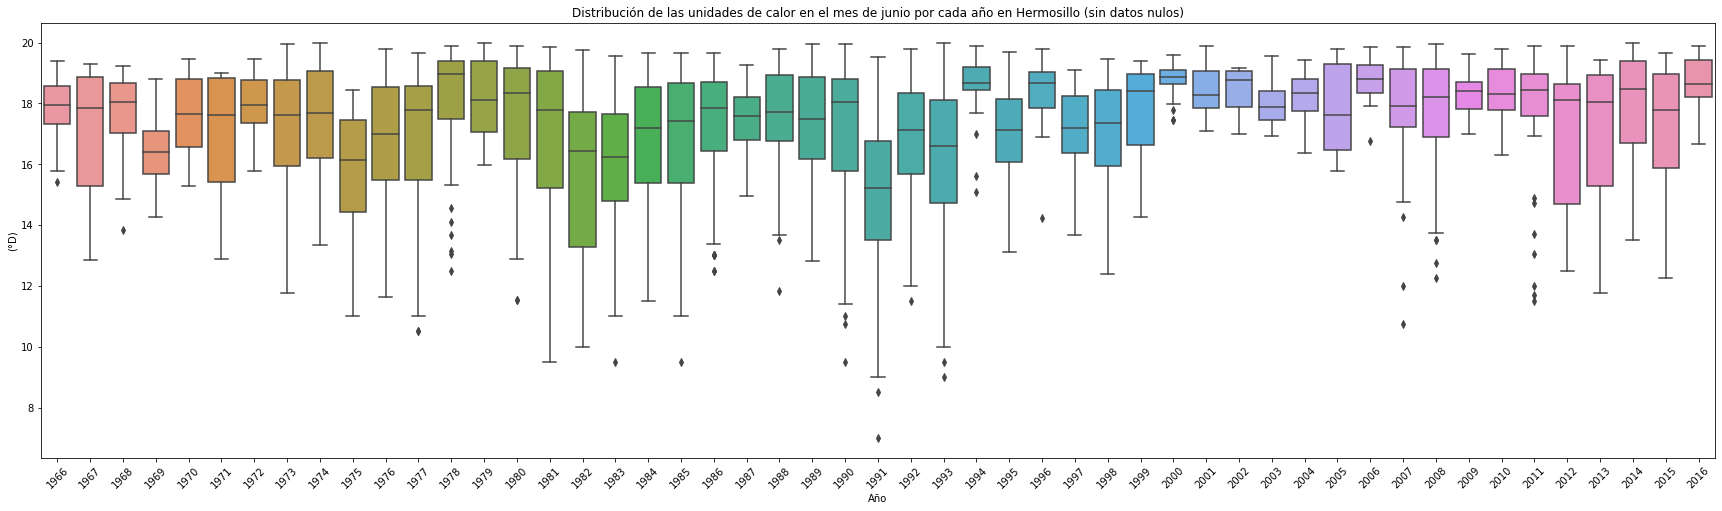

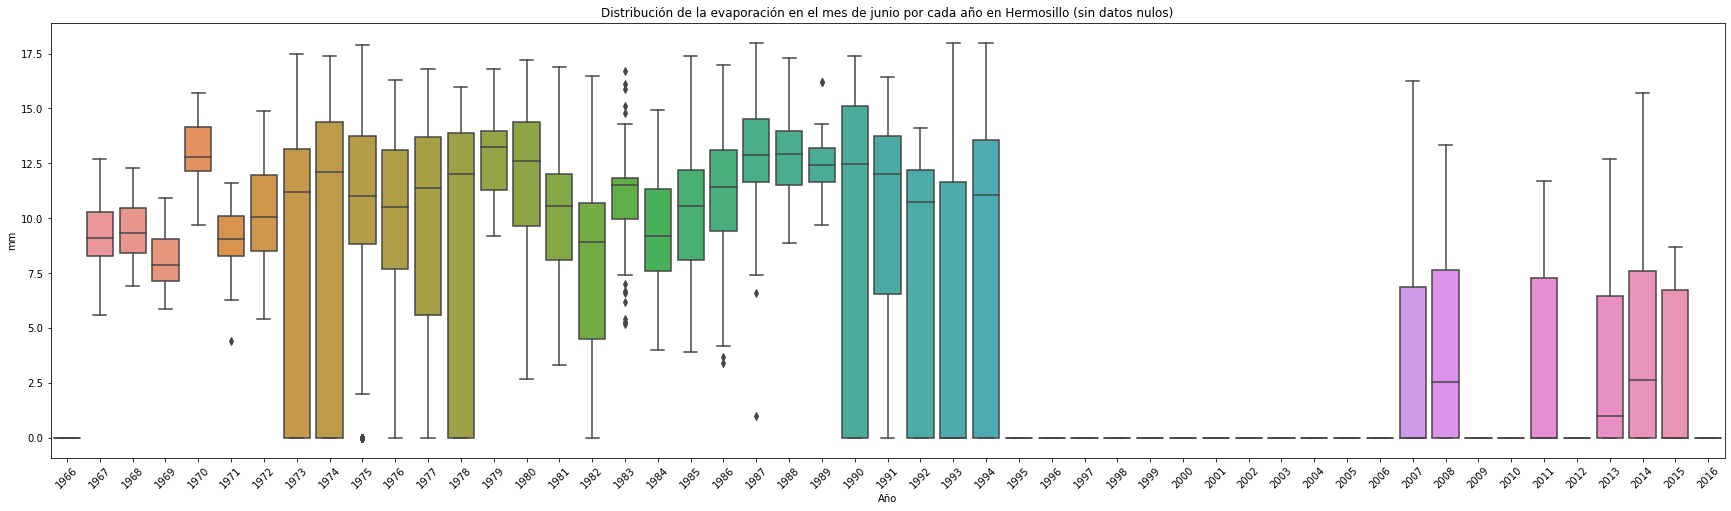

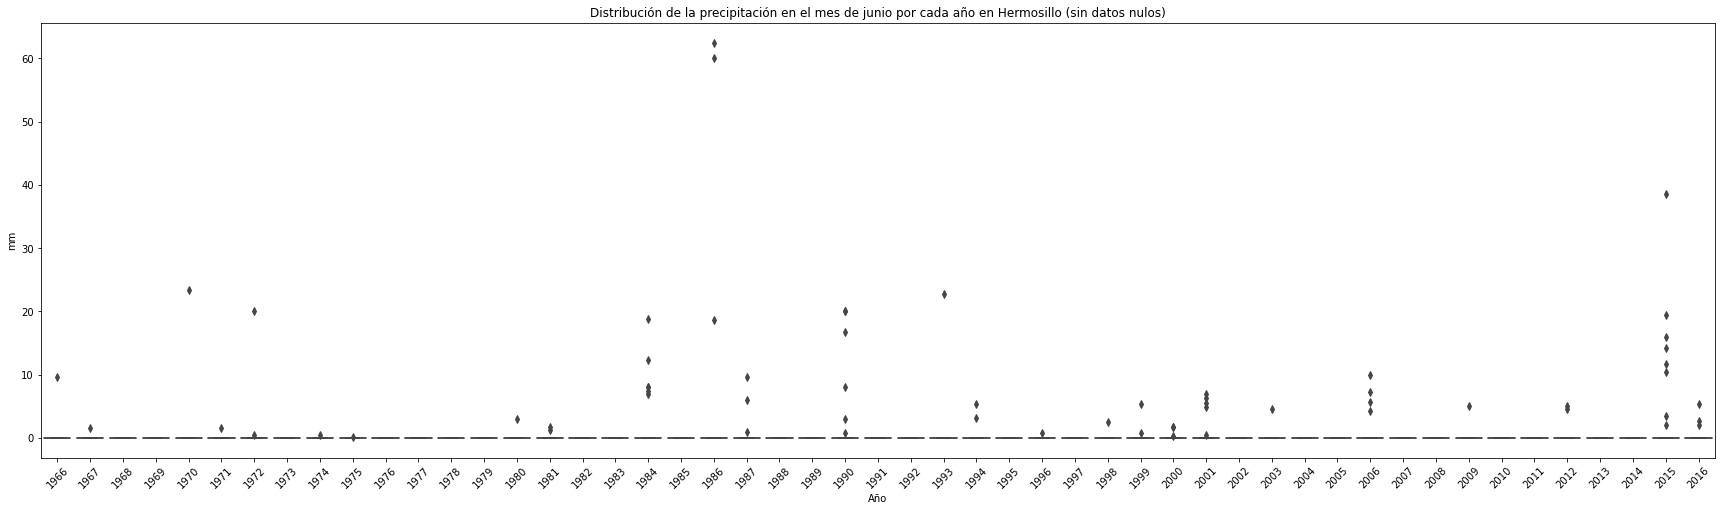

In [39]:
mes = 'junio'
for i in range(5):
    distribucionPorMes(dataframes_meses[mes], variables[i], f"{titulos[i]} en el mes de {mes} por cada año en Hermosillo (sin datos nulos)", 'Año', ylabels[i])

#### Julio

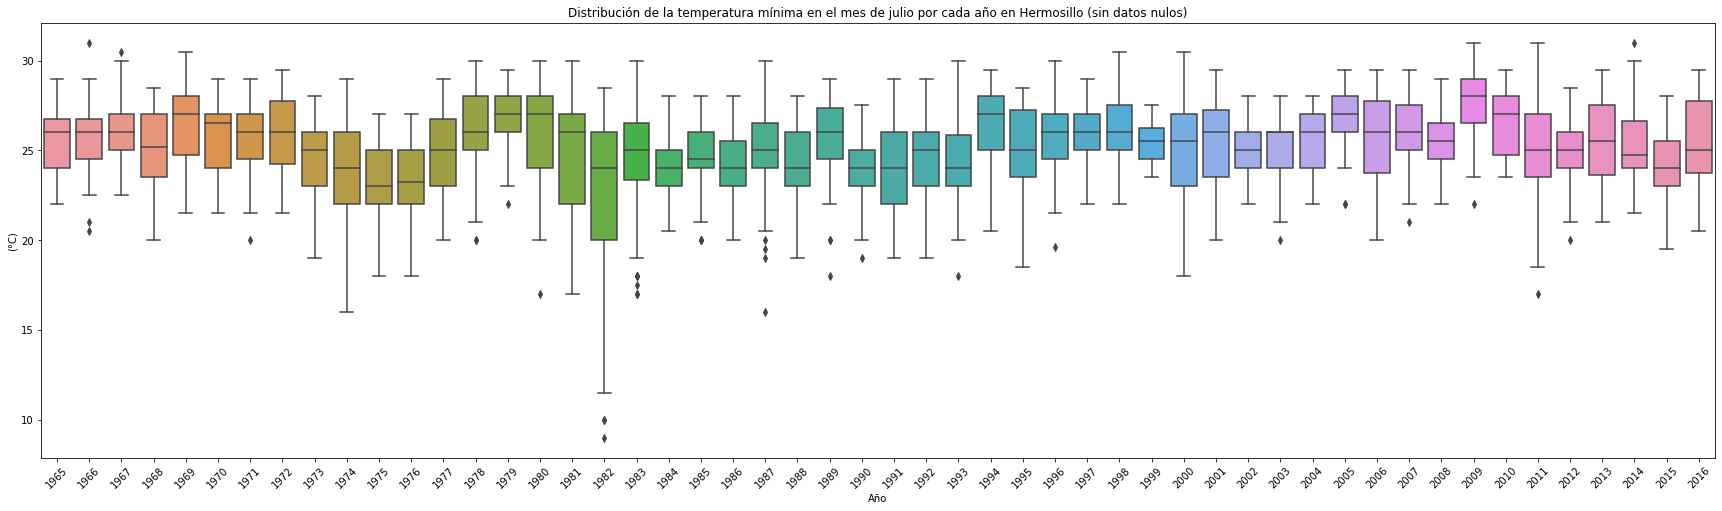

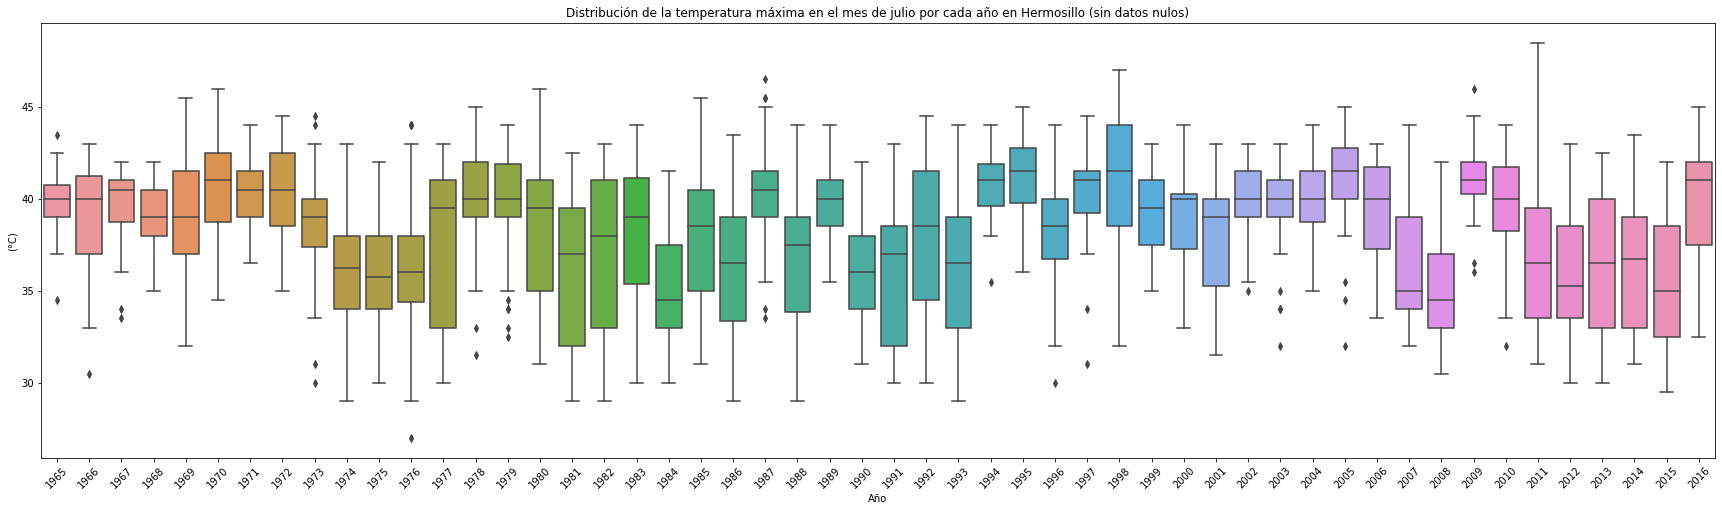

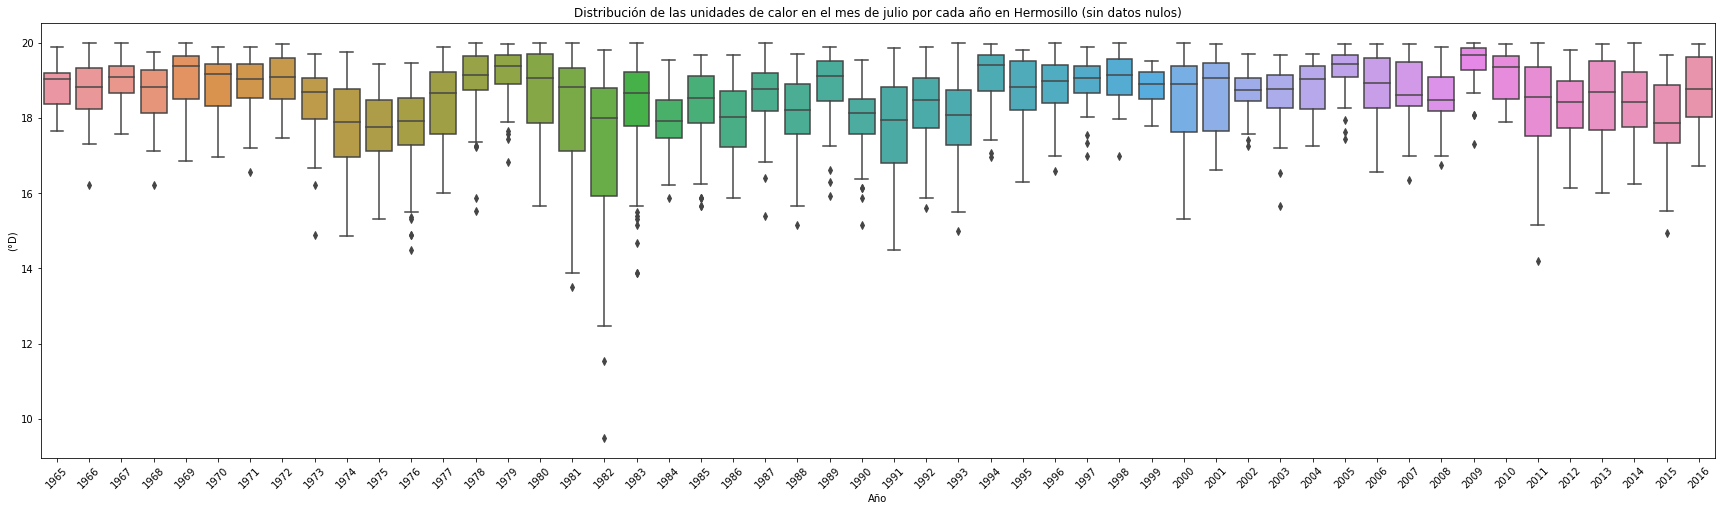

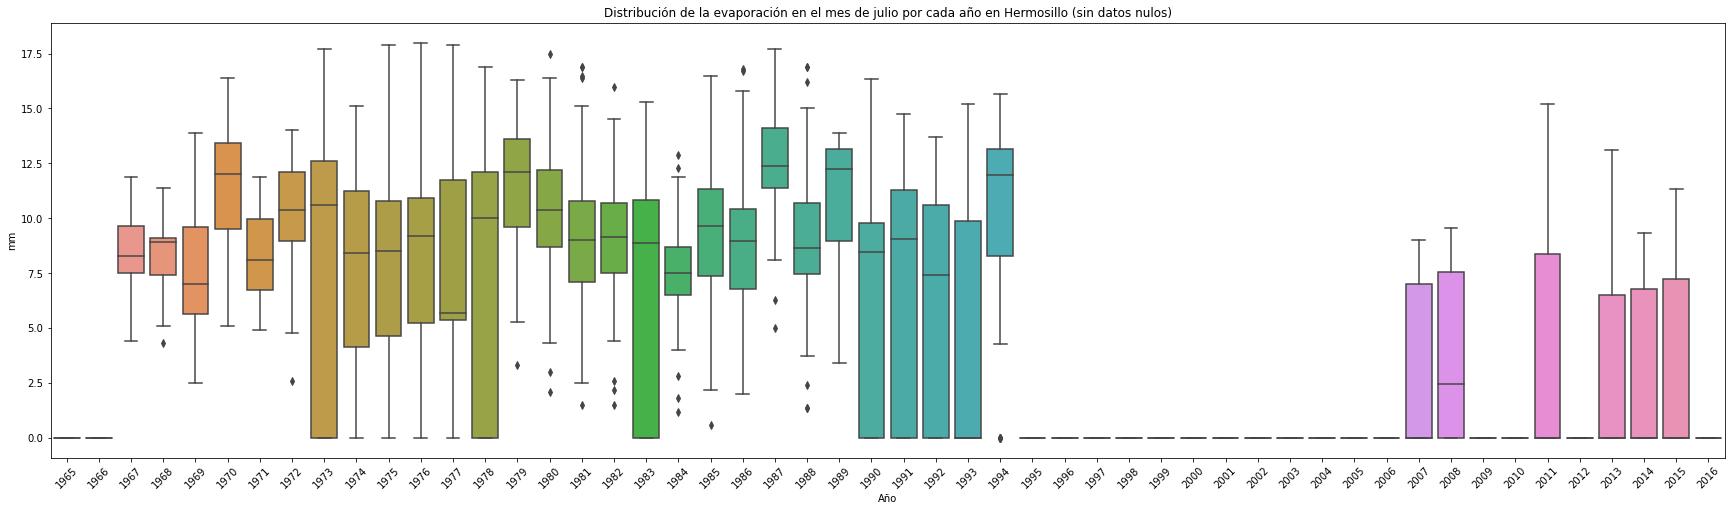

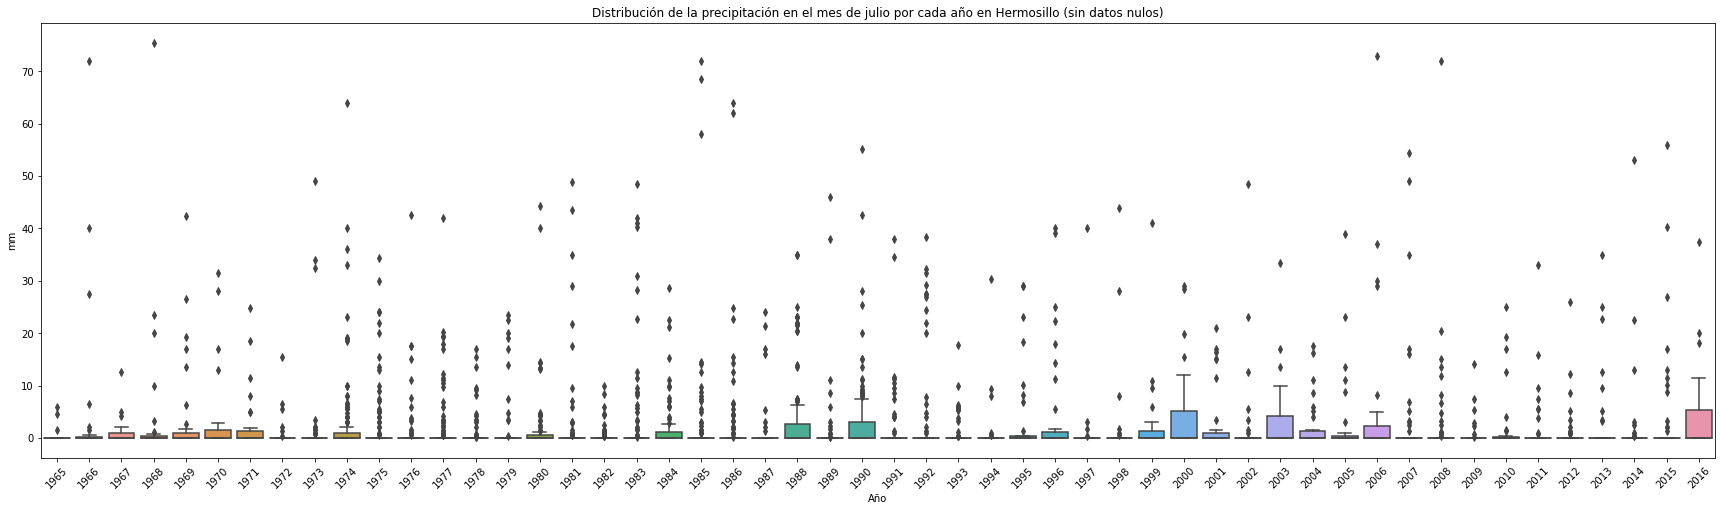

In [40]:
mes = 'julio'
for i in range(5):
    distribucionPorMes(dataframes_meses[mes], variables[i], f"{titulos[i]} en el mes de {mes} por cada año en Hermosillo (sin datos nulos)", 'Año', ylabels[i])

#### Agosto

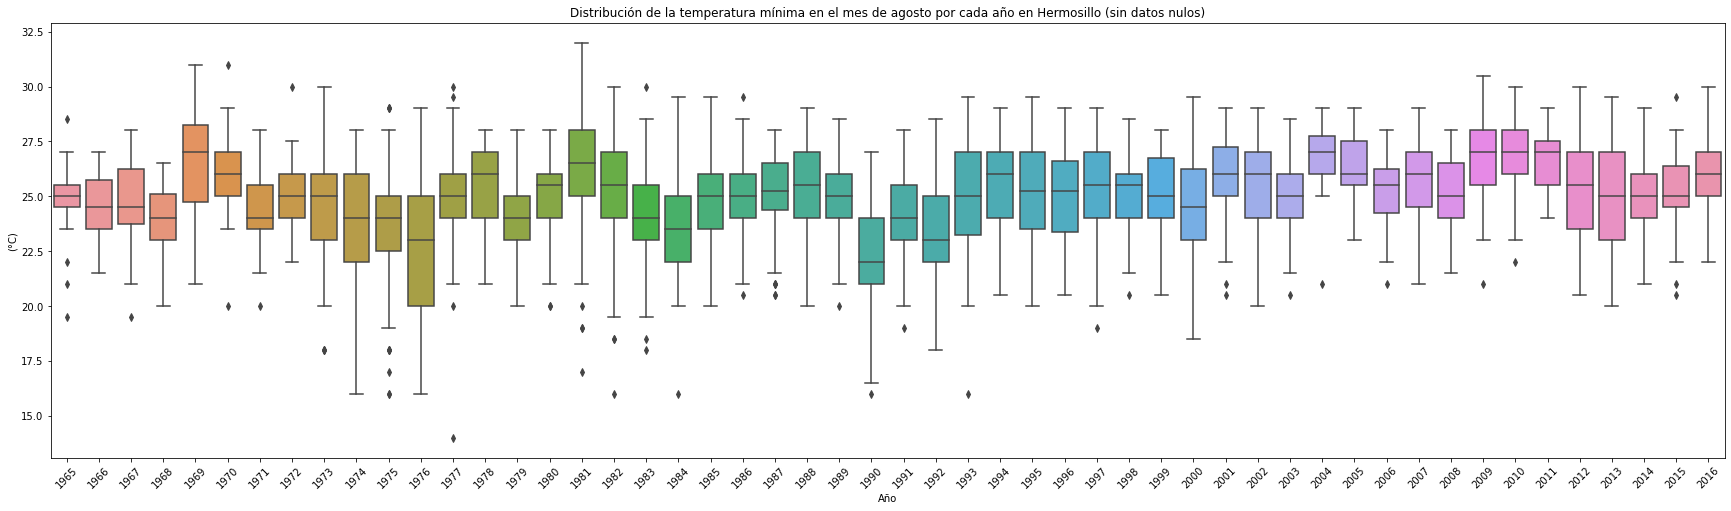

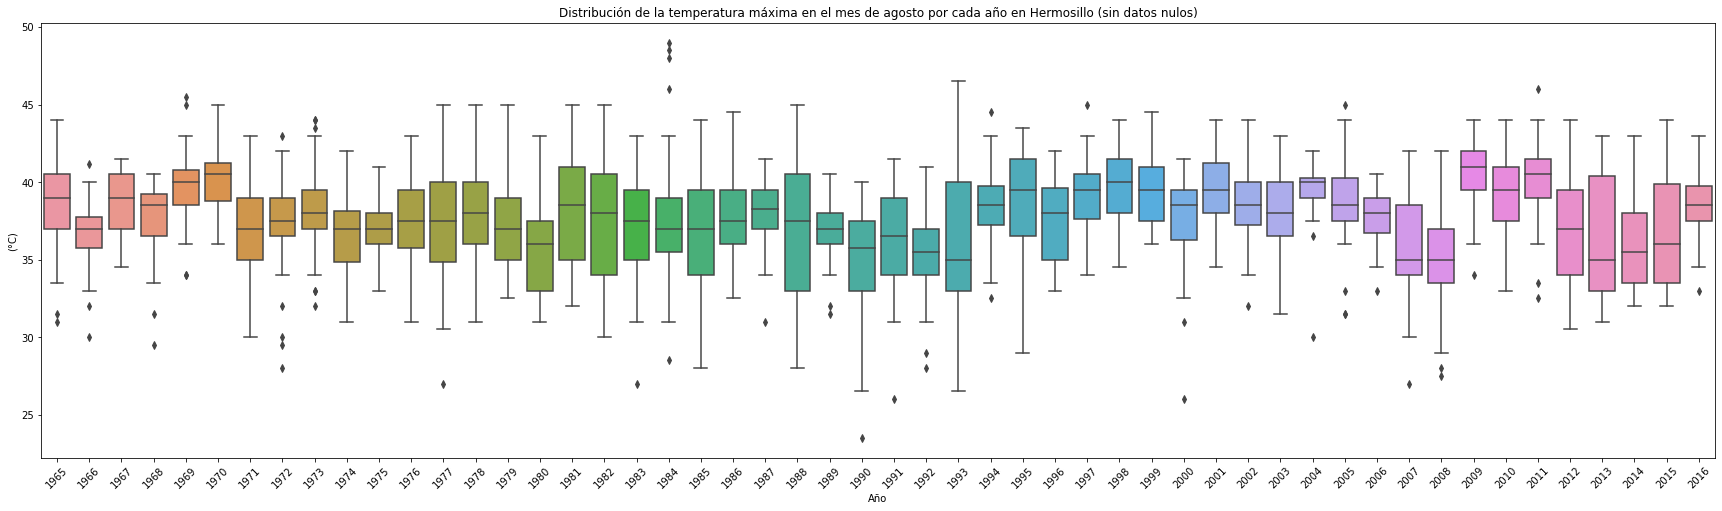

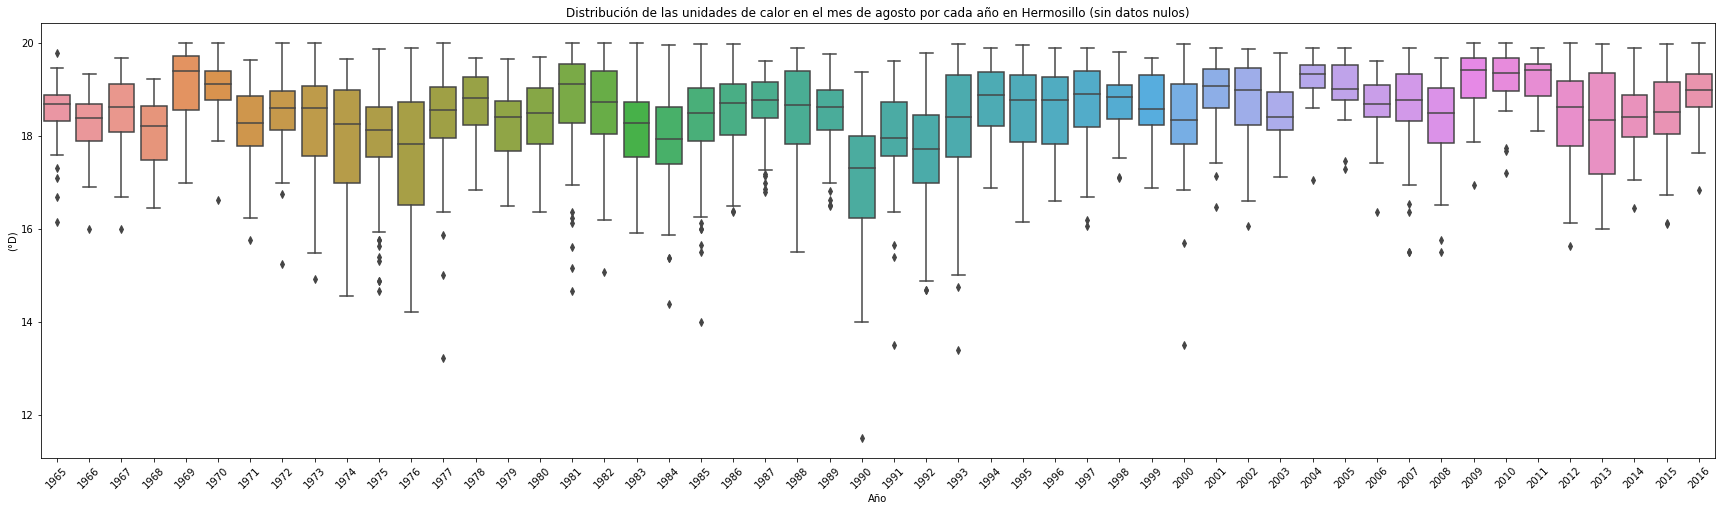

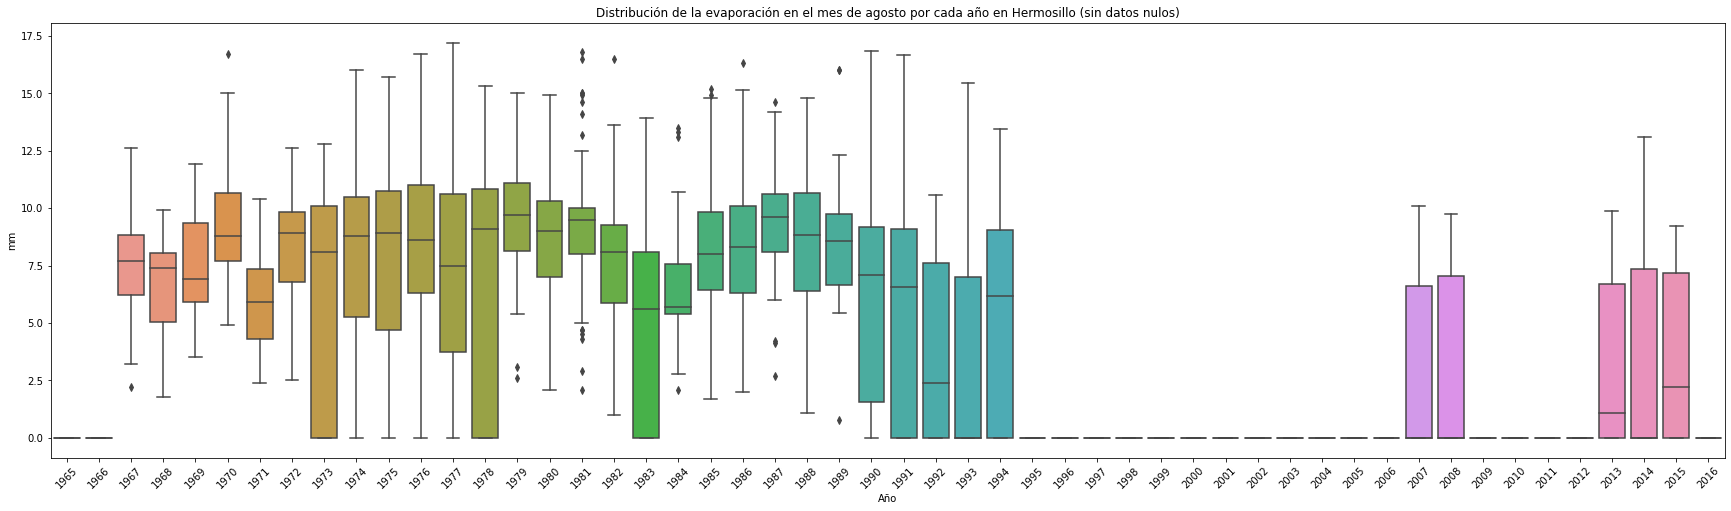

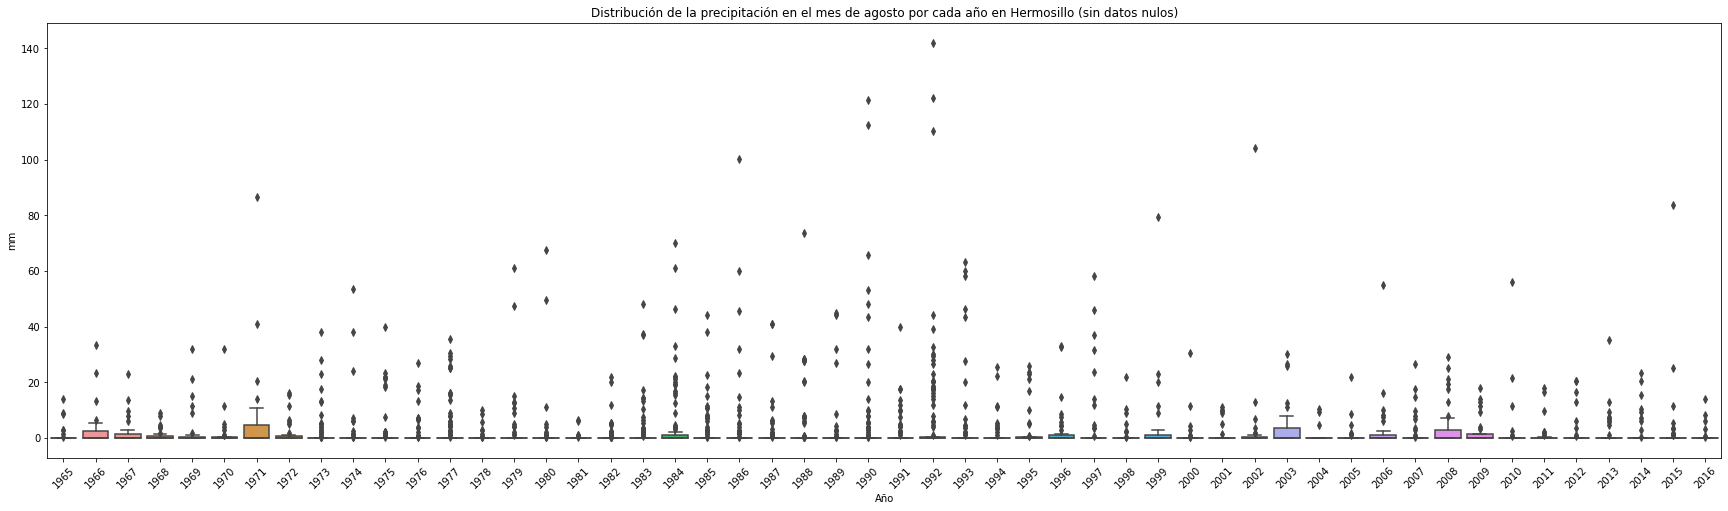

In [41]:
mes = 'agosto'
for i in range(5):
    distribucionPorMes(dataframes_meses[mes], variables[i], f"{titulos[i]} en el mes de {mes} por cada año en Hermosillo (sin datos nulos)", 'Año', ylabels[i])

#### Septiembre

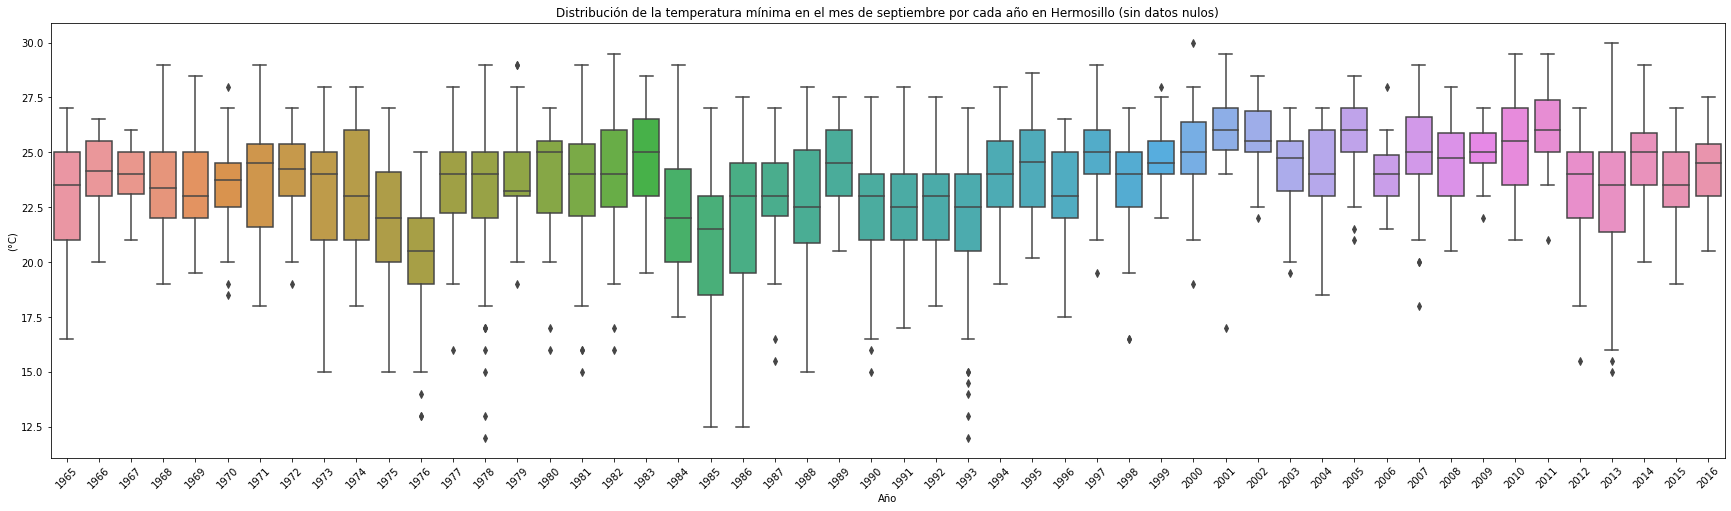

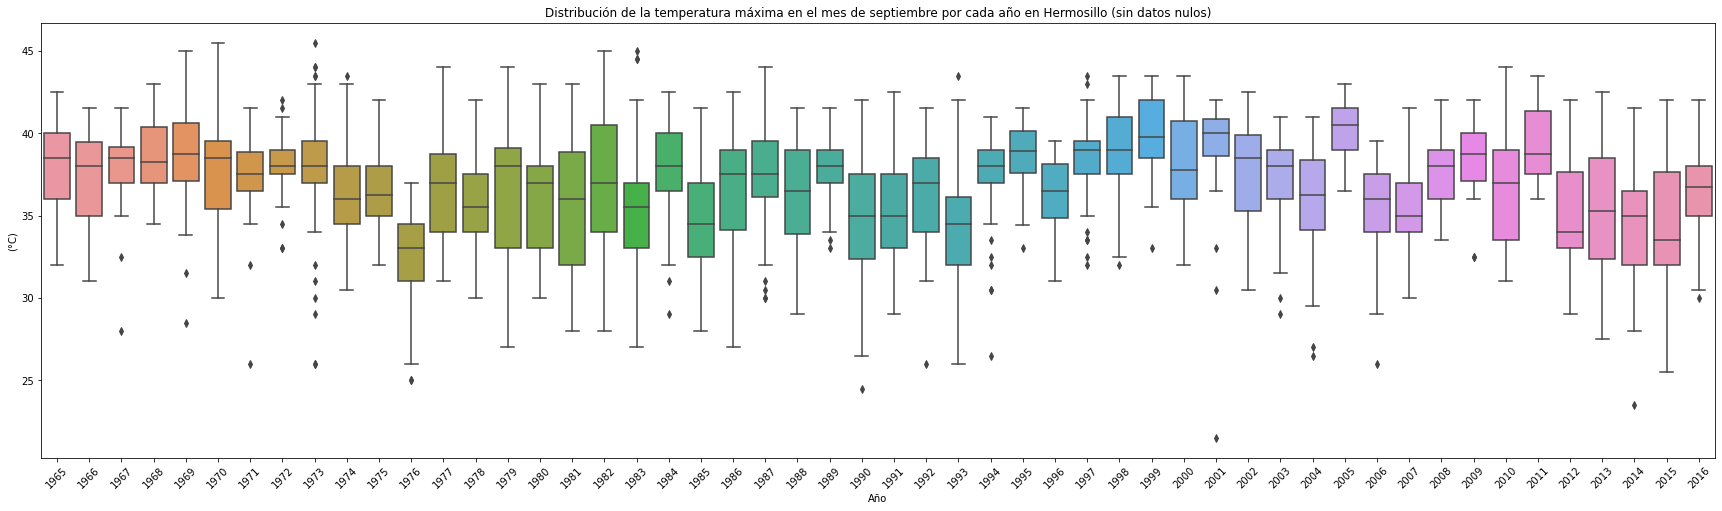

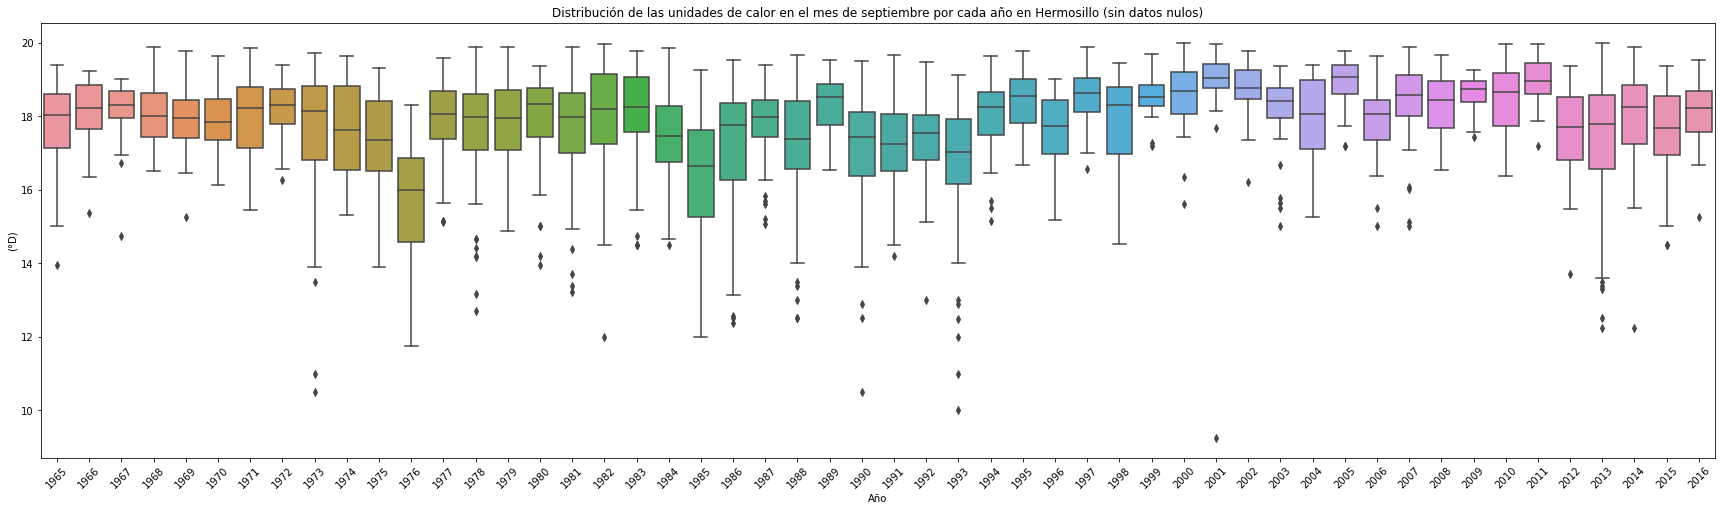

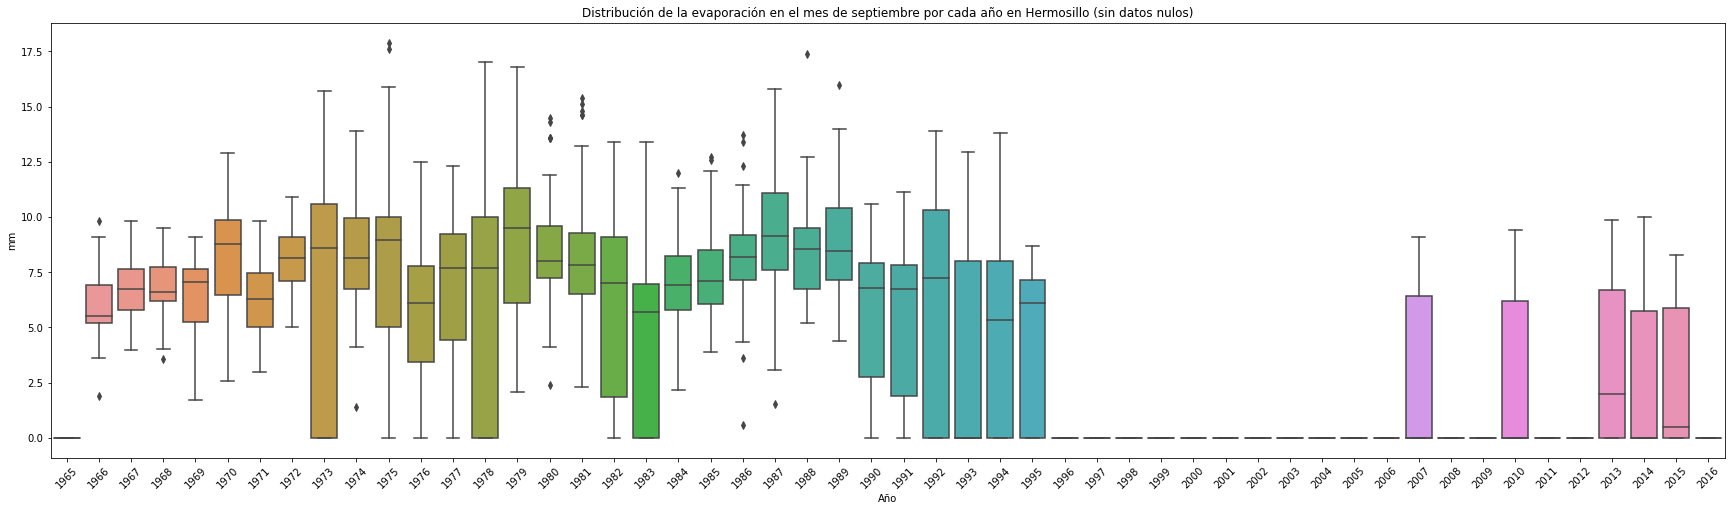

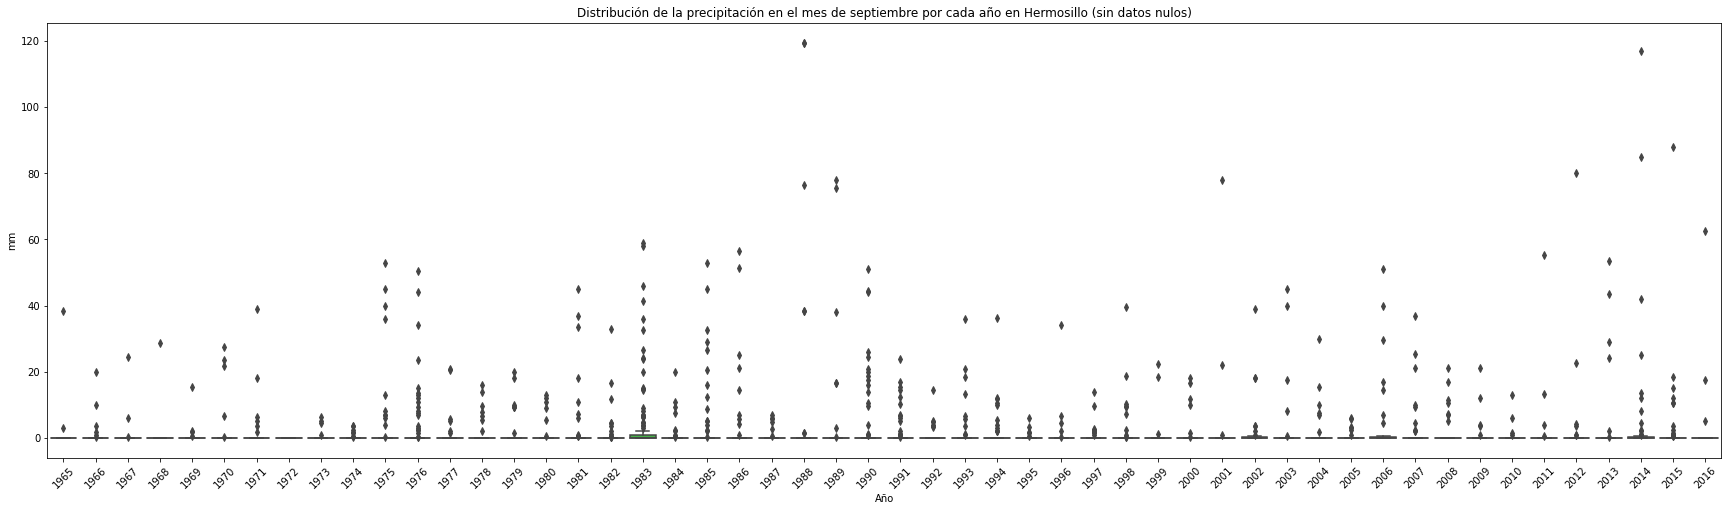

In [42]:
mes = 'septiembre'
for i in range(5):
    distribucionPorMes(dataframes_meses[mes], variables[i], f"{titulos[i]} en el mes de {mes} por cada año en Hermosillo (sin datos nulos)", 'Año', ylabels[i])

#### Octubre

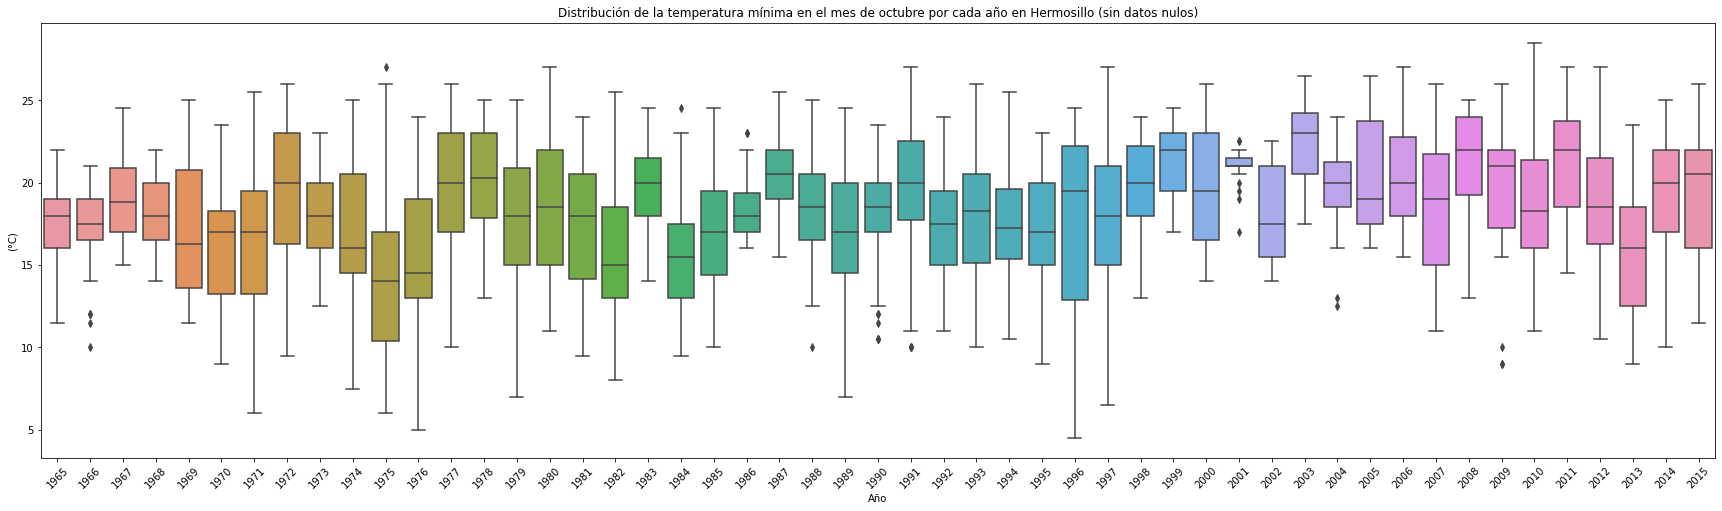

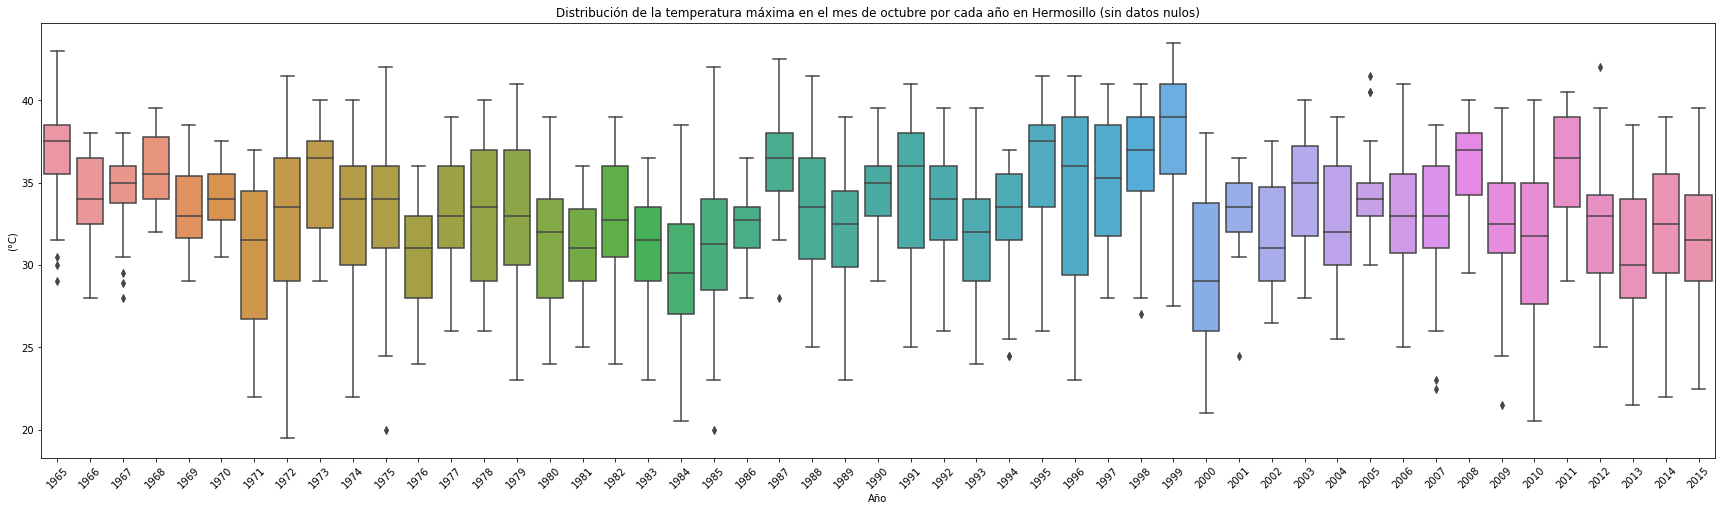

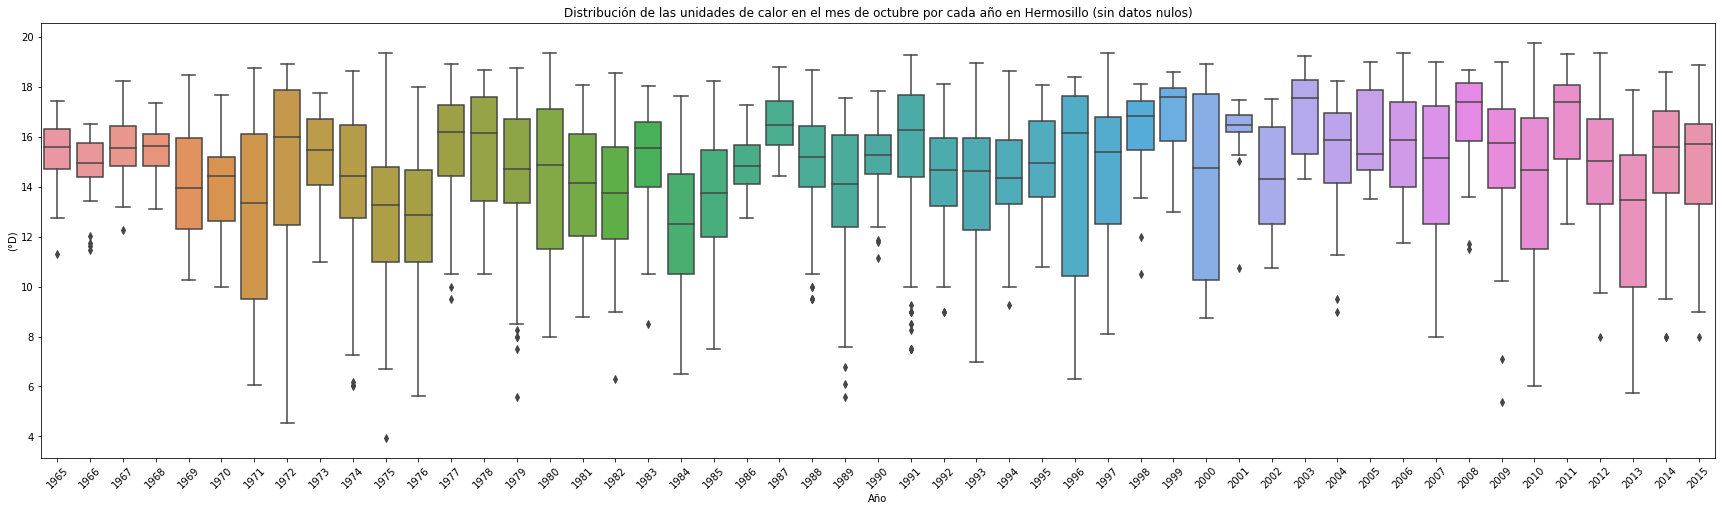

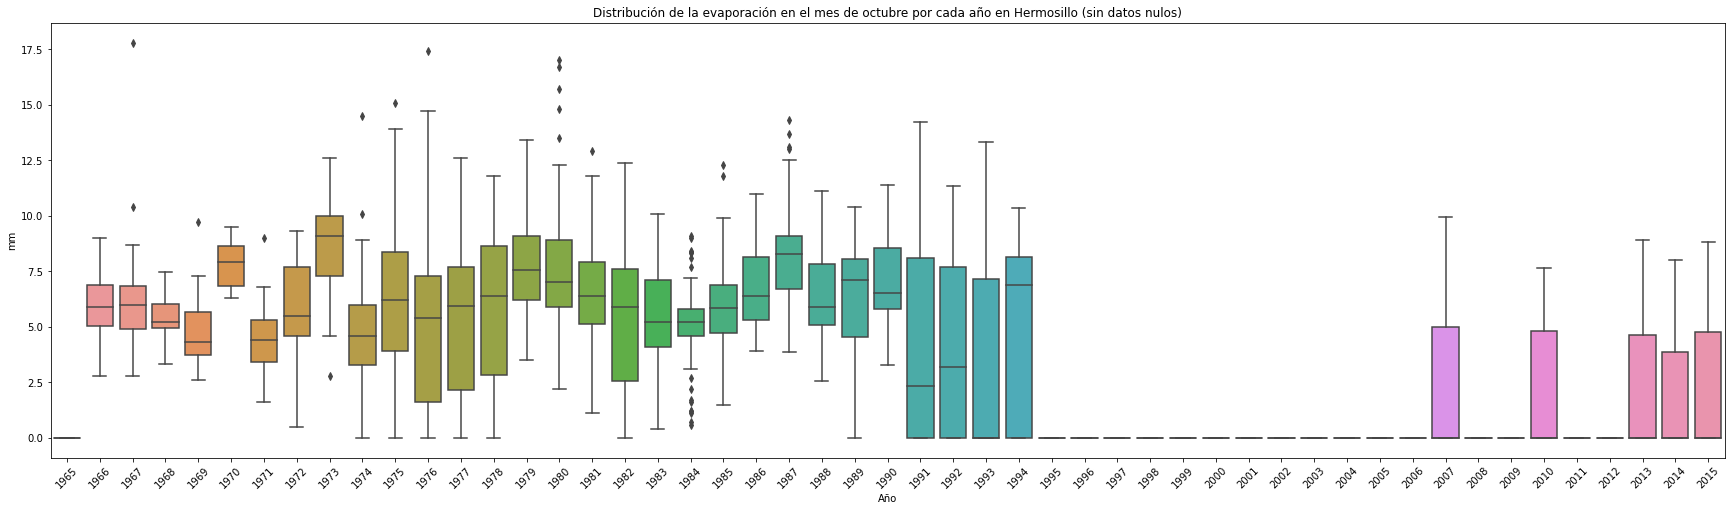

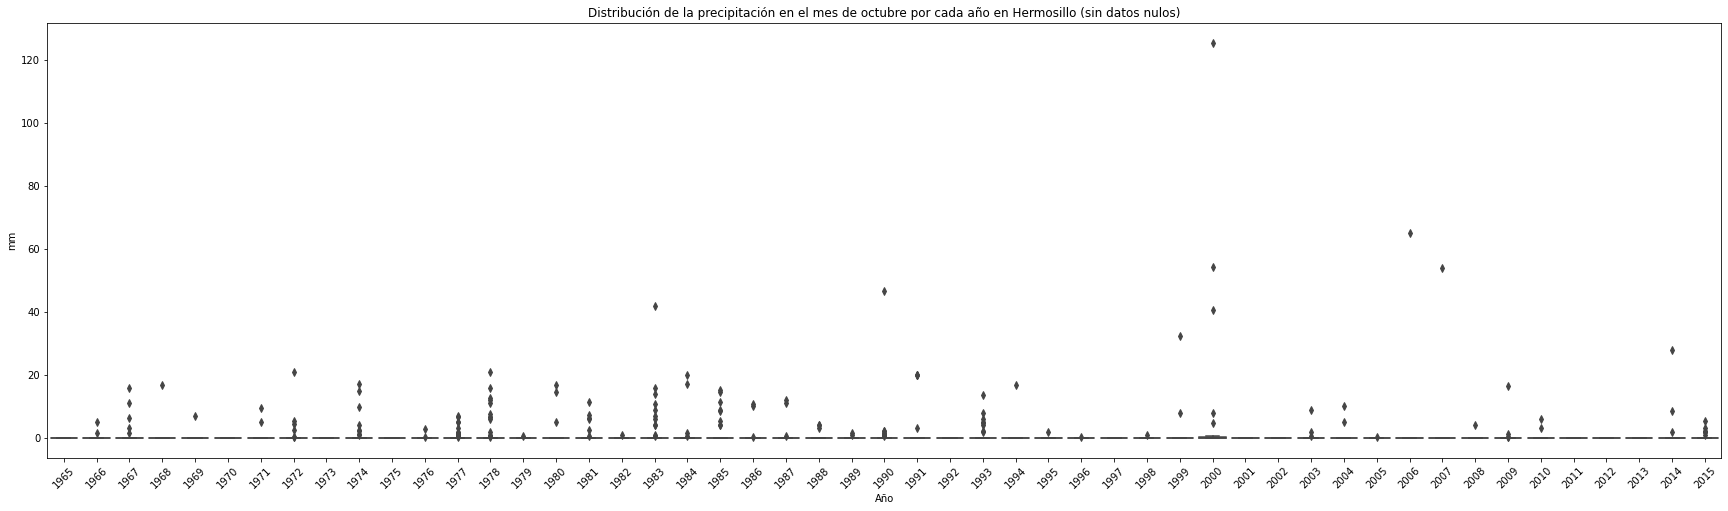

In [43]:
mes = 'octubre'
for i in range(5):
    distribucionPorMes(dataframes_meses[mes], variables[i], f"{titulos[i]} en el mes de {mes} por cada año en Hermosillo (sin datos nulos)", 'Año', ylabels[i])

#### Noviembre

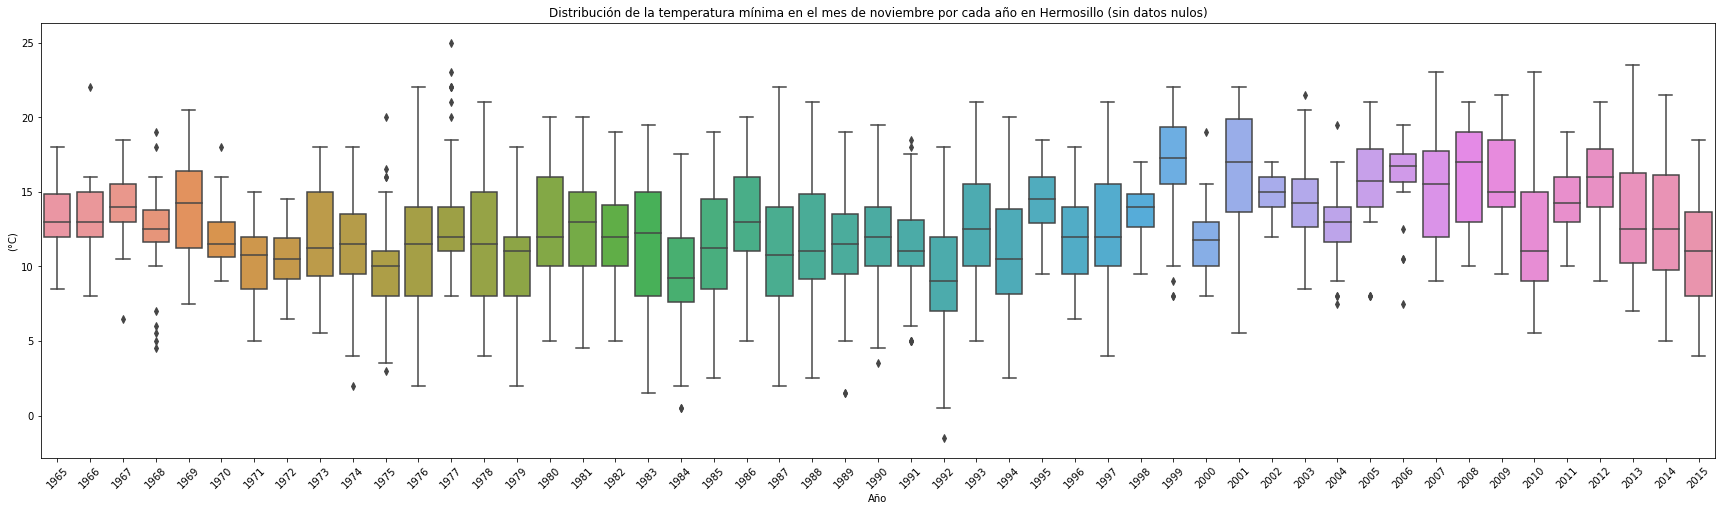

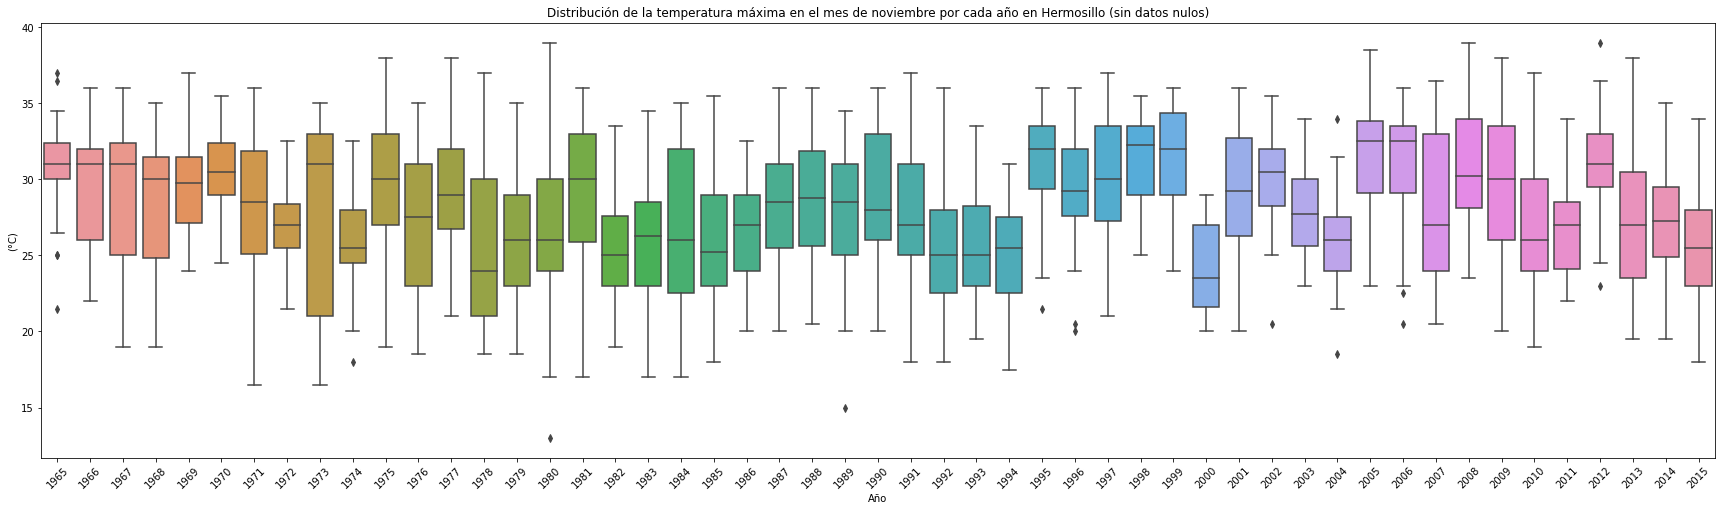

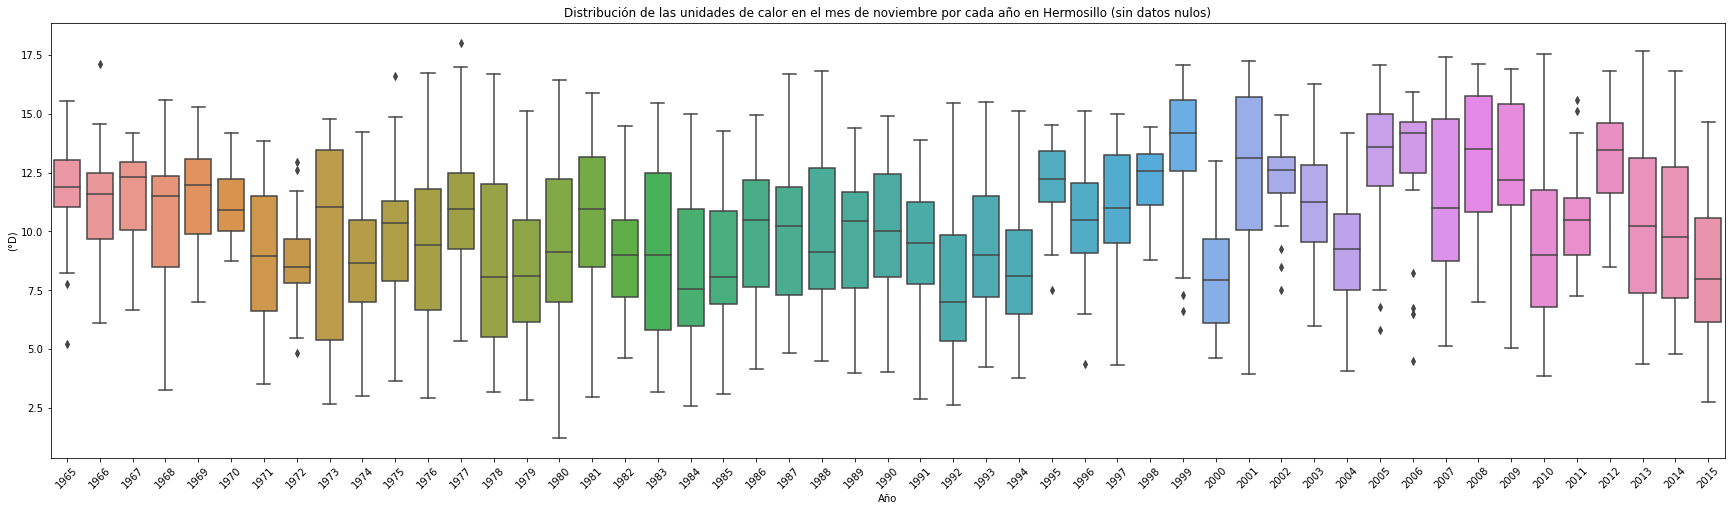

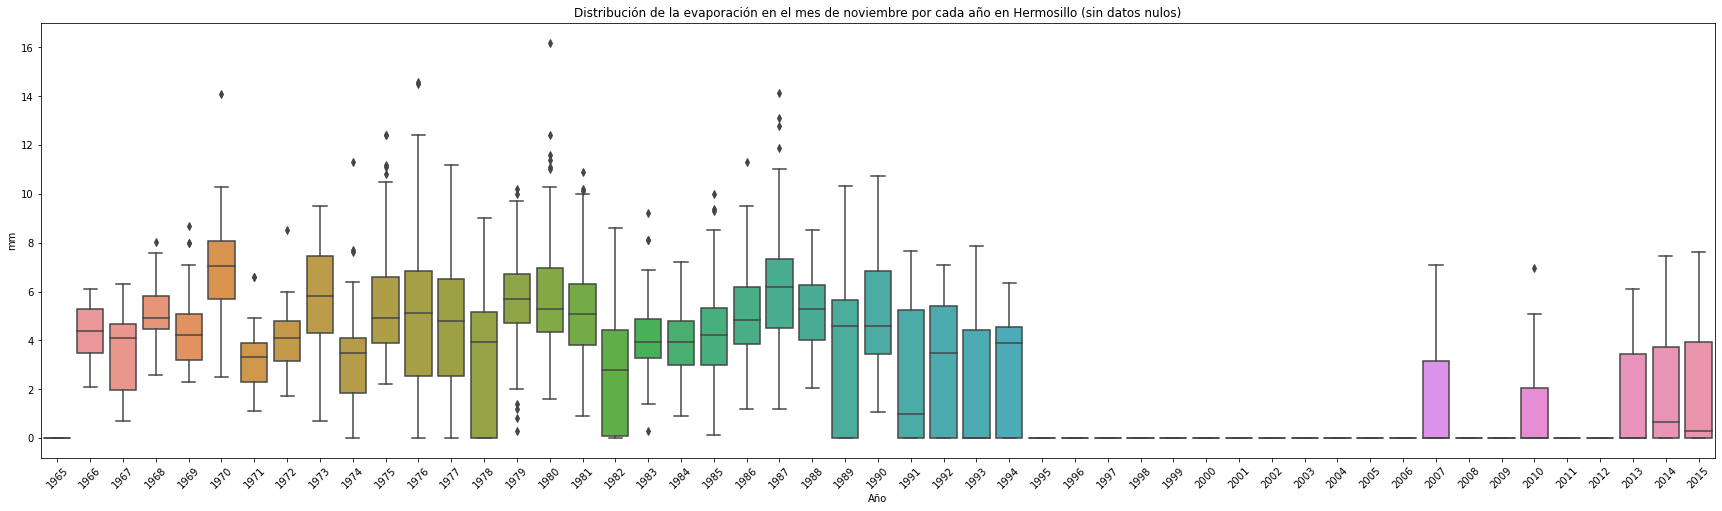

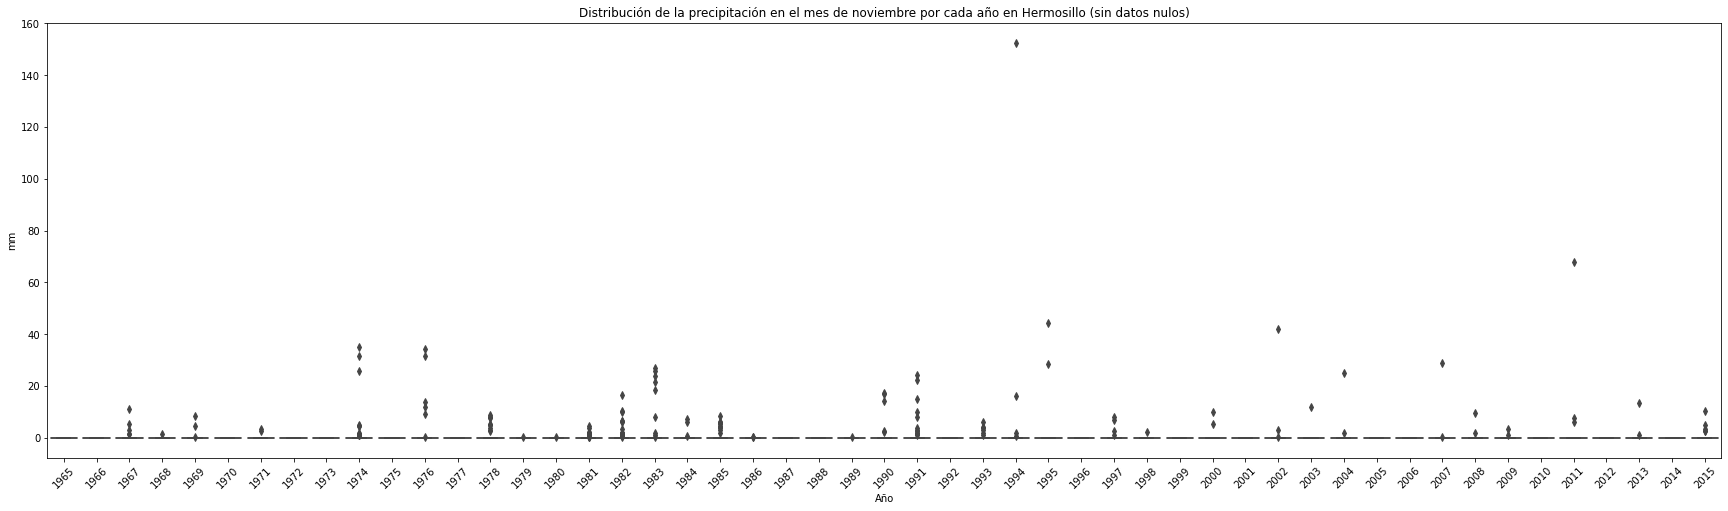

In [44]:
mes = 'noviembre'
for i in range(5):
    distribucionPorMes(dataframes_meses[mes], variables[i], f"{titulos[i]} en el mes de {mes} por cada año en Hermosillo (sin datos nulos)", 'Año', ylabels[i])

#### Diciembre

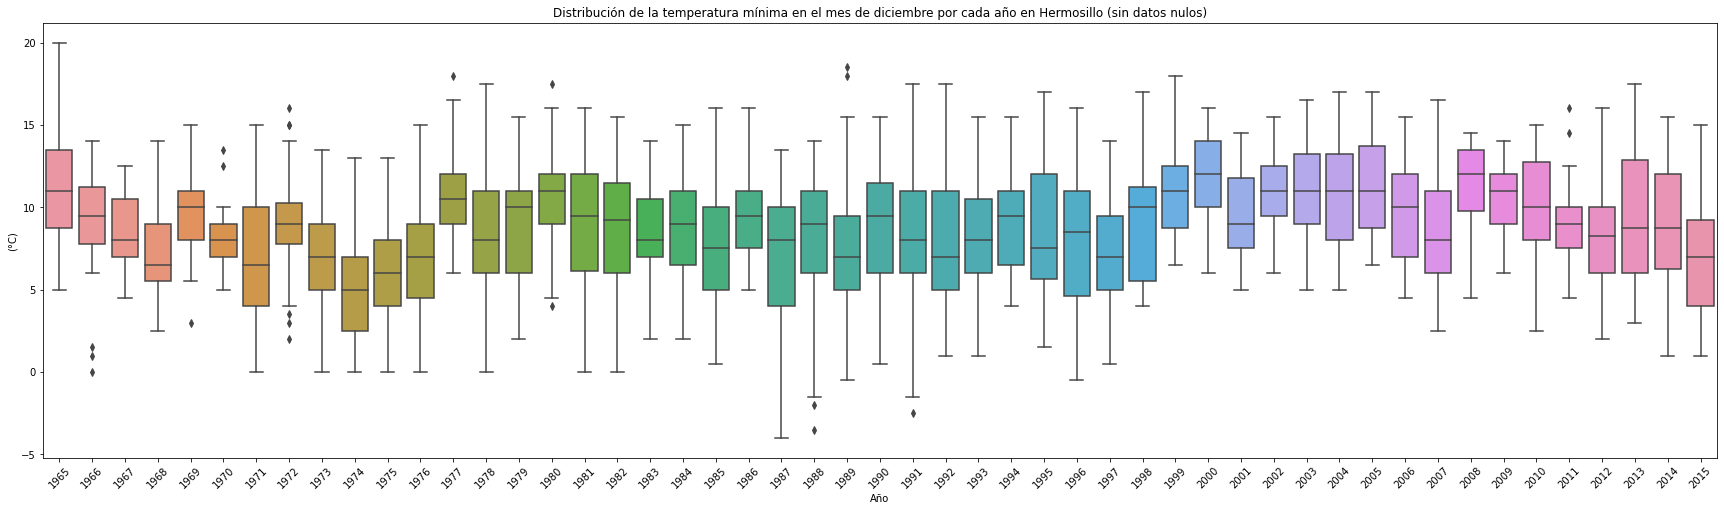

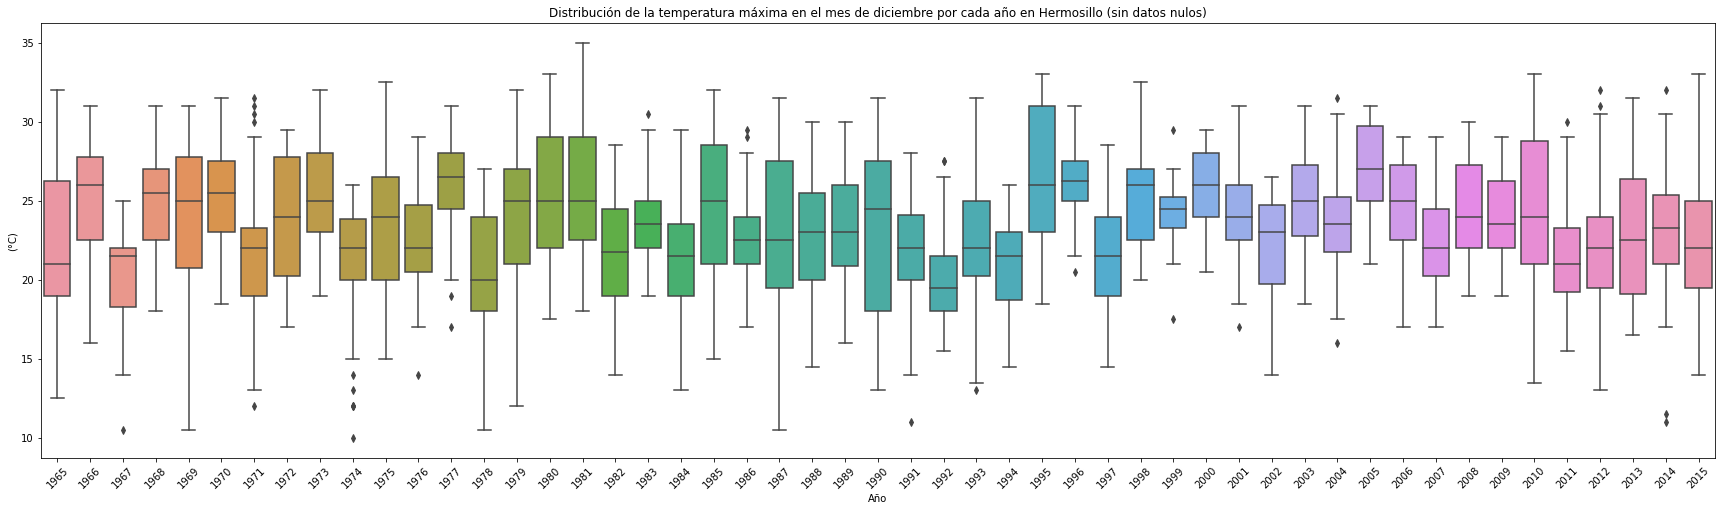

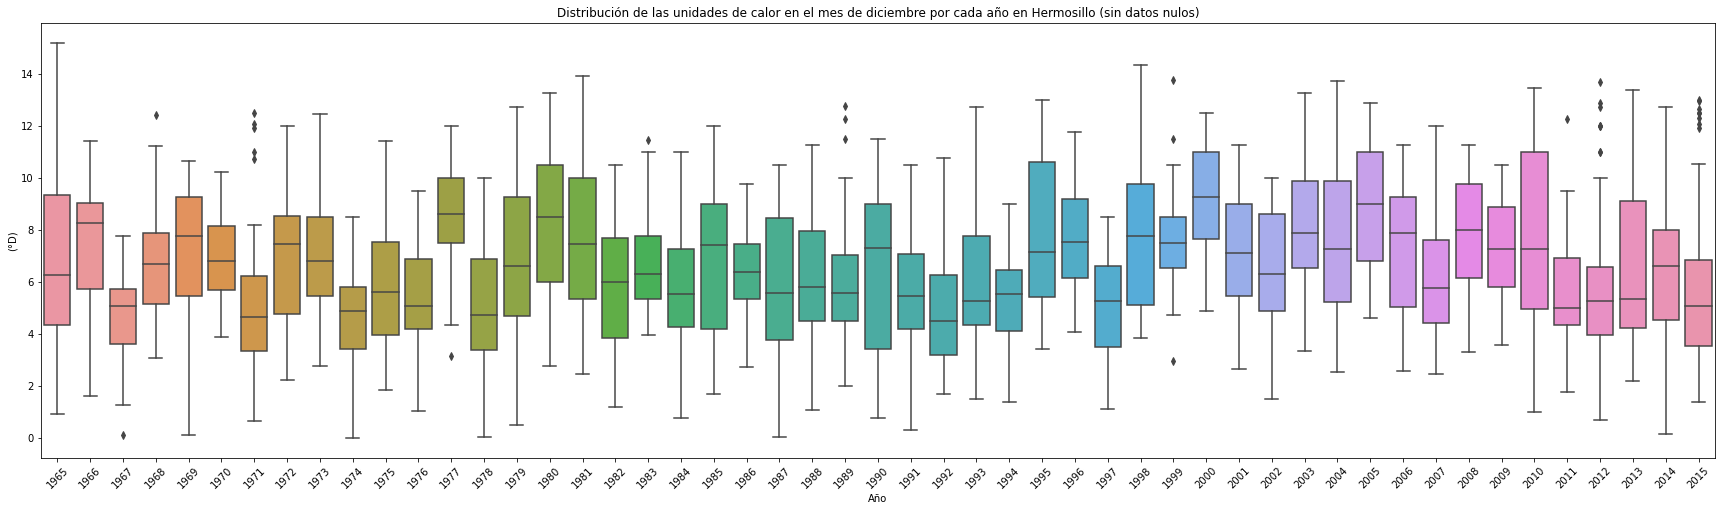

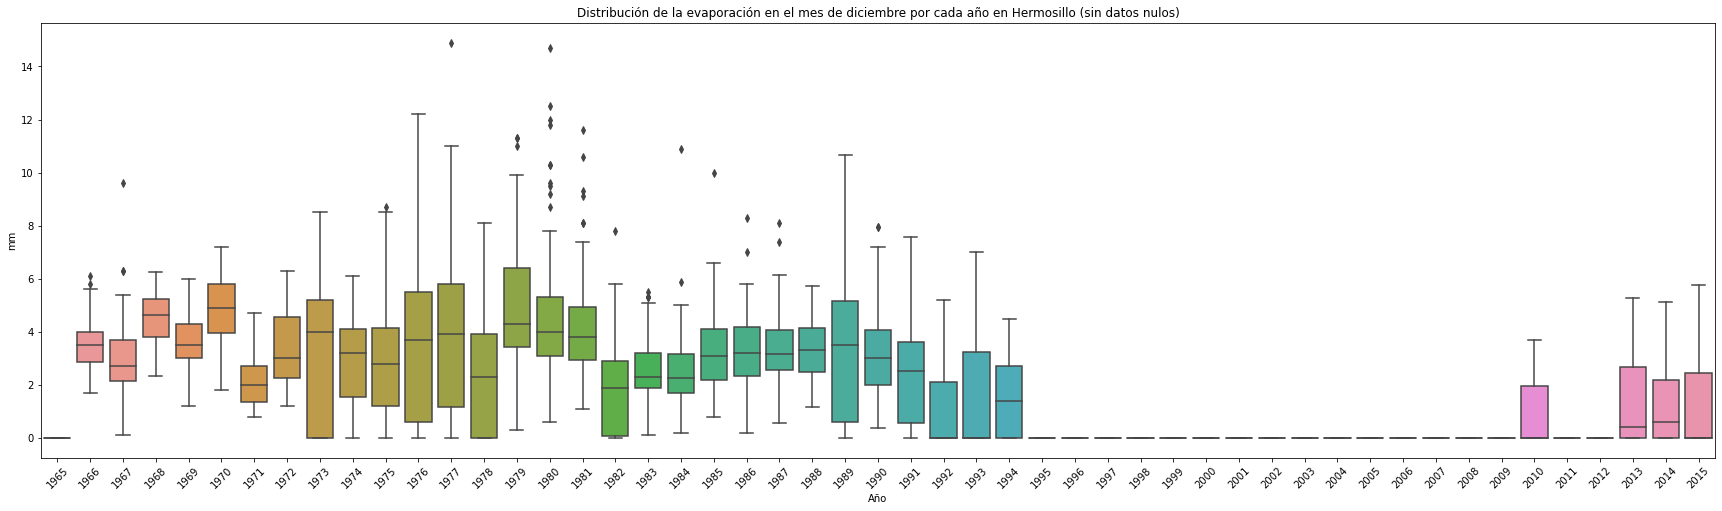

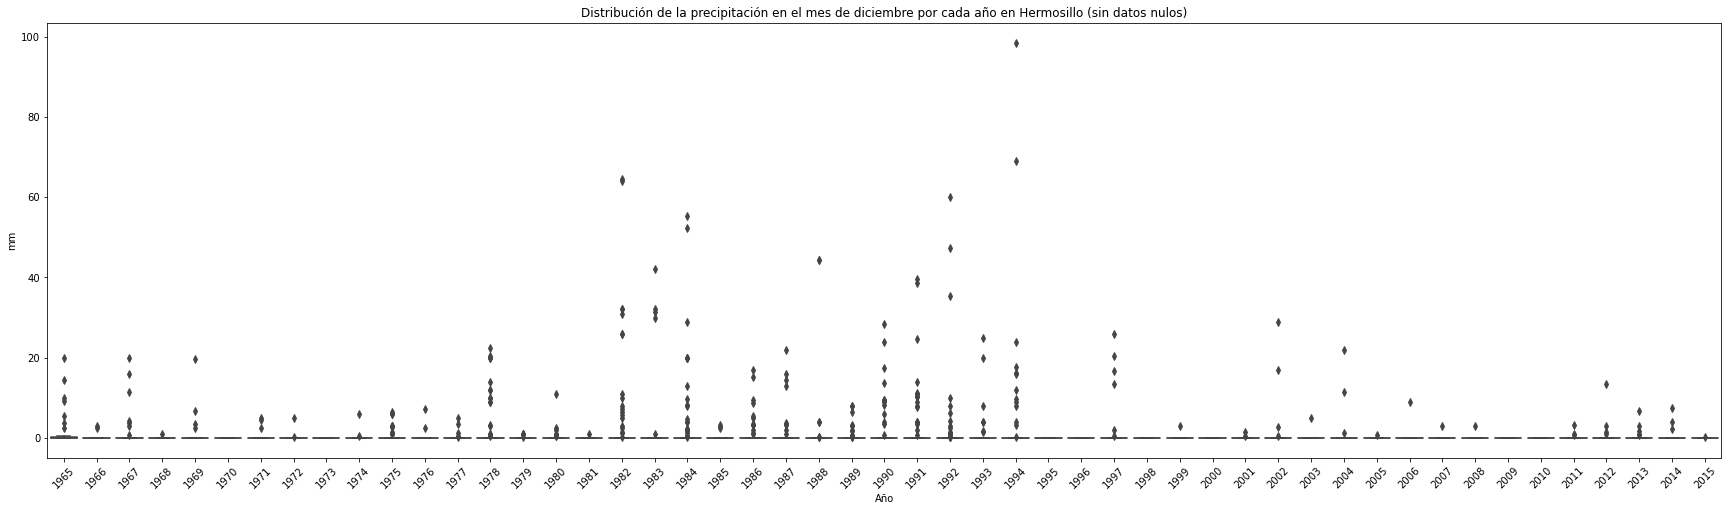

In [45]:
mes = 'diciembre'
for i in range(5):
    distribucionPorMes(dataframes_meses[mes], variables[i], f"{titulos[i]} en el mes de {mes} por cada año en Hermosillo (sin datos nulos)", 'Año', ylabels[i])

Podemos notar que al reducir el tamaño de los grupos para enfocarnos en intervalos de tiempo más pequeños la aparición de valores anómalos aumenta y la distribución de las variables presenta mayor variabilidad en cada intervalo.

### Distribución de las variables en cada mes

In [46]:
def distribucionPorMesTotal(df, variable, titulo, etiqueta_x, etiqueta_y):
    plt.figure(figsize = (30,8))
    g = sns.boxplot(x=df.Fecha.dt.month, y=variable, data=df)
    _ = g.set(title=titulo, xlabel=etiqueta_x, ylabel=etiqueta_y)
    g.set_xticklabels(['enero','febrero','marzo','abril','mayo','junio','julio',
                           'agosto','septiembre','octubre','noviembre','diciembre'])

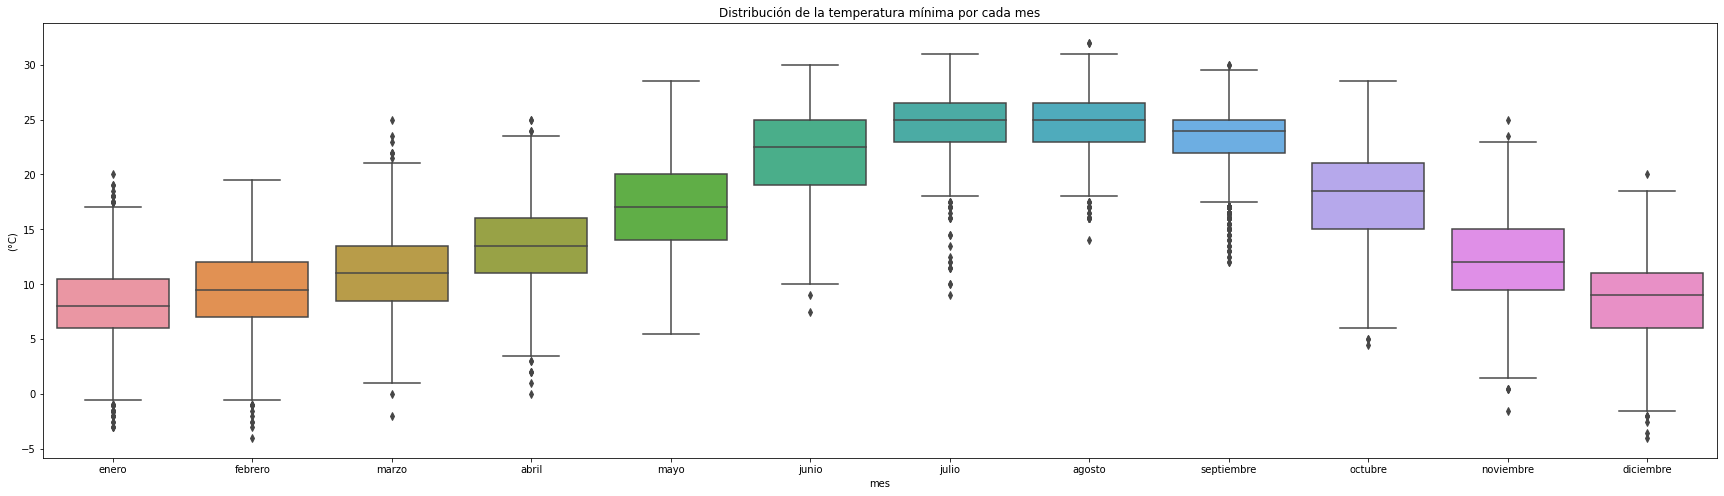

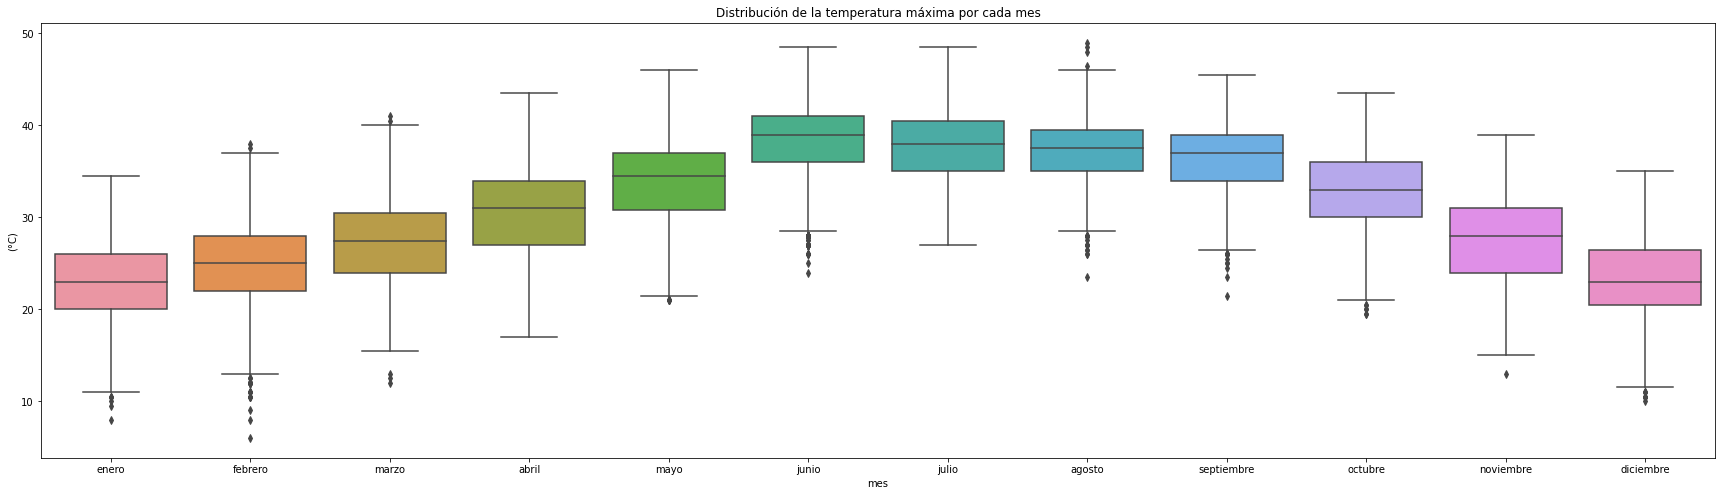

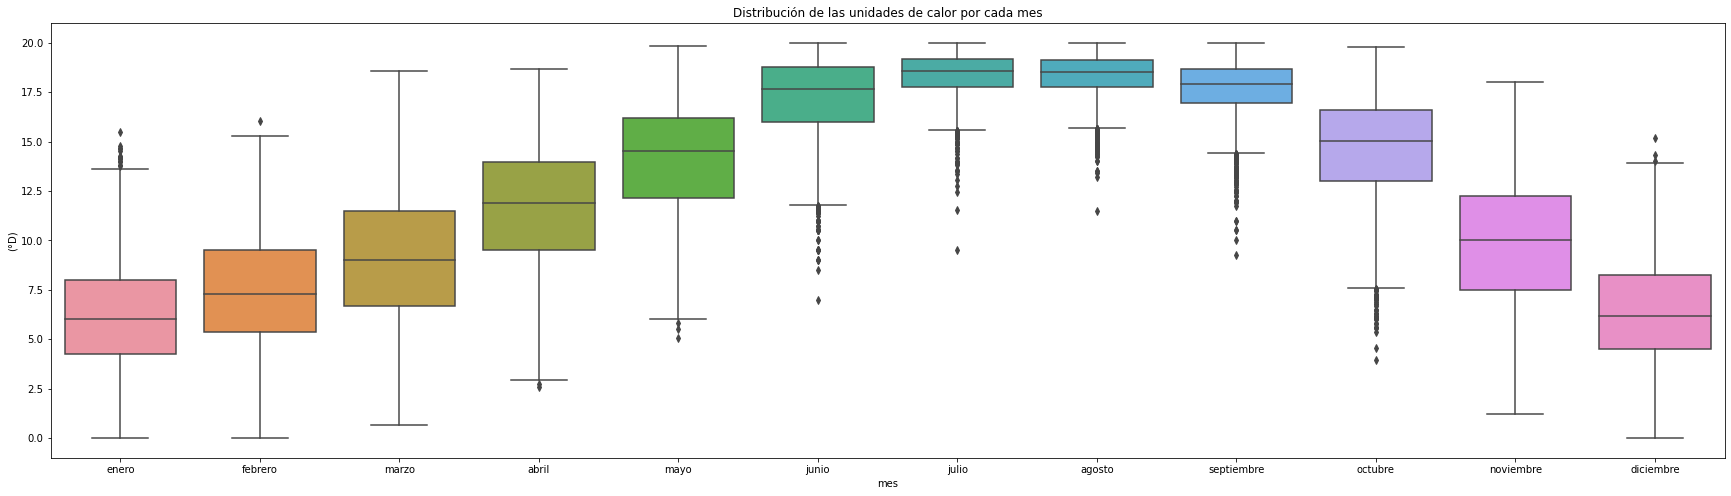

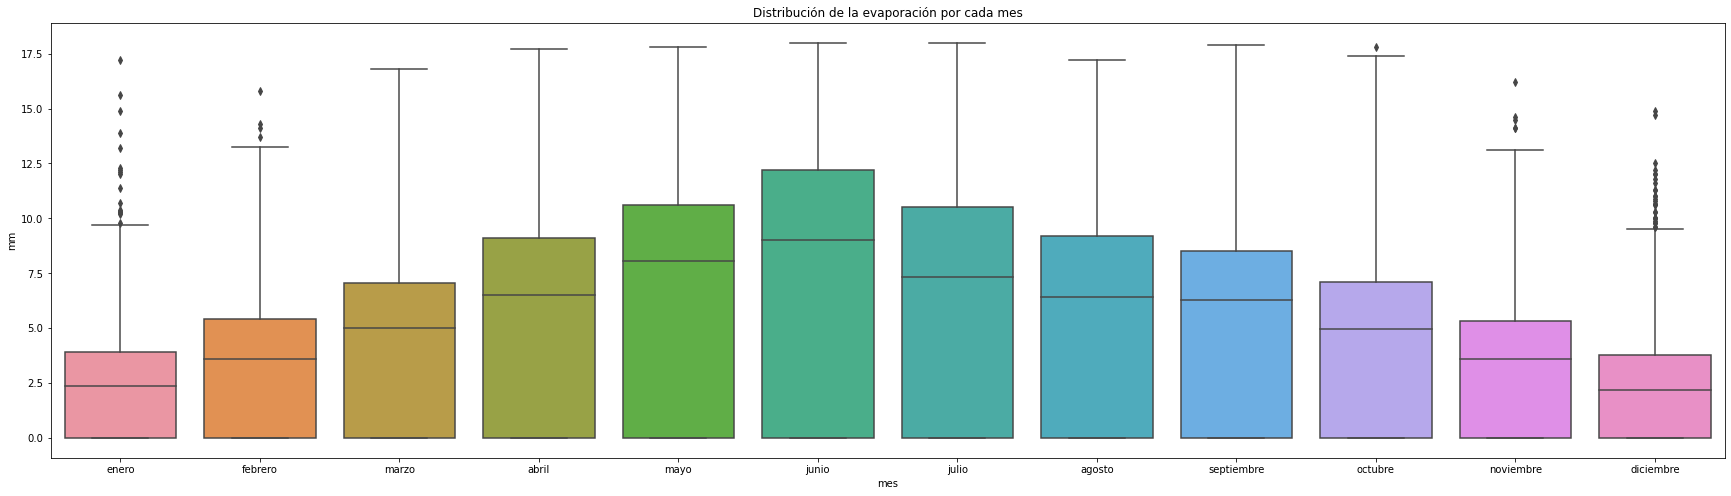

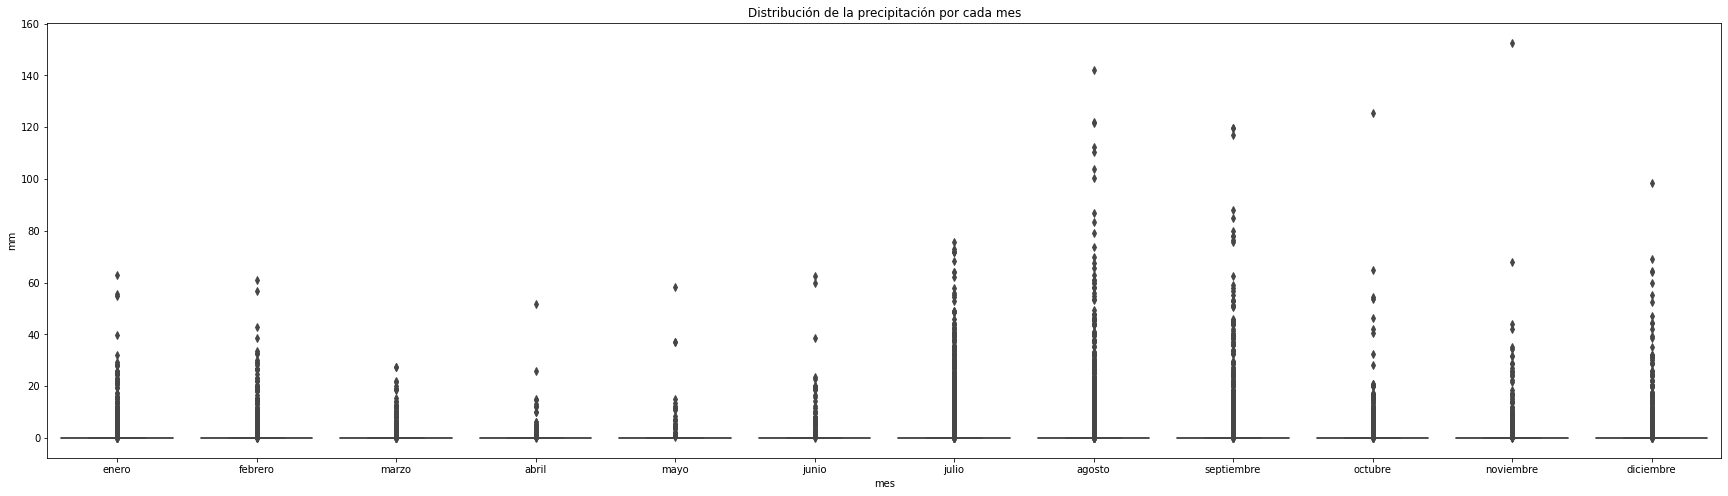

In [47]:
for i in range(5):
    distribucionPorMesTotal(df, variables[i], f"{titulos[i]} por cada mes", 'mes', ylabels[i])

Como era de esperarse, las temperaturas junto con las unidades de calor son más bajas a inicios y finales de año, y más altas en los meses medios.

### Series de tiempo

A continuación se graficará algunas series de tiempo. Para ésto se tomarán las cantidades medias por cada día porque recordemos que existen diferentes estaciones y cada una aporta sus lecturas diariamente.

In [48]:
df_medias_por_dia = df.groupby(['Fecha']).mean().reset_index().sort_values('Fecha')
df_medias_por_dia

Fecha  Tmin  Tmax  UCalor  Evap  Precip
0     1965-07-13  26.0  40.0   19.06   0.0     0.0
1     1965-07-14  26.0  40.5   19.08   0.0     6.0
2     1965-07-15  23.0  37.0   17.77   0.0     0.0
3     1965-07-16  26.0  39.0   19.03   0.0     0.0
4     1965-07-17  24.0  38.5   18.28   0.0     0.0
...          ...   ...   ...     ...   ...     ...
18673 2016-09-26  24.0  36.0   18.09   0.0     5.2
18674 2016-09-27  21.0  35.5   16.75   0.0     0.0
18675 2016-09-28  22.0  35.0   17.13   0.0     0.0
18676 2016-09-29  24.0  37.5   18.21   0.0     0.0
18677 2016-09-30  24.5  37.0   18.37   0.0     0.0

[18678 rows x 6 columns]

#### Temperaturas

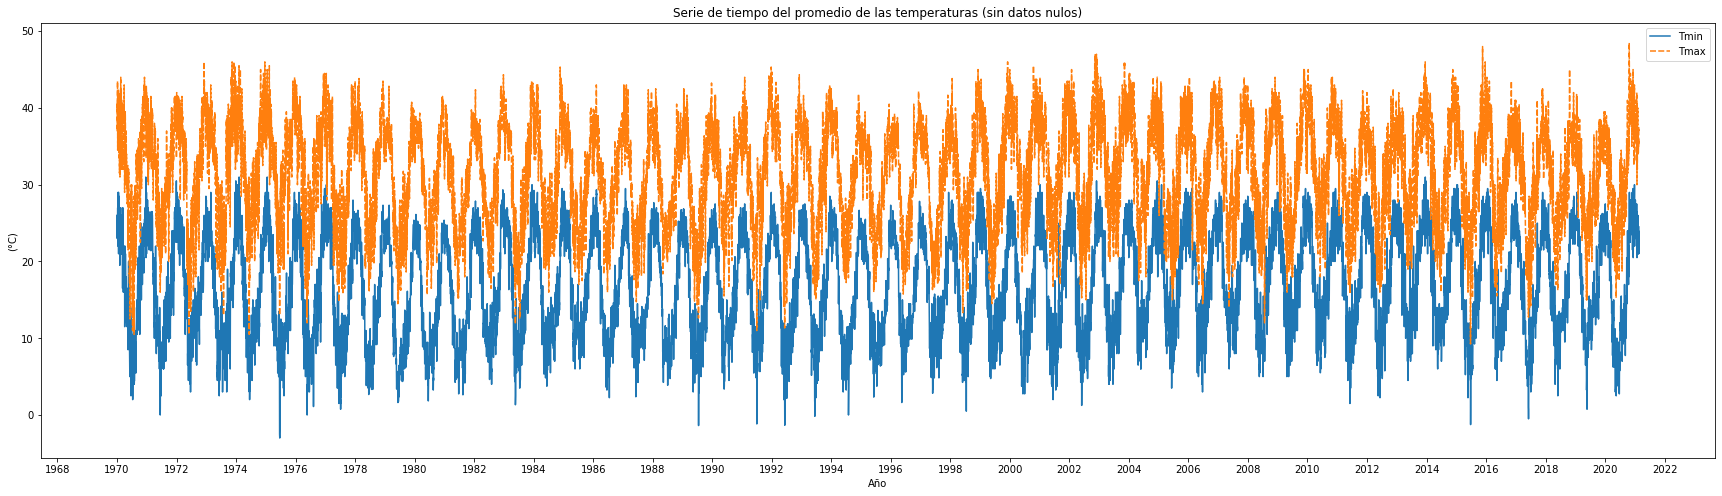

In [49]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(30, 8))
sns.lineplot(data = df_medias_por_dia.iloc[:,1:3]).set(title='Serie de tiempo del promedio de las temperaturas (sin datos nulos)', xlabel='Año', ylabel='(°C)')
# Define the date format
date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
ax.xaxis.set_major_locator(mdates.YearLocator(2))

#### Unidades de calor

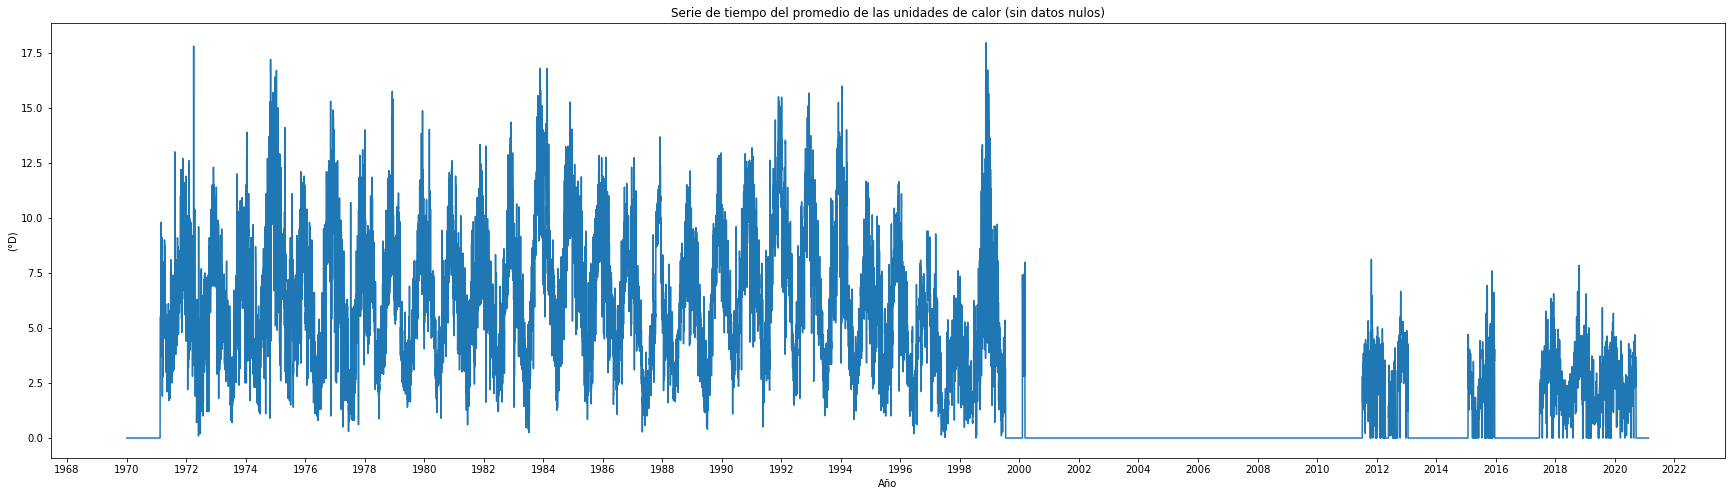

In [50]:
fig, ax = plt.subplots(figsize=(30, 8))
sns.lineplot(data = df_medias_por_dia.iloc[:,4]).set(title='Serie de tiempo del promedio de las unidades de calor (sin datos nulos)', xlabel='Año', ylabel='(°D)')
# Define the date format
date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
ax.xaxis.set_major_locator(mdates.YearLocator(2))

#### Evaporación y precipitación

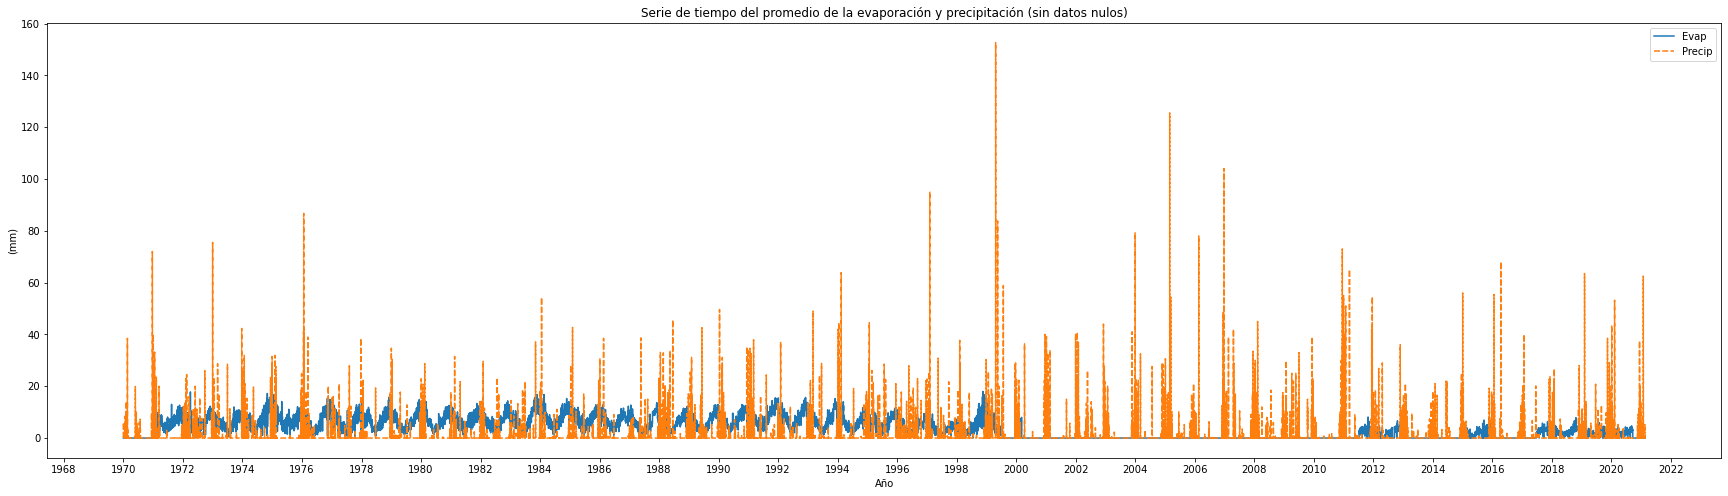

In [51]:
fig, ax = plt.subplots(figsize=(30, 8))
sns.lineplot(data = df_medias_por_dia.iloc[:,4:6]).set(title='Serie de tiempo del promedio de la evaporación y precipitación (sin datos nulos)', xlabel='Año', ylabel='(mm)')
# Define the date format
date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
ax.xaxis.set_major_locator(mdates.YearLocator(2))

## Detección de anomalías

A continuación, se utilizarán los algoritmos *Local Outlier Factor* y *Z-Score* para conocer los valores atípicos que las variables de temperatura máxima y temperatura mínima han presentado a lo largo de los años

### Análisis visual

En las siguientes gráficas se muestran las mediciones de estaciones metereologicas de Hermosillo

Text(0.5, 0, 'Temperatura Promedio')

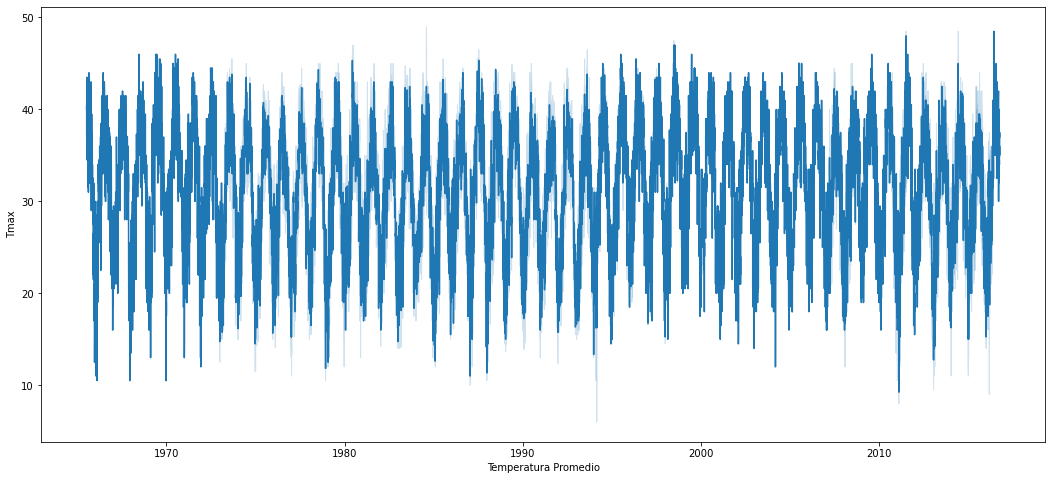

In [52]:
plt.figure(figsize=(18,8))
sns.lineplot(x = 'Fecha', y = 'Tmax', data = df)
plt.xlabel('Temperatura Promedio')

Text(0.5, 0, 'Temperatura Maxima')

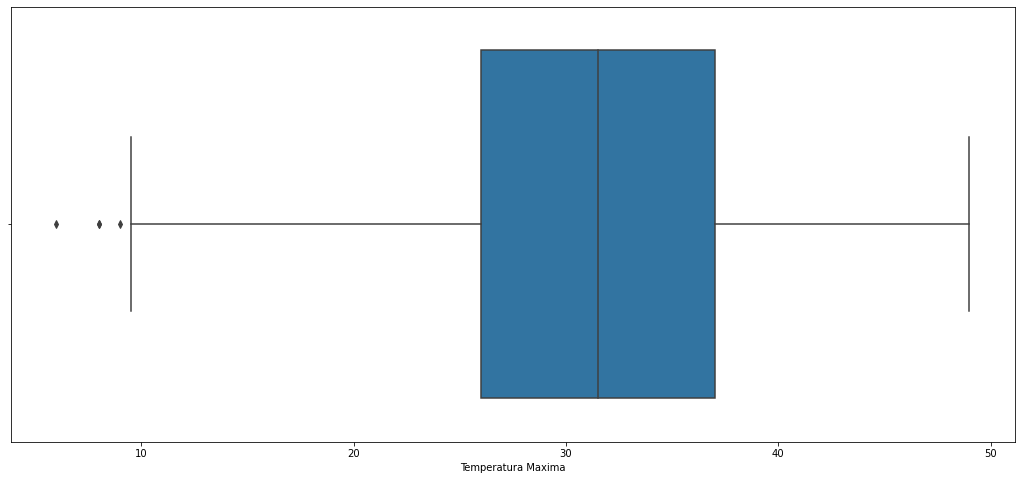

In [53]:
plt.figure(figsize = (18,8))
sns.boxplot(x=df.Tmax)
plt.xlabel('Temperatura Maxima')

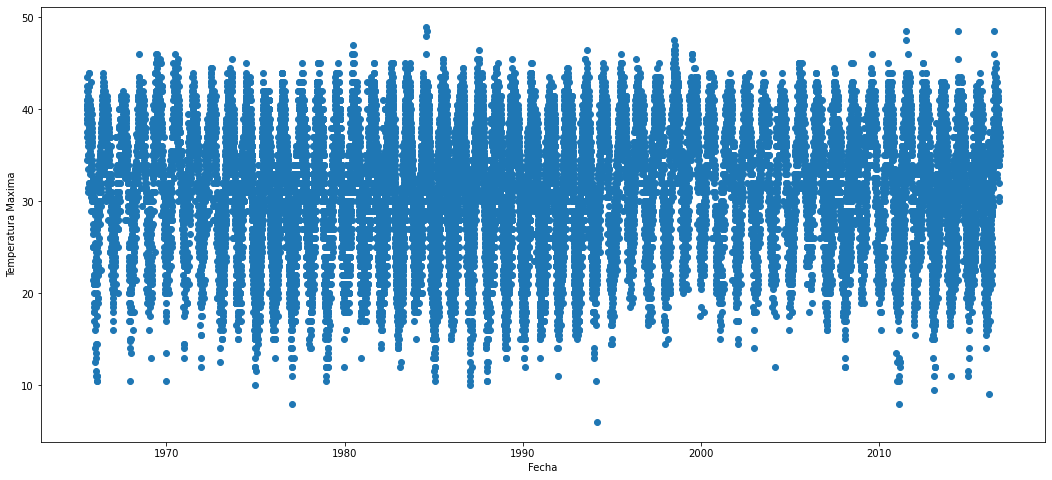

In [54]:
plt.figure(figsize = (18,8))
plt.scatter(df.Fecha, df.Tmax)
plt.xlabel('Fecha')
plt.ylabel('Temperatura Maxima');

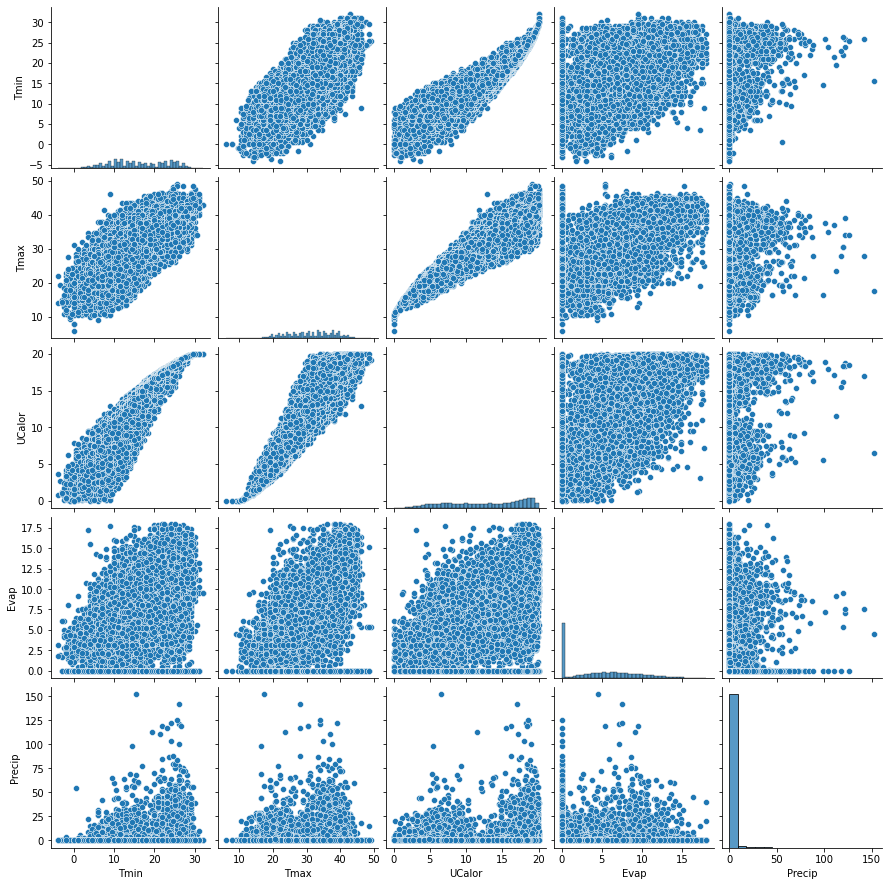

In [55]:
sns.pairplot(df, height= 2.5)

### Local Outlier Factor Method(LOF)

Con este método se pretende encontrar los cambios de temperatura más extremo ocurridos en un solo día en base a las temperaturas mínimas y máximas regristradas.

In [56]:
clf = LocalOutlierFactor(n_neighbors=200, contamination='auto')
X = df[['Tmin', 'Tmax']].values
y_pred = clf.fit_predict(X)

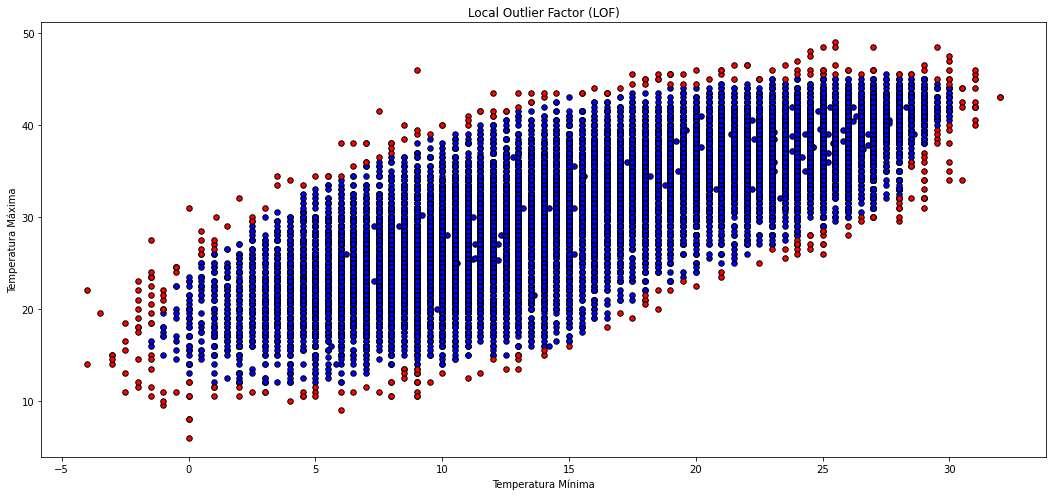

In [57]:
plt.figure(figsize=(18,8))
# plot the level sets of the decision function

in_mask = [True if l == 1 else False for l in y_pred]
out_mask = [True if l == -1 else False for l in y_pred]

plt.title("Local Outlier Factor (LOF)")
# inliers
a = plt.scatter(X[in_mask, 0], X[in_mask, 1], c = 'blue',
                edgecolor = 'k', s = 30)
# outliers
b = plt.scatter(X[out_mask, 0], X[out_mask, 1], c = 'red',
                edgecolor = 'k', s = 30)
#plt.axis('Tprom')
plt.xlabel('Temperatura Mínima');
plt.ylabel('Temperatura Máxima');
plt.show()

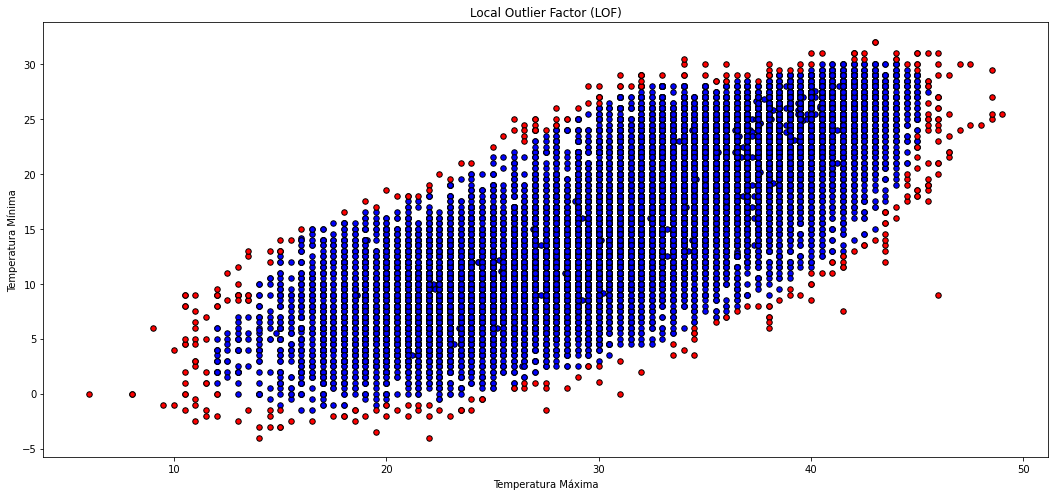

In [58]:
clf = LocalOutlierFactor(n_neighbors=200, contamination='auto')
X = df[['Tmax', 'Tmin']].values
y_pred = clf.fit_predict(X)

plt.figure(figsize=(18,8))
# plot the level sets of the decision function

in_mask = [True if l == 1 else False for l in y_pred]
out_mask = [True if l == -1 else False for l in y_pred]

plt.title("Local Outlier Factor (LOF)")
# inliers
a = plt.scatter(X[in_mask, 0], X[in_mask, 1], c = 'blue',
                edgecolor = 'k', s = 30)
# outliers
b = plt.scatter(X[out_mask, 0], X[out_mask, 1], c = 'red',
                edgecolor = 'k', s = 30)
#plt.axis('Tprom')
plt.xlabel('Temperatura Máxima');
plt.ylabel('Temperatura Mínima');
plt.show()

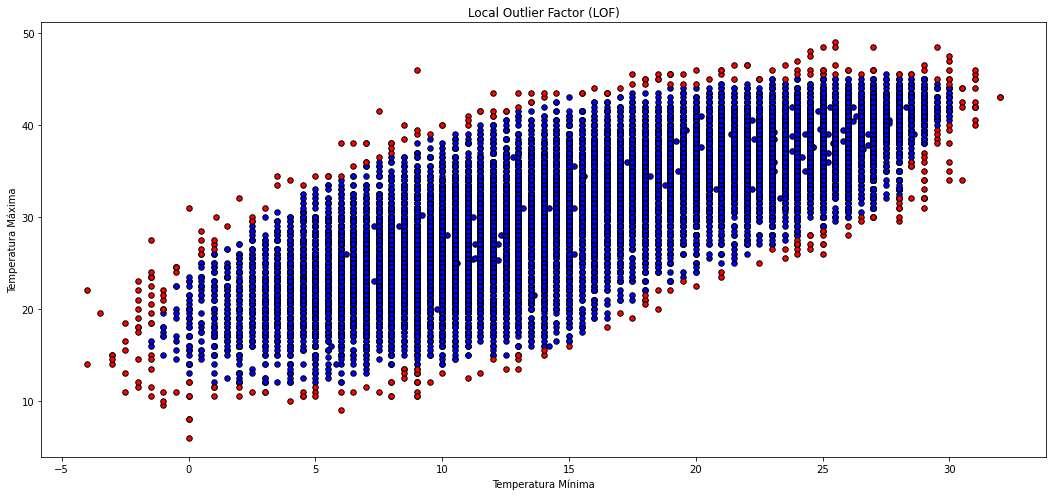

In [59]:
clf = LocalOutlierFactor(n_neighbors=200, contamination='auto')
X = df[['Tmin', 'Tmax']].values
y_pred = clf.fit_predict(X)

plt.figure(figsize=(18,8))
# plot the level sets of the decision function

in_mask = [True if l == 1 else False for l in y_pred]
out_mask = [True if l == -1 else False for l in y_pred]

plt.title("Local Outlier Factor (LOF)")
# inliers
a = plt.scatter(X[in_mask, 0], X[in_mask, 1], c = 'blue',
                edgecolor = 'k', s = 30)
# outliers
b = plt.scatter(X[out_mask, 0], X[out_mask, 1], c = 'red',
                edgecolor = 'k', s = 30)
#plt.axis('Tprom')
plt.xlabel('Temperatura Mínima');
plt.ylabel('Temperatura Máxima');
plt.show()

### Bosques de Aislamiento

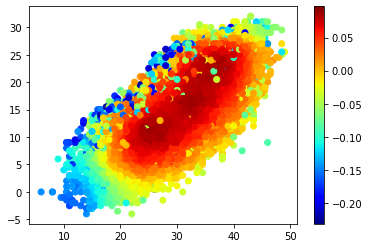

In [69]:
clf = IsolationForest(n_estimators=1000, warm_start=True)
X = df[['Tmax', 'Tmin','UCalor','Precip','Evap']].values
clf.fit(X)

# Si warm_start es True, se le puede ir agregando estimadores poco a poco
#clf.set_params(n_estimators=20) 
#clf.fit(X)

estimado_IF = clf.decision_function(X)

plt.scatter(x=X[:,0], y=X[:,1], c=estimado_IF, cmap='jet')
plt.colorbar()
plt.show()

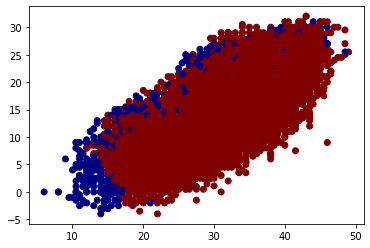

In [70]:
plt.scatter(x=X[:,0], y=X[:,1], c=np.where(estimado_IF > -0.1, 1, 0), cmap='jet')
plt.show()

### Z-Score

Con este método se pretenden conocer los valores más raros de las temperaturas máximas y mínimas en cada mes por cada año registrado. Se probará detectar anomalías con 3.5 y 4 desviaciones estándar.

In [64]:
def zscore(d, var, n_stds):
    outliers = []
    mean = np.mean(d.iloc[:,var])
    std = np.std(d.iloc[:,var])
    for i in range(len(d)):
        z_score= (d.iloc[i,var] - mean)/std 
        if np.abs(z_score) > n_stds:
            outliers.append(i)
    return outliers, mean, std

#### Detección de outliers con 3.5 desviaciones estándar

##### Temperaturas mínimas anormales

In [65]:
pd.set_option('expand_frame_repr', False)
print("*************** TEMPERATURAS MÍNIMAS ANORMALES (CON 3.5 DESVIACIONES ESTÁNDAR)********************\n")
for anio in range(df.Fecha.dt.year.min(), df.Fecha.dt.year.max()+1):
    df_anio = df[df.Fecha.dt.year == anio]
    df_actual = pd.DataFrame()
    for i in range(1,13):
        df_anio_mes = df_anio[df_anio.Fecha.dt.month == i]
        outliers_idx, media, std = zscore(df_anio_mes, 2, 3.5)
        if outliers_idx:
            tmp_df = df_anio_mes.iloc[outliers_idx, [0,1,2,3]]
            tmp_df['media_mes'] = media
            tmp_df['std_mes'] = std
            df_actual = pd.concat([df_actual, tmp_df])
    if not df_actual.empty:
        print(f"OUTLIERS ENCONTRADOS EN {anio}")
        print(df_actual)
        print("-------------------------------------------------------------------------\n")

*************** TEMPERATURAS MÍNIMAS ANORMALES (CON 3.5 DESVIACIONES ESTÁNDAR)********************

OUTLIERS ENCONTRADOS EN 1976
          Fecha               Estacion  Tmin  Tmax  media_mes   std_mes
8692 1976-04-27  HERMOSILLO (FFCC)-SON   0.0  31.0  12.327273  3.206128
-------------------------------------------------------------------------

OUTLIERS ENCONTRADOS EN 1977
           Fecha                 Estacion  Tmin  Tmax  media_mes   std_mes
25043 1977-05-31  HERMOSILLO II (DGE)-SON  27.0  41.0  13.947368  3.388816
18415 1977-08-31   HERMOSILLO I (DGE)-SON  14.0  34.0  24.800000  2.160633
9124  1977-09-30    HERMOSILLO (FFCC)-SON  16.0  40.0  23.730435  2.194149
18474 1977-11-01   HERMOSILLO I (DGE)-SON  25.0  32.0  12.869565  3.138185
-------------------------------------------------------------------------

OUTLIERS ENCONTRADOS EN 1978
          Fecha               Estacion  Tmin  Tmax  media_mes   std_mes
9418 1978-09-18  HERMOSILLO (FFCC)-SON  12.0  36.0  23.158824  3.171761


##### Temperaturas máximas anormales

In [66]:
pd.set_option('expand_frame_repr', False)

print("*************** TEMPERATURAS MÁXIMAS ANORMALES (CON 3.5 DESVIACIONES ESTÁNDAR) ********************\n")
for anio in range(df.Fecha.dt.year.min(), df.Fecha.dt.year.max()+1):
    df_anio = df[df.Fecha.dt.year == anio]
    df_actual = pd.DataFrame()
    for i in range(1,13):
        df_anio_mes = df_anio[df_anio.Fecha.dt.month == i]
        outliers_idx, media, std = zscore(df_anio_mes, 3, 3.5)
        if outliers_idx:
            tmp_df = df_anio_mes.iloc[outliers_idx, [0,1,2,3]]
            tmp_df['media_mes'] = media
            tmp_df['std_mes'] = std
            df_actual = pd.concat([df_actual, tmp_df])
    if not df_actual.empty:
        print(f"OUTLIERS ENCONTRADOS EN {anio}")
        print(df_actual)
        print("-------------------------------------------------------------------------\n")

*************** TEMPERATURAS MÁXIMAS ANORMALES (CON 3.5 DESVIACIONES ESTÁNDAR) ********************

OUTLIERS ENCONTRADOS EN 1967
           Fecha                Estacion  Tmin  Tmax  media_mes   std_mes
14777 1967-04-12  HERMOSILLO I (DGE)-SON  10.5  20.0  29.883333  2.800843
14919 1967-09-01  HERMOSILLO I (DGE)-SON  21.5  28.0  37.750000  2.580407
-------------------------------------------------------------------------

OUTLIERS ENCONTRADOS EN 1971
           Fecha                Estacion  Tmin  Tmax  media_mes   std_mes
16406 1971-09-30  HERMOSILLO I (DGE)-SON  25.0  26.0  37.283333  2.865552
-------------------------------------------------------------------------

OUTLIERS ENCONTRADOS EN 1983
           Fecha                 Estacion  Tmin  Tmax  media_mes   std_mes
27089 1983-02-02  HERMOSILLO II (DGE)-SON   9.0  12.0  24.481818  3.345232
-------------------------------------------------------------------------

OUTLIERS ENCONTRADOS EN 1984
          Fecha           Estacion  Tm

#### Detección de outliers con 4 desviaciones estándar

##### Temperaturas mínimas anormales

In [67]:
pd.set_option('expand_frame_repr', False)
print("*************** TEMPERATURAS MÍNIMAS ANORMALES (CON 4 DESVIACIONES ESTÁNDAR)********************\n")
for anio in range(df.Fecha.dt.year.min(), df.Fecha.dt.year.max()+1):
    df_anio = df[df.Fecha.dt.year == anio]
    df_actual = pd.DataFrame()
    for i in range(1,13):
        df_anio_mes = df_anio[df_anio.Fecha.dt.month == i]
        outliers_idx, media, std = zscore(df_anio_mes, 2, 4)
        if outliers_idx:
            tmp_df = df_anio_mes.iloc[outliers_idx, [0,1,2,3]]
            tmp_df['media_mes'] = media
            tmp_df['std_mes'] = std
            df_actual = pd.concat([df_actual, tmp_df])
    if not df_actual.empty:
        print(f"OUTLIERS ENCONTRADOS EN {anio}")
        print(df_actual)
        print("-------------------------------------------------------------------------\n")

*************** TEMPERATURAS MÍNIMAS ANORMALES (CON 4 DESVIACIONES ESTÁNDAR)********************

OUTLIERS ENCONTRADOS EN 1977
           Fecha                Estacion  Tmin  Tmax  media_mes   std_mes
18415 1977-08-31  HERMOSILLO I (DGE)-SON  14.0  34.0       24.8  2.160633
-------------------------------------------------------------------------

OUTLIERS ENCONTRADOS EN 2001
           Fecha                 Estacion  Tmin  Tmax  media_mes   std_mes
33870 2001-09-30  HERMOSILLO II (DGE)-SON  17.0  21.5  25.983333  2.131053
-------------------------------------------------------------------------



##### Temperaturas máximas anormales

In [68]:
pd.set_option('expand_frame_repr', False)

print("*************** TEMPERATURAS MÁXIMAS ANORMALES (CON 4 DESVIACIONES ESTÁNDAR) ********************\n")
for anio in range(df.Fecha.dt.year.min(), df.Fecha.dt.year.max()+1):
    df_anio = df[df.Fecha.dt.year == anio]
    df_actual = pd.DataFrame()
    for i in range(1,13):
        df_anio_mes = df_anio[df_anio.Fecha.dt.month == i]
        outliers_idx, media, std = zscore(df_anio_mes, 3, 4)
        if outliers_idx:
            tmp_df = df_anio_mes.iloc[outliers_idx, [0,1,2,3]]
            tmp_df['media_mes'] = media
            tmp_df['std_mes'] = std
            df_actual = pd.concat([df_actual, tmp_df])
    if not df_actual.empty:
        print(f"OUTLIERS ENCONTRADOS EN {anio}")
        print(df_actual)
        print("-------------------------------------------------------------------------\n")

*************** TEMPERATURAS MÁXIMAS ANORMALES (CON 4 DESVIACIONES ESTÁNDAR) ********************

OUTLIERS ENCONTRADOS EN 1987
           Fecha                 Estacion  Tmin  Tmax  media_mes   std_mes
28747 1987-08-21  HERMOSILLO II (DGE)-SON  23.0  31.0  38.288043  1.763509
-------------------------------------------------------------------------

OUTLIERS ENCONTRADOS EN 1988
           Fecha                Estacion  Tmin  Tmax  media_mes   std_mes
21788 1988-06-01  HERMOSILLO I (DGE)-SON  17.0  30.5  39.838889  2.275263
-------------------------------------------------------------------------

OUTLIERS ENCONTRADOS EN 2001
           Fecha                 Estacion  Tmin  Tmax  media_mes   std_mes
33870 2001-09-30  HERMOSILLO II (DGE)-SON  17.0  21.5       38.8  4.046809
-------------------------------------------------------------------------

OUTLIERS ENCONTRADOS EN 2004
           Fecha                 Estacion  Tmin  Tmax  media_mes   std_mes
34906 2004-08-01  HERMOSILLO II (DGE)

Con este simple algoritmo podemos conocer las anomalías históricas en el comportamiento de la temperatura del municipio de Hermosillo. Hay varios casos muy curiosos, por ejemplo que el 26 de agosto de 1993, en pleno e infernal verano, en Bahía de Kino se haya registrado una temperatura mínima de 16°C cuando la temperatura mínima promedio en ese mes fue de 25°C.

Sin embargo, hay que tener cuidado a la hora de definir el número de desviaciones estándar a tomar en cuenta para la detección de valores atípicos. En este ejemplo puede apreciarse una disminución considerable de outliers al incrementar el número de desviaciones de 3.5 a 4.

## Conclusiones

En este trabajo se han dado a conocer datos históricos reales de algunas variables meteorológicas que nos han permitido conocer el comportamiento del clima en el municipio de Hermosillo, Sonora, México.También hemos propuesto un algoritmo simple pero efectivo para realizar imputación de datos faltantes en variables numéricas. Finalmente, relizamos una detección de anomalías con dos algoritmos diferentes: *Local Outlier Factor* y *Bosques de aislamiento* para detectar días con cambios de temperatura extremos y *Z-Score* para conocer los días en los que la temperatura ambiental fue muy peculiar y diferente a la que se presentó en un mes en específico.